# CM 50270 Reinforcement Learning: Coursework 2 

**Date set:** March 12, 2018 

**Date due:** 8 pm on March 21, 2018 

**Total number of marks:** 100. (This coursework will determine 20% of your final grade for CM 50270.)

**What to submit:** Completed Jupyter notebook (.ipynb file) that includes all source code. Please do not change the file name.

**Where to submit:** CM50270 Moodle page

This coursework will be __marked anonymously__. Please do not include any identifying information on the files you submit. 

You are required to __work individually__. You are welcome to discuss ideas with others but you must design your own implementation and write your own code.

__Do not plagiarise__. Plagiarism is a serious academic offence. For details on what it is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.

Remember to save your work regularly. 

## Exercise 1: Blackjack (20 marks)

In this first exercise, you will implement **Monte Carlo Policy Evaluation (MCPE)** to learn the state-value function $V(s)$ for a given policy in the game of [blackjack](https://en.wikipedia.org/wiki/Blackjack).

### The game

**Rules.** We will use the version of the game discussed in the lectures where a single player (the agent) plays against the dealer. The player's objective is to obtain cards whose sum is as large as possible without exceeding 21. All face cards count as 10; an ace can count as either 1 or 11.

The game begins with two cards dealt to both the dealer and the player. The first of the dealer’s cards is face down and the second is face up. If the player has 21 immediately (for example, an ace and a face card), it is called a "blackjack". The player then wins unless the dealer also has a blackjack, in which case the game is a draw. If the player does not have a blackjack, then she can request additional cards, one by one (_hits_), until she either stops (_sticks_) or exceeds 21 (_goes bust_). If the player goes bust, she loses; if she sticks, then it becomes the dealer’s turn. 

The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome (win, lose, or draw) is determined by whose final sum is closer to 21.

**MDP formulation.** Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards until the end of the game are zero. We do not discount ($\gamma = 1$); therefore these terminal rewards are also the returns. The player’s actions are to `"hit"` or to `"stick"`. 

The states depend on the player’s cards and the dealer’s showing card. Assume that cards are dealt from an infinite deck (that is, with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that she could count as 11 without going bust, then the ace is said to be _usable_. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: 
- the player's current sum (an integer between 12 and 21);
- the dealer’s one showing card (an integer between 1 and 10; note that the ace is counted as 1 here); and
- whether or not the player holds a usable ace (a boolean). 

This makes for a total of 200 states. We represent the state as a numpy-array of length 3 that combines the just mentioned three variables in the given order. For example, if the player is given a 6 and a _jack_, and the dealer's showing card is an ace, the corresponding state will be the numpy array `[16, 1, False]`. The terminal state of the game will be denoted by the numpy array `[-1, -1, -1]`.

###  Blackjack code you may use if you wish

** Please feel free to skip this section and implement your own blackjack code **

We provide a `Blackjack` class that you can use to simulate blackjack games. The following cells in this section will walk you through the basic usage of this class by playing a couple of blackjack games.  

We import the blackjack module and create a blackjack environmnet called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the blackjack object will regularly print the progress of the game. This is useful for getting to know the game and the provided code or if you just want to play around. You may want to set `verbose=False` when you run thousands of episodes to complete the exercise below.

In [1]:
import blackjack
env = blackjack.Blackjack(verbose=True)

You can interact with the blackjack environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. Specifically, this method returns the resulting `new_state` and the corresponding `reward` signal.

Before the player can perform actions, we have to start the game (e.g., draw starting hands). In order to start or reset a blackjack game, call the `make_step()` without specifying a specific action or by setting `action="reset"`.

We will now walk through several example games. We will specify a [random seed](https://en.wikipedia.org/wiki/Random_seed) for the NumPy pseudo random number generator every time before we reset the game. This allows us to keep these examples reproducible.

In [2]:
import numpy as np
np.random.seed(8)
new_state, reward = env.make_step(action="reset")
print("Initial state:", new_state)
print("Reward:", reward)

The game is reset.
Player's cards: [10, 10]
Dealer's showing card: [7]
Initial state: [20  7  0]
Reward: 0


The player drew two cards with face value 10 each. The dealer also drew two cards, but we can only see the second card, a 7. The player now can choose to "hit" or "stick". Most players would stick if they had 20 on their hand. We call again the `make_step()` method and specify `action="stick"`.

In [3]:
new_state, reward = env.make_step(action = "stick")
print("The player obtains a reward of", reward)
print("The new (terminal) state is:", new_state)

The dealer's cards are: [10, 7]
The dealer has 17 points.
PLAYER WINS!
The player obtains a reward of 1
The new (terminal) state is: [-1 -1 -1]


The player won and received a reward of 1. Whenever an episode ends, the environment object sets the internal variable `self.active` to `False`. This variable is set to `True` again when we _reset_ the game. You can use the `self.active` variable to check whether an episode has ended or not.

In [4]:
np.random.seed(9)
new_state, reward = env.make_step(action="reset")
print("New state:", new_state)

The game is reset.
Player's cards: [11, 7]
Dealer's showing card: [2]
New state: [18  2  1]


The player has already 18 points but has a _usable ace_, which she can transfer into a 1 whenever she would _go bust_. The player can thus "hit" and hope that she gets closer to 21. 

In [5]:
new_state, reward = env.make_step(action = "hit")

Player draws card: [2]
New sum of player's cards: [20]


Great! The player got another 2 points and has again 20 points. The player would probably want to "stick" again...

In [6]:
new_state, reward = env.make_step(action = "stick")

The dealer's cards are: [7, 2]
The dealer has 9 points.
Dealer draws card: [3]
New dealer sum [12]
Dealer draws card: [6]
New dealer sum [18]
PLAYER WINS!


The player won again! Let's play a last one.

In [7]:
np.random.seed(7)
new_state, reward = env.make_step()
print("Reward:", reward)

The game is reset.
Player's cards: [11, 10]
Dealer's showing card: [10]
Player has Blackjack!
The dealer's cards are: [6, 10]
PLAYER WINS!
Reward: 1


The player drew a "Blackjack", that is, an ace and a 10. The dealer's cards valued 16. The player won again and received a reward without having performed an action. Try out some more games to get familiar with the code!

### Instructions

Your task is to learn the state-value function for the policy **"Stick if the player's sum is 19 or higher, and hit otherwise."**. Your code should compute these state values using **Monte Carlo Policy Evaluation (MCPE)**. For your reference, the pseudo-code for MCPE is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 5.1).
<img src="images/MCPE.png" style="width: 400px;"/>
The provided pseudo-code shows _first-visit_ MCPE. No state occurs twice during one game (episode) of Blackjack. In this case, first-visit MCPE and every-visit MCPE are identical.

You will have to provide a function `get_state_value(s, v)` that takes as input a state `s` (a numpy array of length 3 as described in the MDP formulation of blackjack) and the state values `v` that you computed. The `get_state_value(s, v)` should return the correponding state value $V(s)$ as a float. There are no restrictions on how you store the state values `v`.

We will mark your code by calling `get_state_value(s, v)` for different states valid states `s` in the _test cell_.

In [30]:
# This cell should compute the state values 'v' using MCPE.
import blackjack

env = blackjack.Blackjack(verbose=False)

def policy(state):
    if state[0] >= 19:
        action = "stick"
    else:
        action = "hit"
    return action

num_episodes = 10000

v = {}

for player_sum in range(12, 22):
    for dealer_sum in range(1, 11):
        for usable_ace in range(0, 2):
            v[(player_sum, dealer_sum, usable_ace)] = 0

#print(len(v))
#print(v)

rewards = v.copy()
visited_states = v.copy()

for episode in range(1, num_episodes + 1):
    state, _ = env.make_step(action="reset")
    while state[0] != -1:
        action = policy(state)
        new_state, reward = env.make_step(action)
        rewards[tuple(state)] += reward
        visited_states[tuple(state)] += 1
        state = new_state
 
#print(rewards)
#print(visited_states)

for key, value in v.items():
    v[key] = rewards[key] / visited_states[key]
for key, value in v.items():
    print("State: ", key, "\tValue: ", value)
    
#print(v)

State:  (12, 1, 0) 	Value:  -0.41935483870967744
State:  (12, 1, 1) 	Value:  0.0
State:  (12, 2, 0) 	Value:  -0.35789473684210527
State:  (12, 2, 1) 	Value:  0.0
State:  (12, 3, 0) 	Value:  -0.3854166666666667
State:  (12, 3, 1) 	Value:  0.0
State:  (12, 4, 0) 	Value:  -0.308411214953271
State:  (12, 4, 1) 	Value:  0.0
State:  (12, 5, 0) 	Value:  -0.2926829268292683
State:  (12, 5, 1) 	Value:  0.0
State:  (12, 6, 0) 	Value:  -0.3125
State:  (12, 6, 1) 	Value:  0.0
State:  (12, 7, 0) 	Value:  -0.18085106382978725
State:  (12, 7, 1) 	Value:  0.0
State:  (12, 8, 0) 	Value:  -0.32051282051282054
State:  (12, 8, 1) 	Value:  0.0
State:  (12, 9, 0) 	Value:  -0.2882882882882883
State:  (12, 9, 1) 	Value:  0.0
State:  (12, 10, 0) 	Value:  -0.2784090909090909
State:  (12, 10, 1) 	Value:  0.0
State:  (13, 1, 0) 	Value:  -0.4482758620689655
State:  (13, 1, 1) 	Value:  0.0
State:  (13, 2, 0) 	Value:  -0.4574468085106383
State:  (13, 2, 1) 	Value:  0.0
State:  (13, 3, 0) 	Value:  -0.4042553191489361

In [36]:
# Complete the function definition for get_state_value(s,v) in this cell.
def get_state_value(s, v):
    
    state = tuple(s)
    value_of_s = v[state]
    
    return value_of_s

print(get_state_value([20,8,0], v))


0.835820895522388


In [ ]:
# This is the TEST CELL for Exercise 1. We will use it to mark your solution. 
# All of your code for Exercise 1 must be written above this cell. 

## Exercise 2: Tic-Tac-Toe (80 marks)

In this exercise you will implement the game of [Tic-Tac-Toe](https://en.wikipedia.org/wiki/Tic-tac-toe) (also known as _noughts and crosses_) and learn an optimal policy using **Q-learning**. You will then implement **SARSA** and compare the two learning approaches with each other.

### The game

Tic-Tac-Toe is a paper-and-pencil game for two players, O and X, who take turns marking the spaces in a 3×3 grid. The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row wins the game. The following example game is won by player X (example from [Wikipedia](https://en.wikipedia.org/wiki/Tic-tac-toe)):
<img src="images/tic-tac-toe_WIKI.png" style="width: 600px;"/> 

### Instructions
Implement the game of Tic-Tac-Toe. The first-moving player is randomly chosen at the beginning of each episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero; do not discount ($\gamma = 1$). Player X will always be played by a _random agent_. This agent randomly chooses one of the empty grid spaces and marks it with "X". You will implement different agents for Player O.

We will ask you to plot your results and to discuss the produced plots. Please make sure to **label your figures appropriately**. Please only use plotting packages that come pre-installed with Anaconda 3. We recommend the package `matplotlib` (the tutorial provided in the first lab contains a whole section on matplotlib).

### Exercise 2a: Random policy against a random policy (10 marks)
Test your Tic-Tac-Toe implementation by letting two random agents play against each other. Plot the cumulative rewards of both O and X as a function of the number of episodes played. 

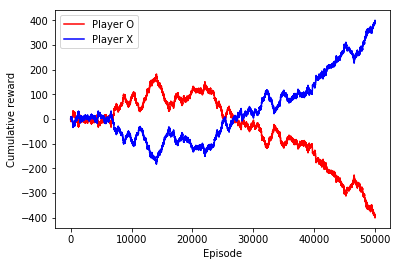

In [8]:
### Your code for Exercise 2a
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

class Tictactoe():
    
    def __init__(self):
        self.players = {"O": 1, "X": 2}
        self.winners = np.array([
            [0, 1, 2], [3, 4, 5], [6, 7, 8],
            [0, 3, 6], [1, 4, 7], [2, 5, 8],
            [0, 4, 8], [2, 4, 6]
            ])
        self.board = self.create_board()

    def create_board(self):
        return np.zeros(9, dtype=int)

    def print_board(self):
        b = np.reshape(self.board, (3,3))
        print(b)

    def choose_move(self):
        valid_moves = []

        for i in range(9):
            if self.board[i] == 0:
                valid_moves.append(i)
        
        move = random.choice(valid_moves)
        return move

    def make_move(self, player, move):
        piece = self.players[player]
        #print(piece)
        self.board[move] = piece

    def check_win(self):
        for _, player in self.players.items():
            for row in self.winners:
                if all([self.board[cell] == player for cell in row]):
                    return player

        for i in range(9):
            if self.board[i] == 0:
                return None # No one has won yet

        # Otherwise, game is a draw
        return 0

    def play(self):
        #board = create_board()
        #print_board(board)
        p = list(self.players.items())
        random.shuffle(p)
        #print(p[0])
        for player, _ in itertools.cycle(p):
            move = self.choose_move()
            self.make_move(player, move)
            winner = self.check_win()
            if winner != None:
                #if winner == 0:
                    # Game is a draw
                    #print("Game is a draw")
                #elif winner == 1:
                    #print("Player O wins")
                #elif winner == 2:
                    #print("Player X wins")
                #print(winner)
                return winner
    



num_episodes = 50000

results_O = np.zeros(num_episodes)
results_X = np.zeros(num_episodes)

for episode in range(num_episodes):
    t = Tictactoe()
    result = t.play()
    #print(t.board)
    if result == 0:
        results_O[episode] = 0
        results_X[episode] = 0
    elif result == 1:
        results_O[episode] = 1
        results_X[episode] = -1
    elif result == 2:
        results_O[episode] = -1
        results_X[episode] = 1

#print(results_O)
#print(results_X)

cum_results_O = np.cumsum(results_O)
cum_results_X = np.cumsum(results_X)

#print(cum_results_O)
#print(cum_results_X)

plt.plot(cum_results_O, color="red", label="Player O")
plt.plot(cum_results_X, color="blue", label="Player X")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.legend()
plt.show()

In a few sentences, discuss your results. Did you expect these results? Why or why not? (We will mark only the first three sentences. Please do not write any longer than that.) 

The cumulative returns of player O and X are equal and opposite, as expected for Tic-tac-toe which is a zero-sum game. Neither player has a clear advantage as the number of episodes increases because both players are random and who moves first is also random.



### Exercise 2b: Q-learning (20 marks)
Use Q-learning to learn an optimal policy for playing Tic-Tac-Toe against a random opponent. Produce a learning curve for your agent. That is, (1) plot average return as a function of episodes, (2) the learning curve should plot the average return of many agents (please specify how many agents you are averaging). 

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>
 

In [68]:
import numpy as np
import random

class Tictactoe_Q():
    
    def __init__(self):
        self.players = {"Q": 1, "R": 2}
        self.winners = np.array([
            [0, 1, 2], [3, 4, 5], [6, 7, 8],
            [0, 3, 6], [1, 4, 7], [2, 5, 8],
            [0, 4, 8], [2, 4, 6]
            ])
        self.board = self.create_board()
        self.done = 0

    def create_board(self):
        return np.zeros(9, dtype=int)

    def print_board(self):
        b = np.reshape(self.board, (3,3))
        print(b)

    def get_available_actions(self):
        valid_moves = []

        for i in range(9):
            if self.board[i] == 0:
                valid_moves.append(i)
        
        return valid_moves

    def make_move(self, player, move):
        piece = self.players[player]
        #print(piece)
        self.board[move] = piece
    
    def is_done(self):
        return self.done
    
    def get_reward(self, winner):
        if winner == 0:
            return 0
        elif winner == 1:
            return 1
        elif winner == 2:
            return -1

    def check_win(self): # check
        for _, player in self.players.items():
            for row in self.winners:
                if all([self.board[cell] == player for cell in row]):
                    self.done = 1
                    return player

        for i in range(9):
            if self.board[i] == 0:
                return None # No one has won yet

        # Otherwise, game is a draw
        self.done = 1
        return 0


qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q

Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	

qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
C

qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Update

qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, -0.1, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0

Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q

qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.010000000000000002, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.010000000000000002
Current Q: 0.0
Updated Q: 0.0010000000000000002
qs: [0.0, 0.0, 0.0, 0.0, 0.19] 	Max q: 0.19
Current Q: 0.010000000000000002
Updated Q: 0.028000000000000004
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs

qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.012192873826757539
Updated Q: 0.010973586444081786
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.010973586444081786
Updated Q: 0.009876227799673608
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
q

Updated Q: 0.19
qs: [0.0, 0.05480200000000001, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.05480200000000001
Current Q: 0.014528904699924947
Updated Q: 0.018556214229932453
qs: [0.19, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.19
Current Q: 0.05480200000000001
Updated Q: 0.06832180000000002
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.06832180000000002, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.06832180000000002
Current Q: 0.018556214229932453
Updated Q: 0.02353277280693921
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0

Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.042363000000000005, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.042363000000000005
Current Q: 0.02768212392195318
Updated Q: 0.029150211529757865
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.042363000000000005
Updated Q: 0.038126700000000006
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.038126700000000006, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.038126700000000006
Current Q: 0.029150211529757865
Updated Q: 0.03004786037678208
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.038126700000000006
Updated Q: 0.03431403000000001
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Current Q: 0.03088262700000001
Updated Q: 0.02779436430000001
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.005904900000000003, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.005904900000000003
Current Q: 0.027210857335237797
Updated Q: 0.02508026160171402
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.005904900000000003
Updated Q: 0.005314410000000003
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0

Updated Q: 0.039583958282160686
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.02779436430000001, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.02779436430000001
Current Q: 0.022153336403390074
Updated Q: 0.022717439193051067
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.02779436430000001
Updated Q: 0.02501492787000001
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.039583958282160686, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.039583958282160686
Current Q: 0.0227174391930

Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [-0.1, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.006104672100000003, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.006104672100000003
Current Q: 0.04378607008356739
Updated Q: 0.040017930285210654
qs: [0.0, 0.0, 0.0, 0.0, 0.1] 	Max q: 0.1
Current Q: 0.006104672100000003
Updated Q: 0.015494204890000005
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.10735327541017804, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.10735327541017804
Current Q: 0.040017930285210654
Updated Q: 0.04675146479770739
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.10735327541017804
Updated Q: 0.09661794786916024
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Cu

Updated Q: 0.013053081880000003
qs: [0.271, 0.0, 0.0] 	Max q: 0.271
Current Q: 0.010000000000000002
Updated Q: 0.03610000000000001
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.03542397180066616
Updated Q: 0.03188157462059954
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010000000000000002] 	Max q: 0.010000000000000002
Current Q: 0.03188157462059954
Updated Q: 0.029693417158539587
qs: [0.0, 0.0, 0.0, 0.1, 0.0] 	Max q: 0.1
Current Q: 0.010000000000000002
Updated Q: 0.0190000

qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.026470186131678876
Updated Q: 0.02382316751851099
qs: [0.1, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
C

qs: [0.0, 0.0, 0.0, 0.0, 0.34390000000000004] 	Max q: 0.34390000000000004
Current Q: 0.09084411534161389
Updated Q: 0.11614970380745251
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.04257276

Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.1, 0.0] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0

Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07088950376074901] 	Max q: 0.07088950376074901
Current Q: 0.06543504967792875
Updated Q: 0.06598049508621077
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.07088950376074901
Updated Q: 0.06380055338467411
qs: [0.1, 0.0, 0.0] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06380055338467411] 	Max q: 0.06380055338467411
Current Q: 0.06598049508621077
Updated Q: 0.0657625009160571
qs: [0.0, 0.0, 0.0, -0.1, -0.1] 	Max q: 0.0
Current Q: 0.06380055338467411
Updated Q: 0.0574204980462067
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.12354682066806962, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.12354682066806962
Current Q

Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.05365420489000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.05365420489000001
Current Q: 0.08840895138693688
Updated Q: 0.0849334767372432
qs: [0.1, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.1
Current Q: 0.05365420489000001
Updated Q: 0.05828878440100001
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.1, 0.0] 	Max q: 0.1
Current Q: 0.0
Up

Updated Q: 0.09983364818682529
qs: [0.5217031000000001, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.5217031000000001
Current Q: 0.09367649030208094
Updated Q: 0.13647915127187288
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5217031000000001
Updated Q: 0.5695327900000001
qs: [0.0, 0.0, 0.21414367812265966, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.21414367812265966
Current Q: 0.09983364818682529
Updated Q: 0.11126465118040872
qs: [0.0, 0.0, 0.0, 0.0, 0.46855900000000006] 	Max q: 0.46855900000000006
Current Q: 0.21414367812265966
Updated Q: 0.2395852103103937
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.010000000000000002, 0.0, 0.0, 0.0] 	Max q: 0.010000000000000002
Current Q: 0.0
Updated Q: 0.0010000000000000002
qs: [0.0, 0.19] 	Max q: 0.19
Current Q: 0.010000000000000002
Updated Q: 0.028000000000000004
qs: [0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.05245990

qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10349709959076106] 	Max q: 0.10349709959076106
Current Q: 0.1215584623612525
Updated Q: 0.11975232608420337
qs: [0.0, 0.0, 0.0, 0.271, 0.003610000000000001] 	Max q: 0.271
Current Q: 0.10349709959076106
Updated Q: 0.12024738963168495
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.1116842714454961, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.1116842714454961
Current Q: 0.11975232608420337
Updated Q: 0.11894552062033265
qs: [0.34390000000000004, 0.0, 0.0, 0.0, 0.

Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.20099967430410742, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.20099967430410742
Current Q: 0.14077061710673772
Updated Q: 0.14679352282647468
qs: [0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.20099967430410742
Updated Q: 0.1808997068736967
qs: [-0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.09741468440557441, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.09741468440557441
Current Q: 0.14679352282647468
Updated Q: 0.14185563898438464
qs: [0.271, 0.0, 0.

qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.15414420460194653, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.15414420460194653
Current Q: 0.1421139028573566
Updated Q: 0.14331693303181559
qs: [0.19, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.19
Current Q: 0.15414420460194653
Updated Q: 0.15772978414175187
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.010000000000000002
Current Q: 0.0
Updated Q: 0.0010000000000000002
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.010000000000000002
Updated Q: 0.009000000000000003
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0

qs: [0.0, 0.0, 0.14726588631092488, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.14726588631092488
Current Q: 0.17630467714566322
Updated Q: 0.17340079806218942
qs: [0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.14726588631092488
Updated Q: 0.13253929767983239
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.1816944195656646, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.1816944195656646
Current Q: 0.17340079806218942
Updated Q: 0.17423016021253696
qs: [0.271, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.271
Current Q: 0.1816944195656646
Updated Q: 0.19062497760909816
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [-0.1, 0.0, -0.1, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0010000000000000002
Updated Q: 0.0009000000000000002
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
C

Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.13253929767983239, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.13253929767983239
Current Q: 0.19388877493039405
Updated Q: 0.18775382720533787
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.009000000000000003, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.009000000000000003
Current Q: 0.0010000000000000002
Updated Q: 0.0018000000000000004
qs: [0.1, 0.0, 0.0, 0.0] 	Max q: 0.1
Current Q: 0.009000000000000003
Updated Q: 0.018100000000000005
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.001800000000000

qs: [0.46855900000000006, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.46855900000000006
Current Q: 0.14682818683220544
Updated Q: 0.1790012681489849
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [0.1790012681489849, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.1790012681489849
Current Q: 0.18561253125455413
Updated Q: 0.18495140494399723
qs: [0.5217031000000001, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.5217031000000001
Current Q: 0.1790012681489849
Updated Q: 0.21327145133408643
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5217031000000001
Updated Q: 0.5695327900000001
qs: [0.0, -0.1, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Upda

qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.21327145133408643, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.21327145133408643
Current Q: 0.20828644007324776
Updated Q: 0.20878494119933164
qs: [0.46855900000000006, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.46855900000000006
Current Q: 0.21327145133408643
Updated Q: 0.2388002062006778
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [0.04095100000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18694374513187306] 	Max q: 0.18694374513187306
Current Q: 0.20878494119933164
Updated Q: 0.20660082159258578
qs: [0.0, 0.0, 0.6125795110000001, 0.0, 0.0] 	Max q: 0.6125795110000001
Current Q: 0.18694374513187306
Updated Q: 0.22950732171868576
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6125795110000001
Updated Q: 0.6513215599

Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.2388002062006778, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.2388002062006778
Current Q: 0.23357216090861305
Updated Q: 0.23409496543781952
qs: [0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.2388002062006778
Updated Q: 0.21492018558061002
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.2674055773376022, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.2674055773376022
Current Q: 0.23409496543781952
Updated Q: 0.2374260266277978
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.2674055773376022
Updated Q: 0.24066501960384196
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q

Updated Q: 0.23627422933006745
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.23540731828822273
Updated Q: 0.21186658645940046
qs: [0.0, 0.010000000000000002, 0.0] 	Max q: 0.010000000000000002
Current Q: 0.0
Updated Q: 0.0010000000000000002
qs: [0.1] 	Max q: 0.1
Current Q: 0.010000000000000002
Updated Q: 0.019000000000000003
qs: [] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.2518606880263888, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.2518606880263888
Current Q: 0.23627422933006745
Updated Q: 0.2378328751996996
qs: [0.0, 0.0, 0.0, 0.271, 0.0] 	Max q: 0.271
Current Q: 0.2518606880263888
Updated Q: 0.2537746192237499
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.0017879104890000006
Updated Q: 0.0016091194401000005
qs: [0.19, 0.0, 0.0, 0.0] 	Max q: 0.19
Current Q: 0.0
Updated Q: 0.019000000000000003
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.040951000

Current Q: 0.006816399399000003
Updated Q: 0.006134759459100003
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.2636648859152554, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.2636648859152554
Current Q: 0.2754768619110278
Updated Q: 0.2742956643114506
qs: [0.0, 0.0, 0.0, 0.0, 0.6125795110000001] 	Max q: 0.6125795110000001
Current Q: 0.2636648859152554
Updated Q: 0.29855634842372986
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6125795110000001
Updated Q: 0.6513215599000001
qs: [0.0, 0.0, 0.26611434597303574, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.26611434597303574
Current Q: 0.2742956643114506
Updated Q: 0.2734775324776091
qs: [0.0, -0.1, 0.0, 0.0, 0.271] 	Max q: 0.271
Current Q: 0.26611434597303574
Updated Q: 0.26660291137573217
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0017100000000000004
Updated Q: 0.0015390000000000004
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current 

qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.23684352239290876, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.23684352239290876
Current Q: 0.2809772997916409
Updated Q: 0.27656392205176766
qs: [0.0, 0.0, 0.0, 0.34390000000000004, 0.0] 	Max q: 0.34390000000000004
Current Q: 0.23684352239290876
Updated Q: 0.24754917015361788
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.05460931000000001, 0.0] 	Max q: 0.05460931000000001
Current Q: 0.007911239645683903
Updated Q: 0.012581046681115513
qs: [-0.1, -0.1, 0.0, 

Updated Q: 0.00917158303053321
qs: [-0.1, -0.1, 0.0, 0.34390000000000004] 	Max q: 0.34390000000000004
Current Q: 0.0
Updated Q: 0.034390000000000004
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0, 0.0, 0.24754917015361788, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.24754917015361788
Current Q: 0.3233600467727399
Updated Q: 0.3157789591108277
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.019000000000000003, 0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.019000000000000003
Current Q: 0.004008303044366185
Updated Q: 0.005507472739929567
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.019000000000000003
Updated Q: 0.017100000000000004
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, -0.1, -0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.00573178226

qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.5217031000000001
Updated Q: 0.5695327900000001
qs: [0.008100000000000003, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.008100000000000003
Current Q: 0.0
Updated Q: 0.0008100000000000004
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.008100000000000003
Updated Q: 0.007290000000000003
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.26090976007981265, 0.0, 0.04095100000000001, 0.0, 0.0, 0.017100000000000004] 	Max q: 0.26090976007981265
Current Q: 0.34927842477139054
Updated Q: 0.34044155830223277
qs: [0.0, 0.0, 0.0, 0.0009000000000000002, 0.0] 	Max q: 0.0009000000000000002
Current Q: 0.26090976007981265
Updated Q: 0.23490878407183138
qs: [0.0, 0.0, 0.010000000000000002] 	Max q: 0.010000000000000002
Current Q: 0.0009000000000000002
Updated Q: 0.0018100000000000004
qs: [0.0] 	Max q: 0.0
Current Q: 0.010000000000000002
Updated Q: 0.009000000000000003
qs: [] 	Max q: 0.0
Current Q: 0.0
Upd

qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.40951000000000004
Updated Q: 0.46855900000000006
qs: [0.0, 0.0, 0.3970857272313306, 0.0, 0.0, 0.0, 0.010000000000000002] 	Max q: 0.3970857272313306
Current Q: 0.30771399406454536
Updated Q: 0.3166511673812239
qs: [0.0, 0.0, 0.0, 0.0, 0.46855900000000006] 	Max q: 0.46855900000000006
Current Q: 0.3970857272313306
Updated Q: 0.4042330545081976
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [0.0, -0.1, 0.0, 0.0, -0.09190000000000001, 0.0] 	Max q: 0.0
Current Q: 0.00668608402925871
Updated Q: 0.006017475626332839
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.018100000000000005, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.018100000000000005
Current Q: 0.002862882000000001
Updated Q: 0.004386593800000001
qs: [0.0, 0.0, 0.0, 0.19] 	Max q: 0.19
Current Q: 0.018100000000000005
Updated Q: 0.03529000000000001
qs: [0.0,

Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.006910989441838775
Updated Q: 0.006219890497654898
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.006219890497654898
Updated Q: 0.0055979014478894085
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.27427266011805734, 0.0, 0.04095100000000001, 0.0, 0.0, 0.017100000000000004] 	Max q: 0.27427266011805734
Current Q: 0.3685820159715455
Updated Q: 0.3591510803861967
qs: [0.5217031000000001, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.5217031000000001
Current Q: 0.27427266011805734
Updated Q: 0.2990157041062516
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5217031000000001
Updated Q: 0.5695327900000001
qs: [0.0, 0.0, 0.0, 0.0, -0.0011388130099999998, -0.09919] 	Max q: 0.0
Current Q:

qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.334041361416144, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.334041361416144
Current Q: 0.3664282935517192
Updated Q: 0.36318960033816167
qs: [0.0, 0.0, -0.091, 0.34390000000000004, -0.1] 	Max q: 0.34390000000000004
Current Q: 0.334041361416144
Updated Q: 0.33502722527452955
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.48834687162879936, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.48834687162879936
Current Q: 0.36318960033816167
Updated Q: 0.3757053274672254
qs: [0.010000000000000002, 0.0, 0.0, 0.0, 0.68618940391] 	M

Current Q: 0.0
Updated Q: 0.1
qs: [0.03441690000000001, 0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.03441690000000001
Current Q: 0.015318599603057686
Updated Q: 0.017228429642751918
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.03441690000000001
Updated Q: 0.030975210000000006
qs: [0.1, 0.0] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, -0.09000000000000001, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.003511163120861551
Updated Q: 0.003160046808775396
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.1, 0.0] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.4827534258065442, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.4827534258

Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, -0.1, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.005624746110000002
Updated Q: 0.005062271499000002
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.016290000000000006, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.016290000000000006
Current Q: 0.011696364037237002
Updated Q: 0.012155727633513302
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.016290000000000006
Updated Q: 0.014661000000000006
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.43989699653155073, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.43989699653155073
Current Q: 0.40533980198713276
Updated Q: 0.40879552144157455
qs: [0.0, 0.14360994363790003, 0.0, 0.0, 0.0] 	Max q: 0.14360994363790003
Current Q: 0.43989699653155073
Updated Q: 0.41026829124218567
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Cu

qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.4088136862062389
Updated Q: 0.36793231758561507
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.004269449893536333
Updated Q: 0.0038425049041827
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, -0.09000000000000001, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0029749543433677957
Updated Q: 0.002677458909031016
qs: [0.0, 0.0, 0.0, 0.34390000000000004] 	Max q: 0.34390000000000004
Current Q: 0.0
Updated Q: 0.034390000000000004
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.010000000000000002, 0.36793231758561507, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.36793231758561507
Current Q

Current Q: 0.5695327900000001
Updated Q: 0.6125795110000001
qs: [0.0, 0.0, 0.4534289704055534, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.4534289704055534
Current Q: 0.42536276192019573
Updated Q: 0.4281693827687315
qs: [0.0, 0.14360994363790003, 0.0, 0.0, 0.0] 	Max q: 0.14360994363790003
Current Q: 0.4534289704055534
Updated Q: 0.4224470677287881
qs: [0.052300000000000006, 0.0, 0.0] 	Max q: 0.052300000000000006
Current Q: 0.14360994363790003
Updated Q: 0.13447894927411005
qs: [0.34390000000000004] 	Max q: 0.34390000000000004
Current Q: 0.052300000000000006
Updated Q: 0.08146
qs: [] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [-0.1, 0.0, -0.1, -0.1, 0.0, 0.013392386090000014] 	Max q: 0.013392386090000

qs: [-0.1, 0.0, 0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.4519594073078093, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.4519594073078093
Current Q: 0.39130377106361297
Updated Q: 0.3973693346880326
qs: [0.0, 0.0, 0.0, 0.0, 0.7458134171671] 	Max q: 0.7458134171671
Current Q: 0.4519594073078093
Updated Q: 0.4813448082937384
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.7458134171671
Updated Q: 0.7712320754503901
qs: [0.0, 0.0, 0.4813448082937384, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.4813448082937384
Current Q: 0.3973693346880326
Updated Q: 0.4057668820486032
qs: [0.0, 0.0, 0.019000000000000003, 0.0, 0.0] 	Max q: 0.019000000000000003
Current Q: 0.0
Updated Q: 0.0019000000000000004
qs: [0.19, 0.0, 0.0] 	Max q: 0.19
Current Q: 0.019000000000000003
Updated Q: 0.03610000000000001
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.32949063350701246, 0.0010000

Current Q: 0.0
Updated Q: 0.1
qs: [-0.08000000000000002, 0.0, -0.1, -0.1, 0.0, 0.013392386090000014] 	Max q: 0.013392386090000014
Current Q: 0.020612633781557387
Updated Q: 0.019890609012401653
qs: [0.0, 0.0, 0.0, 0.34390000000000004] 	Max q: 0.34390000000000004
Current Q: 0.013392386090000014
Updated Q: 0.046443147481000015
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0019000000000000004, 0.0, 0.47911560769763706, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.47911560769763706
Current Q: 0.4107779409557619
Updated Q: 0.4176117076299495
qs: [0.0, 0.0, 0.0, 0.0, 0.7941088679053511] 	Max q: 0.7941088679053511
Current Q: 0.47911560769763706
Updated Q: 0.5106149337184085
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.7941088679053511
Updated Q: 0.814697981114816
qs: [0.0, 0.0, 0.0, -0.09190000000000001, 0.0009000000000000002, 0.0] 	Max q: 0.0009000000000000002
Current Q: 0.019890609012401653
Updated Q: 0.01799154811116149
qs: [0.0, 0.0, 0.0, 0.0] 

Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, -0.1] 	Max q: 0.0
Current Q: 0.012630843073123852
Updated Q: 0.011367758765811467
qs: [0.0, -0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.04095100000000001, 0.0, 0.019000000000000003, 0.0, 0.0, 0.0, 0.2382769337257924] 	Max q: 0.2382769337257924
Current Q: 0.4859248705781089
Updated Q: 0.46116007689287725
qs: [0.0, 0.0, 0.0, 0.5217031000000001, 0.003610000000000001] 	Max q: 0.5217031000000001
Current Q: 0.2382769337257924
Updated Q: 0.26661955035321316
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5217031000000001
Updated Q: 0.5695327900000001
qs: [0.0, 0.0, 0.0, -0.1, -0.0011388130099999998, -0.089271] 	Max q: 0.0
Current Q: 0.011367758765811467
Updated Q: 0.010230982889230321
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 

qs: [0.8499053647030009, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.8499053647030009
Current Q: 0.48389908576893076
Updated Q: 0.5204997136623378
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8499053647030009
Updated Q: 0.8649148282327008
qs: [0.5204997136623378, 0.0010000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.5204997136623378
Current Q: 0.4408363848300292
Updated Q: 0.4488027177132601
qs: [0.34390000000000004, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.34390000000000004
Current Q: 0.5204997136623378
Updated Q: 0.5028397422961041
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0017100000000000004, 0.0, 0.543311594018621, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.543311594018621
Current Q: 0.4488027177132601
Updated Q: 0.4582536053437962
qs: [0.0, 0.13103105434669907, 0.0, 0.0, 0.0] 	Max q: 0.13103105434669907
Current Q: 0.543311594018621
Updated Q: 0.5020835400514287
qs: [0.6513215599000001, 0.0, 0.0] 	Max q: 0.6513215599000001
Curren

Updated Q: 0.4552461567362401
qs: [0.0, 0.017100000000000004, 0.0, -0.08271, 0.0] 	Max q: 0.017100000000000004
Current Q: 0.5319666548570288
Updated Q: 0.4804799893713259
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.017100000000000004
Updated Q: 0.015390000000000004
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [-0.1, -0.08000000000000002, -0.1, -0.1, -0.1, 0.08700687114390002] 	Max q: 0.08700687114390002
Current Q: 0.039289417211296654
Updated Q: 0.044061162604556996
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.08700687114390002
Updated Q: 0.07830618402951002
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0017100000000000004, 0.0, 0.5508779245185061, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.5508779245185061
Current Q: 0.4552461567362401
Updated Q: 0.46480933351446674
qs: [0.04685590000000001, 0.0, 0.0, 0.010000000000000002, 0.901522909781639] 	Max q: 0.901522909781639
Current Q: 0.5508779245185061
Updated Q: 0

qs: [0.0, -0.1, 0.0, -0.1, -0.09190000000000001, 0.0] 	Max q: 0.0
Current Q: 0.005656548366483082
Updated Q: 0.005090893529834773
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.4779346361972566, 0.0, 0.04095100000000001, 0.0, 0.0, 0.017100000000000004] 	Max q: 0.4779346361972566
Current Q: 0.43945272638503563
Updated Q: 0.44330091736625776
qs: [0.0, 0.0, 0.0, 0.05314198690000001, 0.0] 	Max q: 0.05314198690000001
Current Q: 0.4779346361972566
Updated Q: 0.435455371267531
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.05314198690000001
Updated Q: 0.047827788210000007
qs: [0.40951000000000004] 	Max q: 0.40951000000000004
Current Q: 0.0
Updated Q: 0.04095100000000001
qs: [] 	Max q: 0.0
Current Q: 0.40951000000000004
Updated Q: 0.46855900000000006
qs: [-0.1, -0.1, -0.1, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.010055285766689738
Updated Q: 0.009049757190020765
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0017100000000000004, 0.0, 0

qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.04095100000000001, 0.0, 0.017100000000000004, 0.0, 0.0, 0.0, 0.23376949688934193] 	Max q: 0.23376949688934193
Current Q: 0.4714461658264761
Updated Q: 0.4476784989327627
qs: [0.0, 0.0, 0.0, 0.7458134171671, 0.0] 	Max q: 0.7458134171671
Current Q: 0.23376949688934193
Updated Q: 0.2849738889171177
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.7458134171671
Updated Q: 0.7712320754503901
qs: [0.010000000000000002, 0.44326179592835757, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.44326179592835757
Current Q: 0.4476784989327627
Updated Q: 0.44723682863232217
qs: [0.0, 0.0, 0.0, 0.0, 0.028000000000000004] 	Max q: 0.028000000000000004
Current Q: 0.44326179592835757
Updated Q: 0.40173561633552185
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.028000000000000004
Updated Q: 0.025200000000000004
qs: [0.1] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 

Updated Q: 0.0037184252515686128
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0016200000000000008
Updated Q: -0.098542
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, -0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, -0.1, 0.0, -0.1, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.0041236237591661664
Updated Q: 0.0037112613832495497
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.15199935084226907, 0.0] 	Max q: 0.15199935084226907
Current Q: 0.03186280759340967
Updated Q: 0.04387646191829561
qs: [0.0, 0.0, 0.0, 0.34390000000000004] 	Max q: 0.34390000000000004
Current Q: 0.15199935084226907
Updated Q: 0.17118941575804217
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [-0.1, -0.1, 0

Updated Q: 0.0
qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.07992997389000002, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.07992997389000002
Current Q: 0.03690152617384985
Updated Q: 0.04120437094546486
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.07992997389000002
Updated Q: 0.07193697650100002
qs: [0.0, 0.271] 	Max q: 0.271
Current Q: 0.0
Updated Q: 0.027100000000000003
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.508471709363619, 0.0, 0.11397910754503902, 0.0, 0.0, 0.049780000000000005] 	Max q: 0.508471709363619
Current Q: 0.5237030199835206
Updated Q: 0.5221798889215304
qs: [0.717570463519, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.717570463519
Current Q: 0.508471709363619
Updated Q: 0.5293815847791571
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.717570463519
Updated Q: 0.7458134171671
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	

qs: [-0.1, -0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.07501393405090002
Updated Q: 0.06751254064581003
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.009000000000000003, 0.0, -0.045756721, 0.0] 	Max q: 0.009000000000000003
Current Q: 0.016219353280399532
Updated Q: 0.01549741795235958
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.009000000000000003
Updated Q: -0.09190000000000001
qs: [0.005865300000000001, 0.0, 0.682895438762673, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.682895438762673
Current Q: 0.5265319996555147
Updated Q: 0.5421683435662306
qs: [0.04685590000000001, 0.0, 0.0, 0.010000000000000002, 0.9353891811077333] 	Max q: 0.9353891811077333
Current Q: 0.682895438762673
Updated Q: 0.708144812997179
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9353891811077333
Updated Q: 0.94185026299696
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.040949833870916545
Updated Q: 0.03685485048382489
qs: [0.0, 0.0,

Current Q: 0.0
Updated Q: 0.0
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.3944128520729217, 0.0, 0.11397910754503902, 0.0, 0.0, 0.049780000000000005] 	Max q: 0.3944128520729217
Current Q: 0.5247081736152241
Updated Q: 0.511678641460994
qs: [0.8332281830033343, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.8332281830033343
Current Q: 0.3944128520729217
Updated Q: 0.438294385165963
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8332281830033343
Updated Q: 0.8499053647030009
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.04126947052340073
Updated Q: 0.03714252347106066
qs: [0.19, 0.0, 0.0, 0.0] 	Max q: 0.19
Current Q: 0.0
Updated Q: 0.019000000000000003
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [-0.098542, 0.0, -0.1, -0.07633899999999999, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.013519303112676847
Updated Q: 0.012167372801409162
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0

qs: [0.005865300000000001, 0.0, 0.7593813717660676, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.7593813717660676
Current Q: 0.5176863312658648
Updated Q: 0.5418558353158851
qs: [0.010000000000000002, 0.0, 0.010000000000000002, 0.010000000000000002, 0.7712320754503901] 	Max q: 0.7712320754503901
Current Q: 0.7593813717660676
Updated Q: 0.7605664421344999
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.010000000000000002
Updated Q: 0.009000000000000003
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.5209371078272866, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.5209371078272866
Current Q: 0.5418558353158851
Updated Q: 0.5397639625670253
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.10547484039100002, 0.0, 0.017100000000000004, 0.0, 0.0, 0.0, 0.320070452390272] 	Max q: 0.320070452390272
Current Q: 0.53

Current Q: 0.0
Updated Q: 0.1
qs: [0.009000000000000003, 0.6034067849010843, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.6034067849010843
Current Q: 0.5270303793606294
Updated Q: 0.5346680199146749
qs: [0.8649148282327008, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.8649148282327008
Current Q: 0.6034067849010843
Updated Q: 0.6295575892342461
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8649148282327008
Updated Q: 0.8784233454094308
qs: [0.0, 0.0, 0.0, 0.0019000000000000004, 0.0, 0.0] 	Max q: 0.0019000000000000004
Current Q: 0.014182826452158319
Updated Q: 0.012954543806942487
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0019000000000000004
Updated Q: 0.0017100000000000004
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.046855900000000006, 0.0, 0.48998625965973325, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.48998625965973325
Current Q: 0.5346680199146749
Updated Q: 0.5301998438891808
qs: [0.0, 0.0, 0.0, 0.8649148282327008, 0.0] 	Max q: 0.8649148282327008
Current Q: 0.48998625965973325
Update

Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [-0.098542, 0.0, -0.1, -0.07633899999999999, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.015207368356651473
Updated Q: 0.013686631520986326
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: -0.098542
Updated Q: -0.08868780000000001
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.5580560448826261, 0.07458134171671, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.5580560448826261
Current Q: 0.5540059394915618
Updated Q: 0.5544109500306682
qs: [0.7941088679053511, 0.0, 0.0, 0.0, 0.010000000000000002] 	Max q: 0.7941088679053511
Current Q: 0.5580560448826261
Updated Q: 0.5816613271848986
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.1] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.5562744521088482, 0.0, 0.11397910754503902, 0.0, 0.0, 0.049780000000000005] 	Max q: 0.5562744521088482
C

Updated Q: 0.07862360931576631
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.017290000000000007, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.017290000000000007
Current Q: 0.022054367152977695
Updated Q: 0.021577930437679926
qs: [0.0, 0.0, 0.1, 0.0] 	Max q: 0.1
Current Q: 0.017290000000000007
Updated Q: 0.025561000000000007
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.12100621600000003, 0.0] 	Max q: 0.12100621600000003
Current Q: 0.01703760601414294
Updated Q: 0.02743446701272865
qs: [0.0, 0.0, 0.0, 0.6125795110000001] 	Max q: 0.6125795110000001
Current Q: 0.12100621600000003
Updated Q: 0.17016354550000004
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6125795110000001
Updated Q: 0.6513215599000001
qs: [-0.08461, -0.0993439, -0.1, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.02743446701272865
Updated Q: 0.024691020311455786
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0

Updated Q: 0.5427913897678514
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5695327900000001
Updated Q: 0.6125795110000001
qs: [0.0, 0.0, 0.0, 0.015780348000000003, 0.0, 0.0] 	Max q: 0.015780348000000003
Current Q: 0.01841647142621871
Updated Q: 0.018152859083596838
qs: [-0.091, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.015780348000000003
Updated Q: 0.014202313200000004
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.046855900000000006, 0.0, 0.5358101639861721, 0.018679618658907115, 0.0, 0.0, 0.0] 	Max q

Updated Q: 0.04995322811376685
qs: [-0.1, 0.008100000000000003, 0.0, 0.0] 	Max q: 0.008100000000000003
Current Q: 0.0013851000000000007
Updated Q: 0.002056590000000001
qs: [-0.19, 0.0] 	Max q: 0.0
Current Q: 0.008100000000000003
Updated Q: 0.007290000000000003
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.10547484039100002, 0.0, 0.06756031000000001, 0.0, 0.0, 0.0, 0.4911028155398484] 	Max q: 0.4911028155398484
Current Q: 0.590424876218585
Updated Q: 0.5804926701507114
qs: [0.0, 0.0, 0.814697981114816, 0.0, 0.0] 	Max q: 0.814697981114816
Current Q: 0.4911028155398484
Updated Q: 0.5234623320973452
qs: [0.010000000000000002, 0.0, 0.0] 	Max q: 0.010000000000000002
Current Q: 0.0
Updated Q: 0.0010000000000000002
qs: [0.1] 	Max q: 0.1
Current Q: 0.010000000000000002
Updated Q: 0.019000000000000003
qs: [] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.10547484039100002, 0.0, 0.06756031000000001, 0.0, 0.0, 0.0, 0.5234623320973452] 	Max q: 0.5234623320973452
Current Q: 0.580492670

Current Q: 0.5366100468759835
Updated Q: 0.5740861040687326
qs: [-0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.009000000000000003, 0.6503813966290941, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.6503813966290941
Current Q: 0.5626209310064927
Updated Q: 0.5713969775687529
qs: [0.814697981114816, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.814697981114816
Current Q: 0.6503813966290941
Updated Q: 0.6668130550776663
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.0, 0.0, 0.0, 0.019353486322800005, 0.0, 0.0] 	Max q: 0.019353486322800005
Current Q: 0.0169443754374771
Updated Q: 0.01718528652600939
qs: [-0.091, 0.19, 0.0, 0.0] 	Max q: 0.19
Current Q: 0.019353486322800005
Updated Q: 0.036418137690520005
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.09492735635190003, 0.0, 0.06756031000000001, 0.0, 0.0, 0.0, 0.4819146553172814] 	Max q: 0.4819146553172814
Current 

qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.7458134171671
Updated Q: 0.7712320754503901
qs: [0.6456246687010728, 0.07458134171671, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.6456246687010728
Current Q: 0.6059655853347196
Updated Q: 0.6099314936713549
qs: [0.814697981114816, 0.0, 0.0, 0.0, 0.010000000000000002] 	Max q: 0.814697981114816
Current Q: 0.6456246687010728
Updated Q: 0.6625319999424472
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.5930408578249551, 0.0, 0.10258119679053512, 0.0, 0.0, 0.049780000000000005] 	Max q: 0.5930408578249551
Current Q: 0.6099314936713549
Updated Q: 0.6082424300867149
qs: [0.9749684449500675, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.974968444

Updated Q: 0.01191481908069507
qs: [-0.1, 0.1, -0.1, -0.1] 	Max q: 0.1
Current Q: 0.010000000000000002
Updated Q: 0.019000000000000003
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [-0.1, -0.1, 0.0, -0.1, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.01191481908069507
Updated Q: 0.010723337172625564
qs: [-0.1, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.6701650126571823, 0.07458134171671, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.6701650126571823
Current Q: 0.6003557186486598
Updated Q: 0.607336648049512
qs: [0.8332281830033343, 0.0, 0.0, 0.0, 0.010000000000000002] 	Max q: 0.8332281830033343
Current Q: 0.6701650126571823
Updated Q: 0.6864713296917975
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8332281830033343
Updated Q: 0.8499053647030009
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 

qs: [0.0, 0.0, 0.0, 0.271] 	Max q: 0.271
Current Q: 0.14420583015112903
Updated Q: 0.15688524713601615
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.3183614941624045, 0.0] 	Max q: 0.3183614941624045
Current Q: 0.06801161097086093
Updated Q: 0.0930465992900153
qs: [0.0, 0.0, 0.0, -0.010000000000000002] 	Max q: 0.0
Current Q: 0.3183614941624045
Updated Q: 0.28652534474616403
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [-0.1, 0.0, 0.0, -0.1, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.03385042527719579
Updated Q: 0.030465382749476213
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs

Current Q: 0.6540730405720898
Updated Q: 0.6541909538576071
qs: [0.0, -0.1, 0.0, 0.0, 0.6125795110000001] 	Max q: 0.6125795110000001
Current Q: 0.6552521734272618
Updated Q: 0.6509849071845356
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6125795110000001
Updated Q: 0.6513215599000001
qs: [-0.07210351503910001, -0.09927100000000001, 0.0, -0.1, 0.0, 0.0016200000000000003] 	Max q: 0.0016200000000000003
Current Q: 0.13527421325543926
Updated Q: 0.12190879192989533
qs: [-0.1, 0.0, 0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.1, 0.0] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.6582481267557347, 0.0008100000000000002, 0.0, 0.13001264454094308, 0.0, 0.0, 0.0] 	Max q: 0.6582481267557347
Current Q: 0.6541909538576071
Updated Q: 0.6545966711474198
qs: [0.7712320754503901, 0.0, 0.0, -0.08000000000000002, 0.0] 	Max q: 0.7712320754503901
Current Q: 0.6582481267557347
Updated Q: 0.6695465216252002
qs: [0.0, 0.

qs: [0.016287767829100006, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.016287767829100006
Current Q: 0.03087845367544896
Updated Q: 0.029419385090814064
qs: [0.0, 0.0, -0.07561000000000001, 0.0] 	Max q: 0.0
Current Q: 0.016287767829100006
Updated Q: 0.014658991046190005
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.7266373652589968, 0.0, 0.10258119679053512, 0.0, 0.0, 0.08575300000000002] 	Max q: 0.7266373652589968
Current Q: 0.6927538557257223
Updated Q: 0.6961422066790498
qs: [0.0, 0.0, 0.0, 0.0, 0.06688000000000001] 	Max q: 0.06688000000000001
Current Q: 0.7266373652589968
Updated Q: 0.6606616287330972
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.06688000000000001
Updated Q: 0.06019200000000001
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.024183787699000005, 0.0] 	Max q: 0.024183787699000005
Current Q: 0.04290222268550331
Updated Q: 0.04103037918685298
qs: [0.0, 0.0, 0.0, 0.09267931

qs: [0.0, 0.26369785192213, 0.0, 0.0, 0.0] 	Max q: 0.26369785192213
Current Q: 0.5634804920011309
Updated Q: 0.5335022279932309
qs: [0.0, 0.271, 0.0] 	Max q: 0.271
Current Q: 0.26369785192213
Updated Q: 0.26442806672991703
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [-0.1, -0.098461, 0.0, 0.0, -0.1, -0.098221969] 	Max q: 0.0
Current Q: 0.05296402939103282
Updated Q: 0.04766762645192954
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [-0.08000000000000002, 0.004959328699000002, -0.1, -0.1, 0.0, -0.05820116726709999] 	Max q: 0.004959328699000002
Current Q: 0.004785361749015684
Updated Q: 0.004802758444014116
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.004959328699000002
Updated Q: -0.0955366041709
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.2795377242786344] 	Max q: 0.2795377242786344
Current Q: 0.04875455850343389
Updated Q: 0.07183287508095394
qs: [0.0, -0.19, 0.271, -0.1] 	Max q: 0.271
Current Q: 0.2795377242786344
Updated Q: 0.2786

Updated Q: -0.1
qs: [0.025390000000000006, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.025390000000000006
Current Q: 0.07557105472914241
Updated Q: 0.07055294925622817
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.025390000000000006
Updated Q: 0.022851000000000007
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, -0.1, -0.09910000000000001, -0.1, -0.0721441] 	Max q: 0.0
Current Q: 0.004802758444014116
Updated Q: 0.004322482599612705
qs: [-0.1, 0.007290000000000003, 0.0, 0.0] 	Max q: 0.007290000000000003
Current Q: 0.0
Updated Q: 0.0007290000000000004
qs: [-0.19, -0.19] 	Max q: -0.19
Current Q: 0.007290000000000003
Updated Q: -0.012439
qs: [] 	Max q: 0.0
Current Q: -0.19
Updated Q: -0.271
qs: [0.063586545430462, 0.0, 0.0, 0.0, -0.1, -0.1] 	Max q: 0.063586545430462
Current Q: 0.0636902809594814
Updated Q: 0.06367990740657946
qs: [0.40951000000000004, 0.0, -0.1, 0.034390000000000004] 	Max q: 0.40951000000000004
Current Q: 0.063586545430462
Updated Q: 0.09817889088741

Updated Q: 0.0010000000000000002
qs: [0.5695327900000001] 	Max q: 0.5695327900000001
Current Q: 0.010000000000000002
Updated Q: 0.06595327900000002
qs: [] 	Max q: 0.0
Current Q: 0.5695327900000001
Updated Q: 0.6125795110000001
qs: [0.0, 0.0, 0.0, 0.0, 0.0007290000000000003, 0.0] 	Max q: 0.0007290000000000003
Current Q: 0.03753786375172182
Updated Q: 0.03385697737654964
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0007290000000000003
Updated Q: 0.0006561000000000003
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.28497281027154764, 0.0] 	Max q: 0.28497281027154764
Current Q: 0.05580425964188333
Updated Q: 0.07872111470484977
qs: [0.0, -0.1, 0.0, -0.010000000000000002] 	Max q: 0.0
Current Q: 0.28497281027154764
Updated Q: 0.2564755292443929
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.005865300000000001, 0.0, 0.8111715381398663, 0.0, 0.010000000000000002, 0.0, 0.00271000000000

Current Q: 0.717570463519
Updated Q: 0.7458134171671
qs: [0.0, 0.029106040978000007, 0.0, 0.0, 0.0, 0.06458134171671] 	Max q: 0.06458134171671
Current Q: 0.051001300133431536
Updated Q: 0.05235930429175938
qs: [0.0, 0.0, 0.0, -0.1] 	Max q: 0.0
Current Q: 0.06458134171671
Updated Q: 0.058123207545038996
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, -0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.029106040978000007, 0.0, 0.0, 0.0, 0.058123207545038996] 	Max q: 0.058123207545038996
Current Q: 0.05235930429175938
Updated Q: 0.052935694617087345
qs: [0.0, 0.0, 0.0, 0.010000000000000002] 	Max q: 0.010000000000000002
Current Q: 0.058123207545038996
Updated Q: 0.0533108867905351
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.010000000000000002
Updated Q: -0.091
qs: [0.0, 0.

Updated Q: 0.12888077851931368
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0025200000000000005
Updated Q: 0.0022680000000000005
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.005865300000000001, 0.0, 0.845561576031113, 0.0, 0.010000000000000002, 0.0, 0.0027100000000000006] 	Max q: 0.845561576031113
Current Q: 0.6862242322304846
Updated Q: 0.7021579666105474
qs: [0.04685590000000001, 0.0, 0.0, 0.010000000000000002, 0.9852191170585654] 	Max q: 0.9852191170585654
Current Q: 0.845561576031113
Updated Q: 0.8595273301338583
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9852191170585654
Updated Q: 0.9866972053527088
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.046855900000000006, 0.0, 0.5959823691233467, 0.018679618658907115, 0.0, 0.0, 0.0] 	Max q: 0.5959823691233467
Current Q: 0.702157966

qs: [0.009000000000000003, 0.0, 0.010000000000000002, 0.010000000000000002, 0.8649148282327008] 	Max q: 0.8649148282327008
Current Q: 0.8640286940018068
Updated Q: 0.8641173074248962
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8649148282327008
Updated Q: 0.8784233454094308
qs: [0.0, 0.030621572100000008, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.030621572100000008
Current Q: 0.024506425018584518
Updated Q: 0.025117939726726067
qs: [0.0, 0.0, 0.271, 0.0] 	Max q: 0.271
Current Q: 0.030621572100000008
Updated Q: 0.05465941489000001
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [-0.08000000000000002, -0.0955366041709, -0.1, -0.1, 0.009000000000000003, -0.05820116726709999] 	Max q: 0.009000000000000003
Current Q: 0.006020551254092277
Updated Q: 0.006318496128683049
qs: [0.0, 0.0, 0.019000000000000003, 0.1] 	Max q: 0.1
Current Q: 0.009000000000000003
Updated Q: 0.018100000000000005
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.6974

Updated Q: 0.05805100000000001
qs: [] 	Max q: 0.0
Current Q: 0.40951000000000004
Updated Q: 0.46855900000000006
qs: [0.06756031000000001, 0.0, -0.1, -0.1, -0.0011388130099999998, -0.089271] 	Max q: 0.06756031000000001
Current Q: 0.006318496128683049
Updated Q: 0.012442677515814746
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: -0.1
Updated Q: -0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.005173372000000002, 0.0] 	Max q: 0.005173372000000002
Current Q: 0.11152543736747711
Updated Q: 0.1008902308307294
qs: [0.03520000000000001, 0.0, 0.0, 0.010000000000000002] 	Max q: 0.03520000000000001
Current Q: 0.005173372000000002
Updated Q: 0.008176034800000002
qs: [0.1, 0.0] 	Max q: 0.1
Current Q: 0.03520000000000001
Updated Q: 0.04168000000000001
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.06756031000000001, 0.0, -0.1, -0.19, -0.0011388130099999998, -0.089271] 	Max q: 0.06756031000000001
Current Q: 0.012442677515814746
Updated Q: 0.017954440764233272
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Curren

qs: [0.8784233454094308, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.8784233454094308
Current Q: 0.7275035413618838
Updated Q: 0.7425955217666385
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8784233454094308
Updated Q: 0.8905810108684877
qs: [0.09492735635190003, 0.0, 0.06756031000000001, 0.0, 0.0, 0.0, 0.5421174350665836] 	Max q: 0.5421174350665836
Current Q: 0.7024303234415035
Updated Q: 0.6863990346040115
qs: [0.0019000000000000004, 0.0, 0.8784233454094308, 0.0, 0.0010000000000000002] 	Max q: 0.8784233454094308
Current Q: 0.5421174350665836
Updated Q: 0.5757480261008683
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8784233454094308
Updated Q: 0.8905810108684877
qs: [0.06080427900000001, 0.0, -0.1, -0.19, -0.0011388130099999998, -0.089271] 	Max q: 0.06080427900000001
Current Q: 0.06373971926345565
Updated Q: 0.06344617523711009
qs: [0.0, -0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: -0.19
Updated Q: -0.171
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.010000000000000004, 0.742

Current Q: 0.10172567642026749
Updated Q: 0.10171974324265975
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: -0.1
Updated Q: -0.09000000000000001
qs: [0.40951000000000004, 0.0] 	Max q: 0.40951000000000004
Current Q: 0.0
Updated Q: 0.04095100000000001
qs: [0.0] 	Max q: 0.0
Current Q: 0.40951000000000004
Updated Q: 0.46855900000000006
qs: [0.005865300000000001, 0.0, 0.8031282633685376, 0.0, 0.010000000000000002, 0.0, 0.0027100000000000006] 	Max q: 0.8031282633685376
Current Q: 0.6935782329979753
Updated Q: 0.7045332360350315
qs: [0.0, 0.0, 0.0, 0.010000000000000002, 0.9202335569231275] 	Max q: 0.9202335569231275
Current Q: 0.8031282633685376
Updated Q: 0.8148387927239966
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9202335569231275
Updated Q: 0.9282102012308148
qs: [0.6791323975954584, 0.0725841463519, 0.0, 0.13001264454094308, 0.0, 0.0, 0.0] 	Max q: 0.6791323975954584
Current Q: 0.7045332360350315
Updated Q: 0.7019931521910743
qs: [0.8784233454094308, 0.0, 0.0, -0.0720000000000000

qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.1, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.7226942612499434, 0.0725841463519, 0.0, 0.11701138008684878, 0.0, 0.0, 0.0] 	Max q: 0.7226942612499434
Current Q: 0.7223465430844143
Updated Q: 0.7223813149009671
qs: [0.8649148282327008, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.8649148282327008
Current Q: 0.7226942612499434
Updated Q: 0.7369163179482192
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8649148282327008
Updated Q: 0.8784233454094308
qs: [0.004510476900000002, -0.1, -0.1, 0.0, 0.0, 0.0] 	Max q: 0.004510476900000002
Current Q: 0.12166641897585678
Updated Q: 0.1099508247682711
qs: [0.0, 0.0, 0.0, -0.1] 	Max q: 0.0
Current Q: 0.004510476900000002
Updated Q: 0.004059429210000002
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.015264974259100006, 0.05

qs: [0.015264974259100006, 0.05866327900000002, 0.6997031819501107, 0.0, 0.0, 0.0, 0.009000000000000003] 	Max q: 0.6997031819501107
Current Q: 0.7483830171373996
Updated Q: 0.7435150336186708
qs: [0.04685590000000001, 0.0, 0.0, 0.010000000000000002, 0.992144832788721] 	Max q: 0.992144832788721
Current Q: 0.6997031819501107
Updated Q: 0.7289473470339718
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.005263641000000003, 0.0] 	Max q: 0.005263641000000003
Current Q: 0.1146045052063136
Updated Q: 0.10367041878568224
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.005263641000000003
Updated Q: 0.004737276900000003
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.007304354110000002, 0.0, 0.0] 	Max q: 0.007304354110000002
Current Q: 0.032291877264981686
Updated Q: 0.029793124949483517
qs: [0.0, 0.0, 0.0442, 0.0] 	Max q: 0.0442
Current Q: 0.007304354110000002
Updat

qs: [0.0, 0.0, 0.0, 0.0, 0.09008484039100001, 0.0] 	Max q: 0.09008484039100001
Current Q: 0.023464561515701157
Updated Q: 0.030126589403231045
qs: [-0.1, -0.1, 0.0, 0.46855900000000006] 	Max q: 0.46855900000000006
Current Q: 0.09008484039100001
Updated Q: 0.12793225635190003
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [0.0, -0.1, 0.0, 0.019000000000000003, 0.0, -0.0741439] 	Max q: 0.019000000000000003
Current Q: 0.09862564282007547
Updated Q: 0.09066307853806792
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.019000000000000003
Updated Q: 0.017100000000000004
qs: [0.0, 0.1] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.0010000000000000002, 0.18036704220841285, 0.0] 	Max q: 0.18036704220841285
Current Q: 0.09066307853806792
Updated Q: 0.09963347490510242
qs: [0.0, 0.0, 0.0, 0.46855900000000006] 	Max q: 0.46855900000000006
Current Q: 0.18036704220

Current Q: 0.06440101585962861
Updated Q: 0.059460291092465756
qs: [-0.0748, 0.1, 0.0, 0.0] 	Max q: 0.1
Current Q: 0.014993768188000006
Updated Q: 0.023494391369200007
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.005865300000000001, 0.0, 0.808820162598251, 0.0, 0.010000000000000002, 0.0, 0.04929490000000001] 	Max q: 0.808820162598251
Current Q: 0.7170670658284812
Updated Q: 0.7262423755054583
qs: [0.0, 0.28091843013405615, 0.0, 0.0, 0.0] 	Max q: 0.28091843013405615
Current Q: 0.808820162598251
Updated Q: 0.7560299893518315
qs: [0.7712320754503901, 0.0, 0.0] 	Max q: 0.7712320754503901
Current Q: 0.28091843013405615
Updated Q: 0.3299497946656895
qs: [0.1] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [-0.08461, -0.0993439, -0.1, -0.1, -0.09000000000000001, 0.0020412000000000004] 	Max q: 0.0020412000000000004
Current Q: 0.15891789974441736
Updated Q: 0.14323022976997563
qs: [0.0, 0.0, 0.0, 0.0] 	Ma

Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [-0.1, -0.08000000000000002, -0.1, -0.19, -0.1, 0.24561271139568916] 	Max q: 0.24561271139568916
Current Q: 0.09210198253018875
Updated Q: 0.1074530554167388
qs: [0.0, 0.0, 0.0, 0.028000000000000004] 	Max q: 0.028000000000000004
Current Q: 0.24561271139568916
Updated Q: 0.22385144025612025
qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: 0.028000000000000004
Updated Q: 0.025200000000000004
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0849905364703001, 0.7529512883752585, 0.0, 0.10258119679053512, 0.0, 0.0, 0.08575300000000002] 	Max q: 0.7529512883752585
Current Q: 0.723296470642127
Updated Q: 0.7262619524154402
qs: [0.8784233454094308, 0.0, 0.019000000000000003, -0.19, 0.0] 	Max q: 0.8784233454094308
Current Q: 0.7529512883752585
Updated Q: 0.7654984940786758
qs: [0.0, 0.0, 0.0, 0.0] 	Max q:

qs: [0.0, 0.0, 0.0, 0.0, 0.9202335569231275] 	Max q: 0.9202335569231275
Current Q: 0.7548524588617194
Updated Q: 0.7713905686678603
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9202335569231275
Updated Q: 0.9282102012308148
qs: [0.015264974259100006, 0.05866327900000002, 0.7713905686678603, 0.0, 0.0, 0.0, 0.008100000000000003] 	Max q: 0.7713905686678603
Current Q: 0.7394622790595262
Updated Q: 0.7426551080203596
qs: [0.0, 0.0, 0.0, 0.0, 0.9282102012308148] 	Max q: 0.9282102012308148
Current Q: 0.7713905686678603
Updated Q: 0.7870725319241557
qs: [-0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.015264974259100006, 0.05866327900000002, 0.7870725319241557, 0.0, 0.0, 0.0, 0.008100000000000003] 	Max q: 0.7870725319241557
Current Q: 0.7426551080203596
Updated Q: 0.7470968504107393
qs: [0.0, 0.0, 0.0, 0.0, 0.9282102012308148] 	Max q: 0.9282102012308148
Current Q: 0.7870725319241557
Updated Q: 0.8011862988548216
qs:

Updated Q: 0.746668734652736
qs: [-0.1, 0.8332281830033343, 0.1] 	Max q: 0.8332281830033343
Current Q: 0.3651075455351638
Updated Q: 0.41191960928198085
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.8332281830033343
Updated Q: 0.8499053647030009
qs: [0.0849905364703001, 0.7153721841396825, 0.0, 0.18761294841423537, 0.0, 0.0, 0.08575300000000002] 	Max q: 0.7153721841396825
Current Q: 0.7645117383340693
Updated Q: 0.7595977829146305
qs: [0.0, 0.0, 0.010000000000000002, 0.0, 0.0] 	Max q: 0.010000000000000002
Current Q: 0.0
Updated Q: 0.0010000000000000002
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0849905364703001, 0.7153721841396825, 0.0, 0.18761294841423537, 0.0, 0.0010000000000000002, 0.08575300000000002] 	Max q: 0.7153721841396825
Current Q: 0.7595977829146305
Updated Q: 0.7551752230371357
qs: [0.0, 0.0, 0.0, 0.07818897164086008, 0.0] 	Max q: 0.07818897164086008
Cur

Current Q: 0.16991980955826969
Updated Q: 0.17745538526318846
qs: [0.027100000000000003, 0.0, 0.0, 0.8499053647030009] 	Max q: 0.8499053647030009
Current Q: 0.24527556660745742
Updated Q: 0.30573854641701176
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8499053647030009
Updated Q: 0.8649148282327008
qs: [0.7024626962421509, 0.0725841463519, 0.0, 0.11701138008684878, 0.0, 0.0, 0.0] 	Max q: 0.7024626962421509
Current Q: 0.6974705313072243
Updated Q: 0.697969747800717
qs: [0.8784233454094308, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.8784233454094308
Current Q: 0.7024626962421509
Updated Q: 0.7200587611588789
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8784233454094308
Updated Q: 0.8905810108684877
qs: [0.0849905364703001, 0.5946365027384977, 0.0, 0.18761294841423537, 0.0, 0.0010000000000000002, 0.08575300000000002] 	Max q: 0.5946365027384977
Current Q: 0.697969747800717
Updated Q: 0.6876364232944951
qs: [0.0, 0.0, 0.0, 0.08333140344909669, 0.0] 	Max q: 0.08333140344909669
Current Q: 0.594636502

qs: [-0.08000000000000002, -0.0955366041709, -0.1, -0.1, 0.10438861754503903, 0.008876900559610018] 	Max q: 0.10438861754503903
Current Q: 0.05785414080732886
Updated Q: 0.06250758848109988
qs: [0.0, -0.1, 0.0, 0.7941088679053511] 	Max q: 0.7941088679053511
Current Q: 0.10438861754503903
Updated Q: 0.17336064258107026
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: -0.1
Updated Q: -0.19
qs: [0.0849905364703001, 0.5435059928095576, 0.0, 0.18761294841423537, 0.0, 0.0010000000000000002, 0.08575300000000002] 	Max q: 0.5435059928095576
Current Q: 0.7505328004507468
Updated Q: 0.7298301196866279
qs: [0.0, 0.0, 0.0, 0.0, 0.0812728] 	Max q: 0.0812728
Current Q: 0.5435059928095576
Updated Q: 0.49728267352860184
qs: [0.0, 0.271, 0.0] 	Max q: 0.271
Current Q: 0.0812728
Updated Q: 0.10024552
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.062419562461900016, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.062419562461900016
Current Q: 0.1869972214261734
Updated Q: 0.17453945552974606
qs

qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.11837045904120032, 0.0, 0.0, 0.0, -0.1, -0.1] 	Max q: 0.11837045904120032
Current Q: 0.10521257549989353
Updated Q: 0.10652836385402421
qs: [0.0, 0.08997472000000001, -0.091, -0.1] 	Max q: 0.08997472000000001
Current Q: 0.11837045904120032
Updated Q: 0.11553088513708029
qs: [0.0, 0.34390000000000004] 	Max q: 0.34390000000000004
Current Q: 0.08997472000000001
Updated Q: 0.11536724800000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [-0.08000000000000002, -0.0955366041709, -0.1, -0.1, 0.19041457832296324, 0.008876900559610018] 	Max q: 0.19041457832296324
Current Q: 0.0894597552181516
Updated Q: 0.09955523752863277
qs: [0.0, 0.0, 0.0, 0.19] 	Max q: 0.19
Current Q: 0.19041457832296324
Updated Q: 0.1903731204906669
qs: [0.0, 0.271] 	Max q: 0.271
Current Q: 0.0
Updated Q: 0.027100000000000003
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.0, 0.0

Updated Q: 0.0014904900000000006
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.08000000000000002, -0.0955366041709, -0.1, -0.1, 0.1903358084416002, 0.008876900559610018] 	Max q: 0.1903358084416002
Current Q: 0.09960355206188055
Updated Q: 0.10867677769985251
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1903358084416002
Updated Q: 0.17130222759744018
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.015264974259100006, 0.05640695110000002, 0.7165994378282375, 0.0, 0.0, 0.0, 0.008100000000000003] 	Max q: 0.7165994378282375
Current Q: 0.7474702970798963
Updated Q: 0.7443832111547304
qs: [0.04685590000000001, 0.0, 0.0, 0.028000000000000004, 0.9969567472778296] 	Max q: 0.9969567472778296
Current Q: 0.7165994378282375
Updated Q: 0.7446351687731968
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9969567472778296
Updated Q: 0.9972610725500466
qs: [-0.1, 

Updated Q: 0.05880901357548372
qs: [0.0, 0.0, -0.1, -0.1] 	Max q: 0.0
Current Q: 0.0009762996322800003
Updated Q: 0.0008786696690520003
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.08000000000000002, -0.0955366041709, -0.1, -0.1, 0.17130222759744018, 0.008876900559610018] 	Max q: 0.17130222759744018
Current Q: 0.11739012064029238
Updated Q: 0.12278133133600716
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.17130222759744018
Updated Q: 0.15417200483769616
qs: [0.0, 0.19] 	Max q: 0.19
Current Q: 0.0
Updated Q: 0.019000000000000003
qs: [0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.008853701435190002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.008853701435190002
Current Q: 0.002231132761667881
Updated Q: 0.0028933896290200935
qs: [0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.008853701435190002
Updated Q: 0.007968331291671002
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0026633915

Updated Q: 0.8382835814574882
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8905810108684877
Updated Q: 0.901522909781639
qs: [-0.07210351503910001, -0.09927100000000001, 0.0, -0.1, 0.0, 0.1596870941591488] 	Max q: 0.1596870941591488
Current Q: 0.0952385674607035
Updated Q: 0.10168342013054804
qs: [0.0, 0.08073100000000001, 0.0, 0.0] 	Max q: 0.08073100000000001
Current Q: 0.1596870941591488
Updated Q: 0.15179148474323392
qs: [0.40951000000000004, 0.0] 	Max q: 0.40951000000000004
Current Q: 0.08073100000000001
Updated Q: 0.11360890000000001
qs: [0.0] 	Max q: 0.0
Current Q: 0.40951000000000004
Updated Q: 0.46855900000000006
qs: [0.0849905364703001, 0.5974827467919943, 0.0, 0.2657613381345486, 0.0, 0.0010000000000000002, 0.08575300000000002] 	Max q: 0.5974827467919943
Current Q: 0.7539922490878431
Updated Q: 0.7383412988582583
qs: [0.0, 0.0, 0.0, 0.0, 0.15310087120000002] 	Max q: 0.15310087120000002
Current Q: 0.5974827467919943
Updated Q: 0.5530445592327949
qs: [0.0, 0.46855900000000

qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0013414410000000005, 0.0, -0.1, -0.09910000000000001, -0.1, -0.0721441] 	Max q: 0.0013414410000000005
Current Q: 0.08155093882290924
Updated Q: 0.07352998904061832
qs: [0.0, 0.0, 0.0, 0.028000000000000004] 	Max q: 0.028000000000000004
Current Q: 0.0013414410000000005
Updated Q: 0.004007296900000001
qs: [0.0, 0.271] 	Max q: 0.271
Current Q: 0.028000000000000004
Updated Q: 0.052300000000000006
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.12297779662337227, 0.0, 0.0010000000000000002, 0.0, -0.1, -0.1] 	Max q: 0.12297779662337227
Current Q: 0.1031760121645093
Updated Q: 0.1051561906103956
qs: [0.34390000000000004, 0.010000000000000002, -0.1, 0.0] 	Max q: 0.34390000000000004
Current Q: 0.12297779662337227
Updated Q: 0.14507001696103505
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0, 0.0, 0.08961058440100002, 0.0, 0.0, 0.0] 	Max q: 0.0896105844010000

Updated Q: 0.40951000000000004
qs: [0.8461633042483419, 0.06041088679053511, 0.06573771830033344, 0.0015390000000000004, 0.0, 0.0, 0.0] 	Max q: 0.8461633042483419
Current Q: 0.6796179676324
Updated Q: 0.6962725012939942
qs: [0.0, 0.0, 0.0, 0.0, 0.16762266234883907] 	Max q: 0.16762266234883907
Current Q: 0.8461633042483419
Updated Q: 0.7783092400583915
qs: [0.46855900000000006, 0.0, 0.0] 	Max q: 0.46855900000000006
Current Q: 0.16762266234883907
Updated Q: 0.19771629611395516
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [0.0, 0.0, 0.0, 0.010000000000000002, 0.0, 0.3161354587082305] 	Max q: 0.3161354587082305
Current Q: 0.1472671083819485
Updated Q: 0.1641539434145767
qs: [0.0, 0.0, 0.68618940391, 0.0] 	Max q: 0.68618940391
Current Q: 0.3161354587082305
Updated Q: 0.3531408532284075
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.68618940391
Updated Q: 0.717570463519
qs: [0.0, 0.0, 0.0, 0.08977844240100002, 0.0, 0.0] 	Max q: 0.08977844240100002

qs: [0.0, 0.0, 0.0, 0.08080059816090003, 0.0, 0.0] 	Max q: 0.08080059816090003
Current Q: 0.10852729836465053
Updated Q: 0.10575462834427547
qs: [0.0, 0.46855900000000006, 0.0, 0.0] 	Max q: 0.46855900000000006
Current Q: 0.08080059816090003
Updated Q: 0.11957643834481003
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [0.0, -0.07058800000000001, -0.1, -0.032168890000000006, 0.0, -0.09000000000000001] 	Max q: 0.0
Current Q: 0.16455594010364696
Updated Q: 0.14810034609328226
qs: [-0.1, -0.1, -0.1, 0.0] 	Max q: 0.0
Current Q: -0.1
Updated Q: -0.09000000000000001
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.15766301526493157, 0.0, 0.0010000000000000002, 0.0, -0.1, -0.1] 	Max q: 0.15766301526493157
Current Q: 0.19136450878101408
Updated Q: 0.18799435942940584
qs: [0.5217031000000001, 0.0, -0.1, 0.034390000000000004] 	Max q: 0.5217031000000001
Current Q: 0.15766301526493157
Updated Q: 0.19406702373843843
qs: [0.0, 0.0, 0.0]

Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.005865300000000001, 0.0, 0.8981503365495402, 0.0, 0.010000000000000002, 0.0, 0.04929490000000001] 	Max q: 0.8981503365495402
Current Q: 0.7389924665736781
Updated Q: 0.7549082535712643
qs: [0.0, 0.45827678148936307, 0.0, 0.0, 0.0] 	Max q: 0.45827678148936307
Current Q: 0.8981503365495402
Updated Q: 0.8541629810435225
qs: [0.12546949500000001, 0.0, 0.0] 	Max q: 0.12546949500000001
Current Q: 0.45827678148936307
Updated Q: 0.4249960528404268
qs: [0.5695327900000001] 	Max q: 0.5695327900000001
Current Q: 0.12546949500000001
Updated Q: 0.16987582450000002
qs: [] 	Max q: 0.0
Current Q: 0.5695327900000001
Updated Q: 0.6125795110000001
qs: [0.0, 0.0, 0.2247987575608183, 0.0, 0.027100000000000003, 0.0] 	Max q: 0.2247987575608183
Current Q: 0.11584966593491536
Updated Q: 0.12674457509750564
qs: [0.0, 0.0, 0.40951000000000004, 0.0] 	Max q: 0.40951000000000004
Current Q: 0.2247987575608183
Updated Q: 0.2432698818047365
qs: [0.

qs: [0.0, 0.0, 0.5217031000000001, 0.0] 	Max q: 0.5217031000000001
Current Q: 0.16963358145481
Updated Q: 0.204840533309329
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5217031000000001
Updated Q: 0.5695327900000001
qs: [0.0, 0.0, 0.04095100000000001, 0.0, 0.4966728308808989, 0.0009000000000000003] 	Max q: 0.4966728308808989
Current Q: 0.12516911981340062
Updated Q: 0.16231949092015047
qs: [0.0, -0.19, -0.1, 0.8332281830033343] 	Max q: 0.8332281830033343
Current Q: 0.4966728308808989
Updated Q: 0.5303283660931425
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8332281830033343
Updated Q: 0.8499053647030009
qs: [0.7943301810574689, 0.0725841463519, 0.0, 0.11701138008684878, 0.0, 0.0, 0.0] 	Max q: 0.7943301810574689
Current Q: 0.6992514267119228
Updated Q: 0.7087593021464774
qs: [0.9282102012308148, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.9282102012308148
Current Q: 0.7943301810574689
Updated Q: 0.8077181830748035
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9282102012308148
Updated Q: 0.9353891

Current Q: 0.7337108118011308
Updated Q: 0.7440111000458258
qs: [0.9749684449500675, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.9749684449500675
Current Q: 0.8367136942480797
Updated Q: 0.8505391693182786
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9749684449500675
Updated Q: 0.9774716004550608
qs: [-0.1, -0.08000000000000002, -0.1, -0.171, -0.1, 0.45108268741709384] 	Max q: 0.45108268741709384
Current Q: 0.12069913757730641
Updated Q: 0.15373749256128516
qs: [-0.1, 0.0, 0.03520000000000001, 0.6513215599000001] 	Max q: 0.6513215599000001
Current Q: 0.45108268741709384
Updated Q: 0.47110657466538447
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6513215599000001
Updated Q: 0.68618940391
qs: [0.0, 0.0, 0.0, 0.010000000000000002, 0.0, 0.3848715937813221] 	Max q: 0.3848715937813221
Current Q: 0.16435998341818867
Updated Q: 0.18641114445450202
qs: [0.0, 0.0, 0.717570463519, 0.0] 	Max q: 0.717570463519
Current Q: 0.3848715937813221
Updated Q: 0.4181414807550899
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current

Updated Q: 0.9690968456173673
qs: [-0.1, 0.0, 0.0, 0.08314010596090002, 0.0, 0.0] 	Max q: 0.08314010596090002
Current Q: 0.18073125364070736
Updated Q: 0.1709721388727266
qs: [0.0, 0.0, 0.019000000000000003, 0.0] 	Max q: 0.019000000000000003
Current Q: 0.08314010596090002
Updated Q: 0.07672609536481002
qs: [0.271, -0.1] 	Max q: 0.271
Current Q: 0.019000000000000003
Updated Q: 0.0442
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.10353557336481002, 0.0, 0.0, 0.0] 	Max q: 0.10353557336481002
Current Q: 0.1662956556316458
Updated Q: 0.16001964740496222
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.10353557336481002
Updated Q: 0.09318201602832903
qs: [0.1, 0.0] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.8809323718175183, 0.0725841463519, 0.0, 0.11701138008684878, 0.0, 0.0, 0.0] 	Max q: 0.8809323718175183
Current Q: 0.7884410771681947
Updated Q: 0.7976902066331271
qs: [0.9

Current Q: 0.7092069233533219
Updated Q: 0.709144692586125
qs: [0.0, 0.0, 0.010000000000000002, 0.09967678020026832, 0.0] 	Max q: 0.09967678020026832
Current Q: 0.7085846156813528
Updated Q: 0.6476938321332444
qs: [0.0, 0.17875787540760002, 0.0] 	Max q: 0.17875787540760002
Current Q: 0.09967678020026832
Updated Q: 0.1075848897210015
qs: [0.7712320754503901] 	Max q: 0.7712320754503901
Current Q: 0.17875787540760002
Updated Q: 0.23800529541187904
qs: [] 	Max q: 0.0
Current Q: 0.7712320754503901
Updated Q: 0.7941088679053511
qs: [-0.1, 0.0, -0.1, 0.010000000000000002, -0.1, -0.1] 	Max q: 0.010000000000000002
Current Q: 0.07244590908290394
Updated Q: 0.06620131817461354
qs: [0.0, -0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.010000000000000002
Updated Q: 0.009000000000000003
qs: [0.1, 0.0] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.12663710790409913] 	Max q: 0.12663710790409913
Current Q: 0.1930

qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9985444216570694
Updated Q: 0.9986899794913624
qs: [0.008100000000000003, 0.6899277972021144, 0.0, 0.0, 0.028000000000000004, 0.0, 0.0] 	Max q: 0.6899277972021144
Current Q: 0.7308843728689687
Updated Q: 0.7267887153022833
qs: [0.0, 0.0, 0.019000000000000003, 0.0010000000000000002, -0.0697954078] 	Max q: 0.019000000000000003
Current Q: 0.6899277972021144
Updated Q: 0.622835017481903
qs: [0.0, 0.0, 0.19] 	Max q: 0.19
Current Q: 0.0
Updated Q: 0.019000000000000003
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.7768051190931862, 0.06041088679053511, 0.06573771830033344, 0.0015390000000000004, 0.0, 0.0, 0.0] 	Max q: 0.7768051190931862
Current Q: 0.7267887153022833
Updated Q: 0.7317903556813736
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.06041088679053511
Updated Q: 0.0543697981114816
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.1] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.0100000000000000

qs: [-0.1, 0.0, -0.09190000000000001, 0.005230000000000001, -0.045756721, 0.0] 	Max q: 0.005230000000000001
Current Q: 0.149005335890038
Updated Q: 0.13462780230103422
qs: [0.0, 0.0, 0.0, 0.08802100000000002] 	Max q: 0.08802100000000002
Current Q: 0.005230000000000001
Updated Q: 0.013509100000000003
qs: [0.34390000000000004, 0.0] 	Max q: 0.34390000000000004
Current Q: 0.08802100000000002
Updated Q: 0.11360890000000003
qs: [0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0, 0.1023496942541405, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.1023496942541405
Current Q: 0.0982802850520421
Updated Q: 0.09868722597225194
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1023496942541405
Updated Q: 0.09211472482872646
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.04217031000000001, 0.1821995558644905, 0.7314788863693081, 0.017711656793016405, 0.0007290000000000002, 0.0, 0.0] 	Max q: 0.7314788863693081
Cur

Updated Q: 0.7263916715724359
qs: [0.0, 0.019000000000000003, -0.1] 	Max q: 0.019000000000000003
Current Q: 0.0
Updated Q: 0.0019000000000000004
qs: [0.7941088679053511] 	Max q: 0.7941088679053511
Current Q: 0.019000000000000003
Updated Q: 0.09651088679053511
qs: [] 	Max q: 0.0
Current Q: 0.7941088679053511
Updated Q: 0.814697981114816
qs: [0.004076268746481001, 0.0, -0.1, -0.09910000000000001, -0.1, -0.0721441] 	Max q: 0.004076268746481001
Current Q: 0.06649897087471449
Updated Q: 0.060256700661891135
qs: [0.0, 0.0, 0.0, 0.052300000000000006] 	Max q: 0.052300000000000006
Current Q: 0.004076268746481001
Updated Q: 0.008898641871832903
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: 0.052300000000000006
Updated Q: 0.04707000000000001
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.1, -0.09000000000000001, -0.1, -0.1, -0.05561000000000001, 0.04626541000000001] 	Max q: 0.04626541000000001
Current Q: 0.060256700661891135
Updated Q: 0.05885757159570202
qs: [0.0, 0.0, 0.0, 0.3439000000000000

qs: [0.27657070720236054, 0.0, 0.0010000000000000002, 0.0, -0.1, -0.1] 	Max q: 0.27657070720236054
Current Q: 0.15433371058445658
Updated Q: 0.16655741024624698
qs: [0.6125795110000001, 0.0, -0.1, -0.069049] 	Max q: 0.6125795110000001
Current Q: 0.27657070720236054
Updated Q: 0.3101715875821245
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6125795110000001
Updated Q: 0.6513215599000001
qs: [0.005865300000000001, 0.0, 0.9566341958517758, 0.0, 0.010000000000000002, 0.0, 0.04929490000000001] 	Max q: 0.9566341958517758
Current Q: 0.7589096572291588
Updated Q: 0.7786821110914205
qs: [0.008100000000000003, 0.0, 0.010000000000000002, 0.010000000000000002, 0.9749684449500675] 	Max q: 0.9749684449500675
Current Q: 0.9566341958517758
Updated Q: 0.958467620761605
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9749684449500675
Updated Q: 0.9774716004550608
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.204840533309329] 	Max q: 0.204840533309329
Current Q: 0.10331622386424064
Updated Q: 0.11346865480874949
qs: 

Current Q: -0.1
Updated Q: -0.19
qs: [0.7106721341835319, 0.0725841463519, 0.0, 0.11701138008684878, 0.0, 0.0, 0.0] 	Max q: 0.7106721341835319
Current Q: 0.7373596429935908
Updated Q: 0.734690892112585
qs: [0.947665236697264, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.947665236697264
Current Q: 0.7106721341835319
Updated Q: 0.7343714444349051
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.947665236697264
Updated Q: 0.9528987130275376
qs: [-0.1, -0.1, -0.09000000000000001, 0.0019000000000000004, -0.1, -0.018196850436158735] 	Max q: 0.0019000000000000004
Current Q: 0.15079030795250556
Updated Q: 0.135901277157255
qs: [-0.19, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0019000000000000004
Updated Q: 0.0017100000000000004
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.1905393428887618, 0.0] 	Max q: 0.1905393428887618
Current Q: 0.15860288640887804
Updated Q: 0.16179653205686645
qs: [0.0, 0.0236610000

qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9202335569231275
Updated Q: 0.9282102012308148
qs: [0.35080892633252087, 0.0, 0.0010000000000000002, 0.0, -0.1, -0.1] 	Max q: 0.35080892633252087
Current Q: 0.16500501303888163
Updated Q: 0.18358540436824555
qs: [0.68618940391, 0.0, -0.1, -0.069049] 	Max q: 0.68618940391
Current Q: 0.35080892633252087
Updated Q: 0.3843469740902688
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.68618940391
Updated Q: 0.717570463519
qs: [0.0849905364703001, 0.6746362308497337, 0.0, 0.23918520432109375, 0.0, 0.0009000000000000002, 0.08575300000000002] 	Max q: 0.6746362308497337
Current Q: 0.7234001768161837
Updated Q: 0.7185237822195387
qs: [0.0, 0.0, 0.0, 0.0, 0.2738501214241594] 	Max q: 0.2738501214241594
Current Q: 0.6746362308497337
Updated Q: 0.6345576199071763
qs: [0.0, 0.5695327900000001, 0.0] 	Max q: 0.5695327900000001
Current Q: 0.2738501214241594
Updated Q: 0.30341838828174345
qs: [0.19] 	Max q: 0.19
Current Q: 0.0
Updated Q: 0.019000000000000003
q

Current Q: 0.14005204936577825
Updated Q: 0.1448677618945371
qs: [0.0, 0.0, -0.019000000000000003, 0.010000000000000002] 	Max q: 0.010000000000000002
Current Q: 0.18820917465336656
Updated Q: 0.1703882571880299
qs: [-0.271, -0.19] 	Max q: -0.19
Current Q: 0.010000000000000002
Updated Q: -0.01
qs: [] 	Max q: 0.0
Current Q: -0.19
Updated Q: -0.271
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, -0.1, 0.0, -0.09190000000000001, -0.09293798940391, 0.0] 	Max q: 0.0
Current Q: 0.1448677618945371
Updated Q: 0.13038098570508339
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.7987167416419619, 0.0725841463519, 0.0, 0.11701138008684878, 0.0, 0.0, 0.0] 	Max q: 0.7987167416419619
Current Q: 0.7246367031087967
Updated Q: 0.7320447069621132
qs: [0.9528987130275376

Current Q: 0.947665236697264
Updated Q: 0.9528987130275376
qs: [0.1340010060518791, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.1340010060518791
Current Q: 0.18937026811020183
Updated Q: 0.18383334190436953
qs: [0.0, 0.021951000000000002, 0.0, 0.0] 	Max q: 0.021951000000000002
Current Q: 0.1340010060518791
Updated Q: 0.12279600544669118
qs: [-0.1, 0.1] 	Max q: 0.1
Current Q: 0.021951000000000002
Updated Q: 0.029755900000000005
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [-0.08000000000000002, -0.08318294375381001, -0.1, -0.1, 0.34802556133690243, 0.05484511050364902] 	Max q: 0.34802556133690243
Current Q: 0.11528203652776113
Updated Q: 0.13855638900867526
qs: [0.0, 0.027100000000000003, 0.0, 0.5695327900000001] 	Max q: 0.5695327900000001
Current Q: 0.34802556133690243
Updated Q: 0.37017628420321225
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5695327900000001
Updated Q: 0.6125795110000001
qs: [0.09792825569231275, 0.6801173257391935, 0.09817519963685993, 0.0, 0.028000000000000004, 

Updated Q: 0.7532879453023799
qs: [0.0, 0.0, 0.0, 0.0, 0.30341838828174345] 	Max q: 0.30341838828174345
Current Q: 0.6609277125723702
Updated Q: 0.6251767801433075
qs: [0.010000000000000002, 0.0, 0.1] 	Max q: 0.1
Current Q: 0.30341838828174345
Updated Q: 0.28307654945356914
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.08543462071671003, 0.0731370618803475, 0.0637238511, 0.0, 0.0028000000000000004, 0.0, 0.6925198969495665] 	Max q: 0.6925198969495665
Current Q: 0.7532879453023799
Updated Q: 0.7472111404670985
qs: [0.12872592959681525, -0.091, -0.1, -0.08000000000000002, -0.19] 	Max q: 0.12872592959681525
Current Q: 0.6925198969495665
Updated Q: 0.6361405002142915
qs: [0.5217031000000001, 0.0, 0.0] 	Max q: 0.5217031000000001
Current Q: 0.12872592959681525
Updated Q: 0.16802364663713376
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.5217031000000001
Updated Q: 0.5695327900000001
qs: [0.0, -0.09000000000000001, 0.0, 0.0, 0.27424123332942224, 0.0] 	Max q: 0.27424123332942224
Cur

Updated Q: 0.42095709878653537
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5695327900000001
Updated Q: 0.6125795110000001
qs: [0.16550664132656673, 0.0, -0.1, -0.12465900000000002, -0.09092243853810002, -0.089271] 	Max q: 0.16550664132656673
Current Q: 0.12480214844471448
Updated Q: 0.12887259773289972
qs: [-0.19, -0.19, -0.030020300000000014, -0.19] 	Max q: -0.030020300000000014
Current Q: 0.16550664132656673
Updated Q: 0.14595394719391008
qs: [-0.1, 0.34390000000000004] 	Max q: 0.34390000000000004
Current Q: -0.19
Updated Q: -0.13661
qs: [0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.08543462071671003, 0.0731370618803475, 0.0637238511, 0.0, 0.0028000000000000004, 0.0, 0.5699294465255093] 	Max q: 0.5699294465255093
Current Q: 0.733359563134313
Updated Q: 0.7170165514734327
qs: [0.14609915377607835, -0.091, -0.1, -0.08000000000000002, -0.19] 	Max q: 0.14609915377607835
Current Q: 0.5699294465255093
Updated Q: 0.5275464172505662
qs: [0.5695327900

qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.7758403646677259, 0.0725841463519, 0.0, 0.11701138008684878, 0.0, 0.0, 0.0] 	Max q: 0.7758403646677259
Current Q: 0.6860970825857118
Updated Q: 0.6950714107939132
qs: [0.0, 0.17119018261135907, -0.1, 0.0, 0.0] 	Max q: 0.17119018261135907
Current Q: 0.7758403646677259
Updated Q: 0.7153753464620892
qs: [0.0, 0.271, 0.0] 	Max q: 0.271
Current Q: 0.17119018261135907
Updated Q: 0.18117116435022318
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0849905364703001, 0.7081283199847164, 0.0, 0.23918520432109375, 0.0, 0.0009000000000000002, 0.08717770000000002] 	Max q: 0.7081283199847164
Current Q: 0.6950714107939132
Updated Q: 0.6963771017129936
qs: [0.0, 0.0, 0.0, 0.0, 0.1] 	Max q: 0.1
Current Q: 0.23918520432109375
Updated Q: 0.22526668388898438
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.04217031000000001, 0.1821995558644905, 0.734602358701755, 0.014346442002343288, 0.00072

qs: [0.0, 0.0, -0.07561000000000001, 0.0] 	Max q: 0.0
Current Q: 0.006110227900000001
Updated Q: 0.005499205110000001
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, -0.1, 0.0, -0.09190000000000001, -0.09293798940391, -0.1] 	Max q: 0.0
Current Q: 0.1375638909580576
Updated Q: 0.12380750186225184
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.20276403373134097, 0.0] 	Max q: 0.20276403373134097
Current Q: 0.14141465074056794
Updated Q: 0.14754958903964527
qs: [0.056341, 0.0, 0.0, 0.0] 	Max q: 0.056341
Current Q: 0.20276403373134097
Updated Q: 0.18812173035820687
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.056341
Updated Q: -0.0492931
qs: [0.02301094925558001, 0.050766255990000016, 0.7306367969231649, 0.00010000000000000003, 0.0, 0.0010000000000000002, 0.09634810108684878] 	Max q: 0.7306367969231649
Current Q: 0.6819029830777378
Updated Q: 0.6867763644622805
qs: [-0.1, -0.008099966101650757, 0.04832448125375791, 0.0, 0.0] 	Ma

Updated Q: 0.947665236697264
qs: [0.07879115864503902, 0.06582335569231276, 0.0637238511, 0.0, 0.0028000000000000004, 0.0, 0.6538005146240512] 	Max q: 0.6538005146240512
Current Q: 0.7547466596297574
Updated Q: 0.7446520451291868
qs: [0.0025200000000000005, 0.0, 0.0, 0.9690968456173673, 0.028000000000000004] 	Max q: 0.9690968456173673
Current Q: 0.6538005146240512
Updated Q: 0.6853301477233829
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9690968456173673
Updated Q: 0.9721871610556305
qs: [0.0, 0.0, 0.0, 0.0, 0.18812173035820687, 0.0] 	Max q: 0.18812173035820687
Current Q: 0.18391745867601134
Updated Q: 0.18433788584423091
qs: [0.0, 0.0, 0.0, 0.17160831576190005] 	Max q: 0.17160831576190005
Current Q: 0.18812173035820687
Updated Q: 0.18647038889857617
qs: [0.0, 0.46855900000000006] 	Max q: 0.46855900000000006
Current Q: 0.17160831576190005
Updated Q: 0.20130338418571006
qs: [0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [0.13486296356173674, 0.16

qs: [-0.1, -0.1, 0.0, 0.7712320754503901] 	Max q: 0.7712320754503901
Current Q: 0.2942336652518073
Updated Q: 0.3419335062716655
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.7712320754503901
Updated Q: 0.7941088679053511
qs: [0.0, 0.0, 0.04095100000000001, 0.0, 0.5363921815268189, 0.0009000000000000003] 	Max q: 0.5363921815268189
Current Q: 0.325375072082102
Updated Q: 0.3464767830265737
qs: [-0.05293, -0.010000000000000002, 0.0, 0.6513215599000001] 	Max q: 0.6513215599000001
Current Q: 0.5363921815268189
Updated Q: 0.5478851193641371
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6513215599000001
Updated Q: 0.68618940391
qs: [-0.07210351503910001, -0.09927100000000001, 0.0, -0.1, 0.0, 0.3802853473250665] 	Max q: 0.3802853473250665
Current Q: 0.21526973947961833
Updated Q: 0.23177130026416315
qs: [0.046855900000000006, 0.0, 0.019000000000000003, 0.9202335569231275] 	Max q: 0.9202335569231275
Current Q: 0.3802853473250665
Updated Q: 0.4342801682848726
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Curre

Current Q: 0.23176146850575782
Updated Q: 0.22576275725538425
qs: [0.0, 0.029755900000000005, 0.0, 0.0] 	Max q: 0.029755900000000005
Current Q: 0.17177435600202207
Updated Q: 0.15757251040181985
qs: [0.0, 0.46855900000000006] 	Max q: 0.46855900000000006
Current Q: 0.029755900000000005
Updated Q: 0.07363621000000001
qs: [0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [0.861282620741942, 0.0543697981114816, 0.06573771830033344, 0.0015390000000000004, 0.00010000000000000003, 0.0, 0.04812887335014682] 	Max q: 0.861282620741942
Current Q: 0.75300973909456
Updated Q: 0.7638370272592983
qs: [0.9962428978738637, 0.019000000000000003, -0.1, 0.010000000000000002, 0.019000000000000003] 	Max q: 0.9962428978738637
Current Q: 0.861282620741942
Updated Q: 0.8747786484551341
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9962428978738637
Updated Q: 0.9966186080864773
qs: [0.15757251040181985, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.15757251040181985
Current Q: 0.225762

Current Q: 0.40951000000000004
Updated Q: 0.46855900000000006
qs: [0.0, 0.21567398831364964, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.21567398831364964
Current Q: 0.10192327137804133
Updated Q: 0.11329834307160216
qs: [0.0, 0.0, 0.0, 0.5695327900000001] 	Max q: 0.5695327900000001
Current Q: 0.21567398831364964
Updated Q: 0.2510598684822847
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5695327900000001
Updated Q: 0.6125795110000001
qs: [0.0, 0.0, 0.13311732764456802, 0.0, 0.0, 0.0] 	Max q: 0.13311732764456802
Current Q: 0.24231127063026311
Updated Q: 0.2313918763316936
qs: [0.0, 0.010000000000000002, 0.1, 0.0] 	Max q: 0.1
Current Q: 0.13311732764456802
Updated Q: 0.12980559488011123
qs: [-0.1, 0.1] 	Max q: 0.1
Current Q: 0.010000000000000002
Updated Q: 0.019000000000000003
qs: [] 	Max q: 0.0
Current Q: -0.1
Updated Q: -0.19
qs: [0.07879115864503902, 0.05924102012308149, 0.0637238511, 0.0, 0.0028000000000000004, 0.0, 0.778933831089203] 	Max q: 0.778933831089203
Current Q: 0.7794928453265357
Updated 

Updated Q: 0.19
qs: [0.0, 0.3531197296470803, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.3531197296470803
Current Q: 0.12707449561267042
Updated Q: 0.14967901901611141
qs: [0.0, 0.0, 0.0, 0.46855900000000006] 	Max q: 0.46855900000000006
Current Q: 0.3531197296470803
Updated Q: 0.36466365668237233
qs: [0.0, 0.1] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.010000000000000002, 0.0, 0.4988159108534671] 	Max q: 0.4988159108534671
Current Q: 0.15661823536509717
Updated Q: 0.19083800291393416
qs: [0.0, -0.19, 0.6125795110000001, -0.1] 	Max q: 0.6125795110000001
Current Q: 0.4988159108534671
Updated Q: 0.5101922708681205
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6125795110000001
Updated Q: 0.6513215599000001
qs: [0.6368747886345951, 0.16061560301946376, 0.0, 0.11701138008684878, 0.0, 0.0, 0.0] 	Max q: 0.6368747886345951
Current Q: 0.7868900677683341
Updated Q: 0.7718885398549602
qs: [0.9929303495098489, 0.0, 0.0, 0

Updated Q: 0.7840439275508095
qs: [0.9797244404095546, 0.009000000000000003, 0.0, 0.0, 0.0] 	Max q: 0.9797244404095546
Current Q: 0.8721132434827384
Updated Q: 0.8828743631754201
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9797244404095546
Updated Q: 0.9817519963685992
qs: [0.07879115864503902, 0.05924102012308149, 0.0637238511, 0.0, 0.0028000000000000004, 0.0, 0.7269703571022033] 	Max q: 0.7269703571022033
Current Q: 0.7840439275508095
Updated Q: 0.778336570505949
qs: [0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.0028000000000000004
Updated Q: 0.0025200000000000005
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.30925842067561393, 0.0] 	Max q: 0.30925842067561393
Current Q: 0.22575802917213772
Updated Q: 0.23410806832248537
qs: [0.0, 0.027100000000000003, 0.0, 0.717570463519] 	Max q: 0.717570463519
Current Q: 0.30925842067561393
Updated Q: 0.35008962495995255
qs: [0.0, 0.0, 0.0] 	

Updated Q: 0.19853662948691297
qs: [-0.1, 0.0, 0.0, 0.1] 	Max q: 0.1
Current Q: 0.04878040905190001
Updated Q: 0.05390236814671001
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.07879115864503902, 0.05924102012308149, 0.0637238511, 0.0, 0.0025200000000000005, 0.0, 0.7495631926947367] 	Max q: 0.7495631926947367
Current Q: 0.7761830513258208
Updated Q: 0.7735210654627124
qs: [0.0, 0.5049169065032213, 0.1, 0.0, 0.0017100000000000004] 	Max q: 0.5049169065032213
Current Q: 0.7495631926947367
Updated Q: 0.7250985640755852
qs: [0.0, 0.6125795110000001, -0.1] 	Max q: 0.6125795110000001
Current Q: 0.5049169065032213
Updated Q: 0.5156831669528992
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.6125795110000001
Updated Q: 0.6513215599000001
qs: [0.0849905364703001, 0.7804459694800125, 0.0012312019679053513, 0.22526668388898438, 0.0, 0.0009000000000000002, 0.09745993000000003] 	Max q: 0.7804459694800125
Current Q: 0.7735210654627124
Updated Q: 0.7742135558644424
qs: [0.0, 0.0, 0.0, 

qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.7236731085050904, 0.16061560301946376, 0.0, 0.11701138008684878, 0.0, 0.0, 0.0] 	Max q: 0.7236731085050904
Current Q: 0.7720257685908558
Updated Q: 0.7671905025822793
qs: [0.9972610725500466, 0.019000000000000003, -0.1, 0.010000000000000002, 0.019000000000000003] 	Max q: 0.9972610725500466
Current Q: 0.7236731085050904
Updated Q: 0.7510319049095859
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9972610725500466
Updated Q: 0.9975349652950419
qs: [-0.1, -0.1, 0.0857628263789516, 0.0, -0.008559517275248327, 0.0] 	Max q: 0.0857628263789516
Current Q: 0.1788687606238979
Updated Q: 0.16955816719940328
qs: [0.03978, 0.0, 0.0, 0.0] 	Max q: 0.03978
Current Q: 0.0857628263789516
Updated Q: 0.08116454374105644
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.03978
Updated Q: -0.064198
qs: [0.02301094925558001, 0.050766255990000016, 0.6550272153999697, 0.00010000000000000003, 0.0, 0.0010000000000000002, 0.09634810108684878] 	Max q: 0.65502721539

Updated Q: 0.7692000984108653
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9749684449500675
Updated Q: 0.9774716004550608
qs: [-0.1, -0.09769951, 0.0019000000000000004, -0.09940951, 0.16655033719000006, 0.0] 	Max q: 0.16655033719000006
Current Q: 0.30022444456229913
Updated Q: 0.2868570338250692
qs: [0.010000000000000002, 0.40951000000000004, 0.010000000000000002, -0.1] 	Max q: 0.40951000000000004
Current Q: 0.16655033719000006
Updated Q: 0.19084630347100007
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.40951000000000004
Updated Q: 0.46855900000000006
qs: [0.0, 0.0, 0.0, 0.0, 0.31548045424683985, 0.019000000000000003] 	Max q: 0.31548045424683985
Current Q: 0.2163578432459956
Updated Q: 0.22627010434608003
qs: [-0.1, -0.1, 0.0, 0.7941088679053511] 	Max q: 0.7941088679053511
Current Q: 0.31548045424683985
Updated Q: 0.36334329561269096
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.7941088679053511
Updated Q: 0.814697981114816
qs: [0.0, 0.31559127716312707, 0.0, 0.0, 0.0, 0.0] 	Max q: 

qs: [0.0849905364703001, 0.8618442428183086, 0.0012312019679053513, 0.22526668388898438, 0.0, 0.0009000000000000002, 0.09745993000000003] 	Max q: 0.8618442428183086
Current Q: 0.7965493071835078
Updated Q: 0.803078800746988
qs: [0.0, 0.0, 0.0, 0.0, 0.32654823954165196] 	Max q: 0.32654823954165196
Current Q: 0.8618442428183086
Updated Q: 0.808314642490643
qs: [0.010000000000000002, 0.0, 0.271] 	Max q: 0.271
Current Q: 0.32654823954165196
Updated Q: 0.3209934155874868
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.0, 0.010000000000000002, 0.0, 0.41325573940317756] 	Max q: 0.41325573940317756
Current Q: 0.33931542003127413
Updated Q: 0.3467094519684645
qs: [0.027100000000000003, 0.0, 0.0, 0.94185026299696] 	Max q: 0.94185026299696
Current Q: 0.41325573940317756
Updated Q: 0.4661151917625558
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.027100000000000003
Updated Q: 0.024390000000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0

qs: [0.07879115864503902, 0.05924102012308149, 0.07871631939100002, 0.0, 0.0025200000000000005, 0.0, 0.83156861997031] 	Max q: 0.83156861997031
Current Q: 0.813257273979587
Updated Q: 0.8150884085786593
qs: [0.23141229382158507, -0.091, -0.1, -0.08000000000000002, -0.19] 	Max q: 0.23141229382158507
Current Q: 0.83156861997031
Updated Q: 0.7715529873554374
qs: [0.19, -0.05293, -0.1] 	Max q: 0.19
Current Q: 0.23141229382158507
Updated Q: 0.22727106443942657
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.005278770000000001, 0.09656631617970748, 0.9099868244843949, 0.0, 0.010000000000000002, 0.0, 0.08412886900000001] 	Max q: 0.9099868244843949
Current Q: 0.8150884085786593
Updated Q: 0.8245782501692329
qs: [0.11929351754503903, 0.0, 0.0, 0.028000000000000004, 0.9997302783944093] 	Max q: 0.9997302783944093
Current Q: 0.9099868244843949
Updated Q: 0.9189611698753964
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9997302783944093
Updated Q: 0.9997572505549683
qs: [0.121

qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0849905364703001, 0.7381196582688339, 0.0012312019679053513, 0.22526668388898438, 0.0, 0.0009000000000000002, 0.09745993000000003] 	Max q: 0.7381196582688339
Current Q: 0.7736946761415121
Updated Q: 0.7701371743542443
qs: [0.9797244404095546, 0.028000000000000004, 0.010000000000000002, 0.0, 0.043390000000000005] 	Max q: 0.9797244404095546
Current Q: 0.7381196582688339
Updated Q: 0.762280136482906
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9797244404095546
Updated Q: 0.9817519963685992
qs: [0.0, -0.08400203000000002, 0.0, 0.0, 0.35422134025604396, 0.0] 	Max q: 0.35422134025604396
Current Q: 0.23505507797449404
Updated Q: 0.24697170420264905
qs: [0.0, -0.1, -0.091, 0.0] 	Max q: 0.0
Current Q: 0.35422134025604396
Updated Q: 0.31879920623043956
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.09792825569231275, 0.8263898623117489, 0.18728015330674336, 0.0, 0.02800

Current Q: 0.7859774136369619
Updated Q: 0.7909649146137402
qs: [0.010000000000000002, 0.0, 0.0, 0.0, 0.33904913836366246] 	Max q: 0.33904913836366246
Current Q: 0.8358524234047435
Updated Q: 0.7861720949006354
qs: [0.6125795110000001, 0.0, 0.0] 	Max q: 0.6125795110000001
Current Q: 0.33904913836366246
Updated Q: 0.36640217562729627
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.6125795110000001
Updated Q: 0.6513215599000001
qs: [0.005278770000000001, 0.09656631617970748, 0.8965093406141675, 0.0, 0.010000000000000002, 0.0, 0.08412886900000001] 	Max q: 0.8965093406141675
Current Q: 0.7909649146137402
Updated Q: 0.801519357213783
qs: [0.0, 0.48966602173709317, 0.027100000000000003, 0.0, 0.0] 	Max q: 0.48966602173709317
Current Q: 0.8965093406141675
Updated Q: 0.8558250087264601
qs: [0.8649148282327008, 0.0, 0.010000000000000002] 	Max q: 0.8649148282327008
Current Q: 0.48966602173709317
Updated Q: 0.527190902386654
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.8649148282327008
Updated Q: 0.87842334540

qs: [0.027100000000000003, 0.0, 0.0, 0.0] 	Max q: 0.027100000000000003
Current Q: 0.0010791946399535104
Updated Q: 0.00368127517595816
qs: [0.34390000000000004, 0.0] 	Max q: 0.34390000000000004
Current Q: 0.027100000000000003
Updated Q: 0.058780000000000006
qs: [0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [-0.08461, -0.0993439, -0.1, -0.1, -0.09000000000000001, 0.0550465693456868] 	Max q: 0.0550465693456868
Current Q: 0.2689964491140499
Updated Q: 0.2476014611372136
qs: [-0.1, -0.1, -0.1, 0.0] 	Max q: 0.0
Current Q: -0.1
Updated Q: -0.09000000000000001
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.02301094925558001, 0.050766255990000016, 0.6742383273636936, 9.000000000000003e-05, 0.0, 0.0009000000000000002, 0.09634810108684878] 	Max q: 0.6742383273636936
Current Q: 0.776287398998272
Updated Q: 0.7660824918348141
qs: [0.010000000000000002, 0.0, 0.0, 0.0, 0.9797244404095546] 	Max q:

Current Q: 0.0
Updated Q: 0.0010000000000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.010000000000000002
Updated Q: -0.091
qs: [0.8738260559510316, 0.058932818300333444, 0.15768585817615666, 0.0015390000000000004, 0.00010000000000000003, 0.0019000000000000004, 0.040884387413618925] 	Max q: 0.8738260559510316
Current Q: 0.8146048093020358
Updated Q: 0.8205269339669354
qs: [0.010000000000000002, 0.0, 0.0, 0.0, 0.36640217562729627] 	Max q: 0.36640217562729627
Current Q: 0.8738260559510316
Updated Q: 0.8230836679186581
qs: [0.6513215599000001, 0.0, 0.0] 	Max q: 0.6513215599000001
Current Q: 0.36640217562729627
Updated Q: 0.39489411405456665
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.6513215599000001
Updated Q: 0.68618940391
qs: [0.02301094925558001, 0.050766255990000016, 0.6888820798782489, 9.000000000000003e-05, 0.0, 0.0009000000000000002, 0.09634810108684878] 	Max q: 0.6888820798782489
Current Q: 0.8205269339669354
Updated Q: 0.8073624485580668
qs: [-0.1, -0.008099966101650757, 0.1600269993781

qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [-0.1, -0.1, 0.07606131043365642, 0.0, -0.008559517275248327, 0.0] 	Max q: 0.07606131043365642
Current Q: 0.24785705412103926
Updated Q: 0.23067747975230096
qs: [-0.064198, 0.0, 0.0, -0.1] 	Max q: 0.0
Current Q: 0.07606131043365642
Updated Q: 0.06845517939029078
qs: [0.19, 0.0] 	Max q: 0.19
Current Q: 0.0
Updated Q: 0.019000000000000003
qs: [0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.0, 0.0, 0.3668902897839007, 0.0, 0.027100000000000003, 0.0] 	Max q: 0.3668902897839007
Current Q: 0.1906054039804949
Updated Q: 0.20823389256083547
qs: [0.0, 0.0, 0.8905810108684877, 0.0] 	Max q: 0.8905810108684877
Current Q: 0.3668902897839007
Updated Q: 0.41925936189235946
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8905810108684877
Updated Q: 0.901522909781639
qs: [0.8147850810616413, 0.1606156030

Current Q: 0.0
Updated Q: -0.1
qs: [0.12137666720556307, 0.16397960027804145, 0.8108403176838493, 0.014346442002343288, 0.0006561000000000002, 0.0, 0.0] 	Max q: 0.8108403176838493
Current Q: 0.8065755248352953
Updated Q: 0.8070020041201508
qs: [0.0, 0.04095100000000001, 0.0, 0.9835767967317393, -0.1] 	Max q: 0.9835767967317393
Current Q: 0.8108403176838493
Updated Q: 0.8281139655886383
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9835767967317393
Updated Q: 0.9852191170585654
qs: [0.019000000000000003, 0.0, 0.0, 0.11466848730094156, 0.0, 0.0] 	Max q: 0.11466848730094156
Current Q: 0.12205244137840898
Updated Q: 0.12131404597066224
qs: [0.46855900000000006, -0.1, 0.0, -0.1] 	Max q: 0.46855900000000006
Current Q: 0.11466848730094156
Updated Q: 0.15005753857084742
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [0.8474297407618407, 0.058932818300333444, 0.15768585817615666, 0.0015390000000000004, 0.00010000000000000003, 0.0019000000000

qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.019000000000000003, 0.0, 0.0, 0.15005753857084742, 0.0, 0.0] 	Max q: 0.15005753857084742
Current Q: 0.17762162457157543
Updated Q: 0.17486521597150265
qs: [0.0, 0.08436790000000002, 0.0, 0.0] 	Max q: 0.08436790000000002
Current Q: 0.15005753857084742
Updated Q: 0.14348857471376267
qs: [0.46855900000000006, 0.0] 	Max q: 0.46855900000000006
Current Q: 0.08436790000000002
Updated Q: 0.12278701000000003
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0849905364703001, 0.7932189003202161, 0.0012312019679053513, 0.22526668388898438, 0.0, 0.0009000000000000002, 0.09745993000000003] 	Max q: 0.7932189003202161
Current Q: 0.8127286965493965
Updated Q: 0.8107777169264785
qs: [0.9999550180377524, 0.0027100000000000006, 0.010000000000000002, 0.0, 0.0] 	Max q: 0.9999550180377524
Current Q: 0.7932189003202161
Updated Q: 0.8138925120919698
qs: [0.0, 0.0, 0.271] 	Max q: 0.271
Current Q: 0.010000000000000002
Updated Q: 0.036100

Updated Q: 0.23501547045246446
qs: [-0.1, 0.0, 0.0, 0.009000000000000003] 	Max q: 0.009000000000000003
Current Q: 0.03889551810508346
Updated Q: 0.03590596629457511
qs: [-0.1, 0.1] 	Max q: 0.1
Current Q: 0.009000000000000003
Updated Q: 0.018100000000000005
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.011148535727557089, 0.0, -0.1, -0.09910000000000001, -0.034046721, -0.0721441] 	Max q: 0.011148535727557089
Current Q: 0.12796047672411806
Updated Q: 0.11627928262446197
qs: [-0.1, -0.012439, 0.03610000000000001, 0.010000000000000002] 	Max q: 0.03610000000000001
Current Q: 0.011148535727557089
Updated Q: 0.01364368215480138
qs: [-0.1, 0.1] 	Max q: 0.1
Current Q: 0.03610000000000001
Updated Q: 0.04249000000000001
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.02301094925558001, 0.055689630391000014, 0.6491532118056678, 8.100000000000003e-05, 0.0, 0.0009000000000000002, 0.12110329097816391] 	Max q: 0.6491532118056678
Current Q: 0.8287965819438606
Updated Q: 0.8108

Updated Q: -0.1
qs: [-0.06489316353519001, -0.1893439, 0.0, -0.1, 0.0, 0.3599842184649998] 	Max q: 0.3599842184649998
Current Q: 0.2792845340193568
Updated Q: 0.28735450246392114
qs: [-0.012726581120289931, -0.1, -0.1, -0.019000000000000003] 	Max q: -0.012726581120289931
Current Q: 0.3599842184649998
Updated Q: 0.3227131385064708
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: -0.019000000000000003
Updated Q: -0.11710000000000001
qs: [0.0, 0.0, 0.04095100000000001, 0.0, 0.5685199820904931, 0.0009000000000000003] 	Max q: 0.5685199820904931
Current Q: 0.2776626053264867
Updated Q: 0.30674834300288734
qs: [0.0, -0.19, -0.1, 0.9282102012308148] 	Max q: 0.9282102012308148
Current Q: 0.5685199820904931
Updated Q: 0.6044890040045253
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9282102012308148
Updated Q: 0.9353891811077333
qs: [-0.1, -0.08000000000000002, -0.09000000000000001, -0.171, -0.07100000000000001, 0.4466750717166074] 	Max q: 0.4466750717166074
Current Q: 0.24490234200911587
Updated Q: 0.265079

Current Q: 0.9998838936929647
Updated Q: 0.9998955043236682
qs: [0.09792825569231275, 0.770129601834535, 0.18728015330674336, 0.0, 0.025200000000000004, 0.0, 0.0] 	Max q: 0.770129601834535
Current Q: 0.772275927782434
Updated Q: 0.7720612951876441
qs: [0.9817519963685992, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.9817519963685992
Current Q: 0.770129601834535
Updated Q: 0.7912918412879415
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9817519963685992
Updated Q: 0.9835767967317393
qs: [0.019000000000000003, 0.0, 0.0, 0.14348857471376267, 0.0, 0.0] 	Max q: 0.14348857471376267
Current Q: 0.2183844860524722
Updated Q: 0.21089489491860125
qs: [0.0, 0.0, 0.029410550000000008, 0.0] 	Max q: 0.029410550000000008
Current Q: 0.14348857471376267
Updated Q: 0.1320807722423864
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.029410550000000008
Updated Q: -0.073530505
qs: [0.6587273428834725, 0.16061560301946376, 0.0, 0.11701138008684878, 0.0, 0.0, 0.09690968456173674] 	Max q: 0.6587273428834725
Curre

Updated Q: 0.8093323832883869
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9797244404095546
Updated Q: 0.9817519963685992
qs: [0.0, 0.0, 0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.04095100000000001, 0.0, 0.630531586427343, 0.0009000000000000003] 	Max q: 0.630531586427343
Current Q: 0.28795397371158227
Updated Q: 0.32221173498315836
qs: [0.0, 0.0, 0.0, 0.8905810108684877] 	Max q: 0.8905810108684877
Current Q: 0.630531586427343
Updated Q: 0.6565365288714574
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8905810108684877
Updated Q: 0.901522909781639
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.8746792438483127, 0.058932818300333444, 0.15768585817615666, 0.

Updated Q: 0.9994924712139436
qs: [0.12137666720556307, 0.16397960027804145, 0.7766782769815788, 0.013911797802108961, 0.0006561000000000002, 0.0, 0.0] 	Max q: 0.7766782769815788
Current Q: 0.8250451487397816
Updated Q: 0.8202084615639613
qs: [0.010000000000000002, 0.0, -0.06795894499999999, 0.9721871610556305, -0.1] 	Max q: 0.9721871610556305
Current Q: 0.7766782769815788
Updated Q: 0.796229165388984
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9721871610556305
Updated Q: 0.9749684449500675
qs: [0.048644966262597865, 0.09656631617970748, 0.8781562337719357, 0.0, 0.010000000000000002, 0.0, 0.08412886900000001] 	Max q: 0.8781562337719357
Current Q: 0.8202084615639613
Updated Q: 0.8260032387847588
qs: [0.026290000000000008, 0.07712320754503901, 0.010000000000000002, 0.010000000000000002, 0.992144832788721] 	Max q: 0.992144832788721
Current Q: 0.8781562337719357
Updated Q: 0.8895550936736143
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.992144832788721
Updated Q: 0.99293034950984

Current Q: 0.26537257974700745
Updated Q: 0.2702079293938635
qs: [0.68618940391, 0.0, 0.0, -0.1] 	Max q: 0.68618940391
Current Q: 0.3137260762155682
Updated Q: 0.3509724089850114
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.68618940391
Updated Q: 0.717570463519
qs: [0.24733806493365973, 0.0, -0.1, -0.12465900000000002, -0.09092243853810002, -0.089271] 	Max q: 0.24733806493365973
Current Q: 0.24714447260595926
Updated Q: 0.2471638318387293
qs: [-0.19, -0.19, 0.18023002555150003, -0.13661] 	Max q: 0.18023002555150003
Current Q: 0.24733806493365973
Updated Q: 0.24062726099544376
qs: [0.0, 0.6513215599000001] 	Max q: 0.6513215599000001
Current Q: 0.18023002555150003
Updated Q: 0.22733917898635003
qs: [0.0] 	Max q: 0.0
Current Q: 0.6513215599000001
Updated Q: 0.68618940391
qs: [0.24062726099544376, 0.0, -0.1, -0.12465900000000002, -0.09092243853810002, -0.089271] 	Max q: 0.24062726099544376
Current Q: 0.2471638318387293
Updated Q: 0.24651017475440076
qs: [0.5217031000000001, 0.0, 0.0, 0.0] 

Updated Q: 0.796137371136211
qs: [0.9996670103634684, 0.019000000000000003, -0.1, 0.010000000000000002, 0.019000000000000003] 	Max q: 0.9996670103634684
Current Q: 0.6405404186012801
Updated Q: 0.676453077777499
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9996670103634684
Updated Q: 0.9997003093271215
qs: [-0.1, -0.07200000000000002, -0.09000000000000001, -0.171, -0.07100000000000001, 0.4529426884414589] 	Max q: 0.4529426884414589
Current Q: 0.3238764562376746
Updated Q: 0.336783079458053
qs: [-0.1, 0.0, 0.03520000000000001, 0.8499053647030009] 	Max q: 0.8499053647030009
Current Q: 0.4529426884414589
Updated Q: 0.4926389560676131
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8499053647030009
Updated Q: 0.8649148282327008
qs: [-0.1, -0.07200000000000002, -0.09000000000000001, -0.171, -0.07100000000000001, 0.4926389560676131] 	Max q: 0.4926389560676131
Current Q: 0.336783079458053
Updated Q: 0.35236866711900905
qs: [0.024390000000000002, 0.0, 0.0, 0.9528987130275376] 	Max q: 0.95289

Updated Q: 0.0
qs: [-0.1, -0.097029559, 0.0019000000000000004, -0.09940951, 0.33626777402922314, 0.0] 	Max q: 0.33626777402922314
Current Q: 0.29703548641246597
Updated Q: 0.3009587151741417
qs: [0.010000000000000002, 0.6513215599000001, 0.010000000000000002, -0.1] 	Max q: 0.6513215599000001
Current Q: 0.33626777402922314
Updated Q: 0.36777315261630084
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6513215599000001
Updated Q: 0.68618940391
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.010000000000000002, 0.0, 0.0, 0.0] 	Max q: 0.010000000000000002
Current Q: 0.0
Updated Q: 0.0010000000000000002
qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: 0.010000000000000002
Updated Q: 0.009000000000000003
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.059148754652233446, 0.14907780228325174, 0.07871631939100002, 0.0, 0.0025200000000000005, 0.0, 0.7492728576194692] 	Max q: 0.7492728576194692
Current Q: 0.8415819704222255
Updated Q: 0.83235105914195
qs: [0.2700995

Updated Q: 0.8757516273301102
qs: [0.0, 0.0, 0.68618940391] 	Max q: 0.68618940391
Current Q: 0.11929351754503903
Updated Q: 0.17598310618153515
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.68618940391
Updated Q: 0.717570463519
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.21479263714014774] 	Max q: 0.21479263714014774
Current Q: 0.2343299185914551
Updated Q: 0.23237619044632435
qs: [0.0, 0.0, 0.814697981114816, 0.0] 	Max q: 0.814697981114816
Current Q: 0.21479263714014774
Updated Q: 0.27478317153761456
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.12137666720556307, 0.16397960027804145, 0.8299199615841244, 0.013330618021898066, 0.0005904900000000002, 0.0, 0.0] 	Max q: 0.8299199615841244
Current Q: 0.7743001901401925
Updated Q: 0.7798621672845857
qs: [-0.14799510000000002, -0.08601436880379298, -0.109727542, -0.1539, 0.03971235421504933] 	Max q: 0.03971235421504933
Current Q: 0.8299199615841244
Updated Q: 0.7508992008472168
qs: [0.0, 0.0, 0.0945868680000

qs: [0.0, 0.0, 0.0442, 0.7941088679053511] 	Max q: 0.7941088679053511
Current Q: 0.49429196694497635
Updated Q: 0.5242736570410138
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.7941088679053511
Updated Q: 0.814697981114816
qs: [0.09792825569231275, 0.7695094896692262, 0.16855213797606902, 0.0, 0.025200000000000004, 0.0, 0.0] 	Max q: 0.7695094896692262
Current Q: 0.7736851728670125
Updated Q: 0.773267604547234
qs: [0.9852191170585654, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.9852191170585654
Current Q: 0.7695094896692262
Updated Q: 0.7910804524081602
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9852191170585654
Updated Q: 0.9866972053527088
qs: [-0.015822644644946968, -0.1, 0.0, -0.18100000000000002, -0.0969049, -0.1] 	Max q: 0.0
Current Q: 0.22028249176224285
Updated Q: 0.19825424258601856
qs: [0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.271, 0.0] 	Max q: 0.271
Current Q: 0.0
Updated Q: 0.027100000000000003
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Upda

qs: [0.0, 0.0, 0.0, 0.1] 	Max q: 0.1
Current Q: 0.48323409403916595
Updated Q: 0.44491068463524935
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.26967412447970657, 0.0] 	Max q: 0.26967412447970657
Current Q: 0.25221856855218
Updated Q: 0.25396412414493263
qs: [0.046855900000000006, 0.0, 0.019000000000000003, 0.9576088417247838] 	Max q: 0.9576088417247838
Current Q: 0.26967412447970657
Updated Q: 0.3384675962042143
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9576088417247838
Updated Q: 0.9618479575523053
qs: [-0.1, -0.097029559, 0.0019000000000000004, -0.09940951, 0.36777315261630084, 0.0] 	Max q: 0.36777315261630084
Current Q: 0.25396412414493263
Updated Q: 0.26534502699206947
qs: [0.0, 0.19, 0.0, 0.0] 	Max q: 0.19
Current Q: 0.36777315261630084
Updated Q: 0.34999583735467077
qs: [0.0, 0.0] 	Max q: 

qs: [0.7925180005284788, 0.1635540427175174, 0.0, 0.1057736520781639, 0.0, 0.0, 0.09690968456173674] 	Max q: 0.7925180005284788
Current Q: 0.785171379853634
Updated Q: 0.7859060419211186
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.68618940391, 0.0, 0.0] 	Max q: 0.68618940391
Current Q: 0.0
Updated Q: 0.06861894039100001
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.68618940391
Updated Q: 0.717570463519
qs: [0.0, 0.0, 0.0, 0.11474595539786239, 0.06513215599000001, 0.0] 	Max q: 0.11474595539786239
Current Q: 0.20404462805883686
Updated Q: 0.19511476079273943
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.7925180005284788, 0.1635540427175174, 0.0, 0.1057736520781639, 0.0, 0.0, 0.09690968456173674] 	Max q: 0.7925180005284788
Current Q: 0.7859060419211186
Updated Q: 0.7865672377818547
qs: [0.9969567472778296, 0.0, 0.0, 0.0, 0.0] 	

Current Q: 0.8733607781507212
Updated Q: 0.8850549266058616
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9903022627021246
Updated Q: 0.9912720364319122
qs: [-0.08461, -0.0993439, -0.1, -0.09000000000000001, -0.09000000000000001, 0.016070659023941582] 	Max q: 0.016070659023941582
Current Q: 0.27711399427288164
Updated Q: 0.25100966074798764
qs: [-0.1, 0.0, -0.1, -0.1] 	Max q: 0.0
Current Q: 0.016070659023941582
Updated Q: 0.014463593121547425
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.04378046963633808, 0.09656631617970748, 0.8850549266058616, 0.0, 0.010000000000000002, 0.0, 0.08412886900000001] 	Max q: 0.8850549266058616
Current Q: 0.8038290687169861
Updated Q: 0.8119516545058737
qs: [0.010000000000000002, 0.0, 0.0, 0.0, 0.9966186080864773] 	Max q: 0.9966186080864773
Current Q: 0.8850549266058616
Updated Q: 0.8962112947539231
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9966186080864773
Updated Q: 0.9969567472778296
qs: [0.059148754652233446, 0.149077802

qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [-0.08461, -0.0993439, -0.1, -0.09000000000000001, -0.09000000000000001, 0.014463593121547425] 	Max q: 0.014463593121547425
Current Q: 0.22313809285992695
Updated Q: 0.202270642886089
qs: [0.0, 0.0, 0.0, 0.15286474719000004] 	Max q: 0.15286474719000004
Current Q: 0.014463593121547425
Updated Q: 0.028303708528392688
qs: [0.0, 0.6513215599000001] 	Max q: 0.6513215599000001
Current Q: 0.15286474719000004
Updated Q: 0.20271042846100007
qs: [0.0] 	Max q: 0.0
Current Q: 0.6513215599000001
Updated Q: 0.68618940391
qs: [0.04378046963633808, 0.09656631617970748, 0.9022226204558611, 0.0, 0.010000000000000002, 0.0, 0.08412886900000001] 	Max q: 0.9022226204558611
Current Q: 0.8301690463411311
Updated Q: 0.8373744037526042
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.

qs: [0.717570463519, 0.0, 0.0] 	Max q: 0.717570463519
Current Q: 0.5137109361253622
Updated Q: 0.534096888864726
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.717570463519
Updated Q: 0.7458134171671
qs: [-0.06489316353519001, -0.1893439, 0.0, -0.1, 0.0, 0.46587928993645933] 	Max q: 0.46587928993645933
Current Q: 0.2272709217472646
Updated Q: 0.2511317585661841
qs: [-0.012726581120289931, -0.1, -0.1, -0.11710000000000001] 	Max q: -0.012726581120289931
Current Q: 0.46587928993645933
Updated Q: 0.4180187028307844
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: -0.012726581120289931
Updated Q: -0.11145392300826094
qs: [0.09792825569231275, 0.7369178014254079, 0.16855213797606902, 0.0, 0.025200000000000004, 0.0, 0.0] 	Max q: 0.7369178014254079
Current Q: 0.7889311713330365
Updated Q: 0.7837298343422736
qs: [0.9880274848174379, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.9880274848174379
Current Q: 0.7369178014254079
Updated Q: 0.7620287697646109
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.98802748

Current Q: 0.2813543689454678
Updated Q: 0.3382094685212211
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8499053647030009
Updated Q: 0.8649148282327008
qs: [0.721629705285305, 0.1635540427175174, 0.010000000000000002, 0.1057736520781639, 0.0, 0.0, 0.09690968456173674] 	Max q: 0.721629705285305
Current Q: 0.7721259873423509
Updated Q: 0.7670763591366464
qs: [0.9903022627021246, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.9903022627021246
Current Q: 0.721629705285305
Updated Q: 0.7484969610269869
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9903022627021246
Updated Q: 0.9912720364319122
qs: [0.0, 0.0, 0.0, 0.0, 0.1845558465002011, 0.0] 	Max q: 0.1845558465002011
Current Q: 0.2721604142497796
Updated Q: 0.26339995747482176
qs: [0.034390000000000004, -0.1, 0.19, 0.0] 	Max q: 0.19
Current Q: 0.1845558465002011
Updated Q: 0.18510026185018097
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.12137666720556307, 0.1572134762252136, 0.7556061076614446, 0.01333061802

qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.1, -0.08900000000000001, -0.07446590000000002, 0.014186211473955794, -0.1, -0.018196850436158735] 	Max q: 0.014186211473955794
Current Q: 0.39410586418338456
Updated Q: 0.3561138989124417
qs: [0.028000000000000004, 0.0, -0.1, -0.1] 	Max q: 0.028000000000000004
Current Q: -0.08900000000000001
Updated Q: -0.07730000000000001
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.028000000000000004
Updated Q: -0.0748
qs: [0.02301094925558001, 0.055689630391000014, 0.843504386341961, 7.290000000000002e-05, 0.010000000000000002, 0.0018100000000000006, 0.11008296188034752] 	Max q: 0.843504386341961
Current Q: 0.8141499016376446
Updated Q: 0.8170853501080763
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.010000000000000002
Updated Q: 0.009000000000000003
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.09792825569231275, 0.8053037560497598, 0.16855213797606902, 0.0, 0.022680000000000002, 0.0, 0.0] 	Max q: 0.80530375604

qs: [0.09792825569231275, 0.7796669333648913, 0.16855213797606902, 0.0, 0.022680000000000002, 0.0, 0.0] 	Max q: 0.7796669333648913
Current Q: 0.8079871073257294
Updated Q: 0.8051550899296456
qs: [0.9999806367402109, 0.0024390000000000006, 0.03610000000000001, 0.0, 0.0] 	Max q: 0.9999806367402109
Current Q: 0.7796669333648913
Updated Q: 0.8016983037024233
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9999806367402109
Updated Q: 0.9999825730661898
qs: [-0.08461, -0.08660951, -0.1, -0.09000000000000001, -0.09000000000000001, 0.02547333767555342] 	Max q: 0.02547333767555342
Current Q: 0.3192244098008039
Updated Q: 0.28984930258827885
qs: [-0.1, -0.1, -0.1, -0.1] 	Max q: -0.1
Current Q: 0.02547333767555342
Updated Q: 0.012926003907998078
qs: [0.0, 0.271] 	Max q: 0.271
Current Q: -0.1
Updated Q: -0.06290000000000001
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.12137666720556307, 0.1572134762252136, 0.7970868432783743, 0.013330618021898066, 0.00059049000000

Updated Q: 0.8110057189249766
qs: [0.056953279000000016, 0.010000000000000002, 0.0, 0.0, 0.9948462247926799] 	Max q: 0.9948462247926799
Current Q: 0.7836694716458148
Updated Q: 0.8047871469605014
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9948462247926799
Updated Q: 0.995361602313412
qs: [0.0, -0.05928470900000002, -0.34390000000000004, -0.19, 0.37309298298722426, 0.0] 	Max q: 0.37309298298722426
Current Q: 0.2124890434890102
Updated Q: 0.22854943743883163
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: -0.05928470900000002
Updated Q: -0.15335623810000001
qs: [-0.08461, -0.08660951, -0.1, -0.09000000000000001, -0.09000000000000001, 0.03190444636329828] 	Max q: 0.03190444636329828
Current Q: 0.2621569727202508
Updated Q: 0.23913172008455555
qs: [0.0, 0.0, 0.0, 0.23460969561490008] 	Max q: 0.23460969561490008
Current Q: 0.03190444636329828
Updated Q: 0.052174971288458466
qs: [0.0, 0.68618940391] 	Max q: 0.68618940391
Current Q: 0.23460969561490008
Updated Q: 0.2797676664444101
qs:

qs: [0.36348749920534373, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.36348749920534373
Current Q: 0.25600728297769615
Updated Q: 0.26675530460046093
qs: [0.0, 0.10063407609000001, 0.0, 0.0] 	Max q: 0.10063407609000001
Current Q: 0.36348749920534373
Updated Q: 0.33720215689380933
qs: [-0.19, 0.0] 	Max q: 0.0
Current Q: 0.10063407609000001
Updated Q: 0.09057066848100001
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.07293743454094309, 0.7548218666581799, 0.0012312019679053513, 0.18325164195007734, 0.0, 0.0008100000000000002, 0.08942393700000004] 	Max q: 0.7548218666581799
Current Q: 0.8453451441654158
Updated Q: 0.8362928164146922
qs: [0.0, 0.0, 0.0, 0.026479338148190618, 0.49624410896384363] 	Max q: 0.49624410896384363
Current Q: 0.7548218666581799
Updated Q: 0.7289640908887463
qs: [0.0, 0.6513215599000001, 0.0] 	Max q: 0.6513215599000001
Current Q: 0.49624410896384363
Updated Q: 0.5117518540574593
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.6513215599000001
Updated Q: 0.68618940391
qs: [0

qs: [0.992144832788721, 0.0015390000000000004, 0.0, -0.091, -0.1] 	Max q: 0.992144832788721
Current Q: 0.8856264946205497
Updated Q: 0.8962783284373668
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.992144832788721
Updated Q: 0.9929303495098489
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0020762133748753056
Updated Q: 0.001868592037387775
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.8962783284373668, 0.058932818300333444, 0.24094749862875345, 0.0060192000000000015, 0.00010000000000000003, 0.0017100000000000004, 0.040884387413618925] 	Max q: 0.8962783284373668
Current Q: 0.8344964841611496
Updated Q: 0.8406746685887714
qs: [0.9929303495098489, 0.0015390000000000004, 0.0, -0.091, -0.1] 	Max q: 0.9929303495098489
Current Q: 0.8962783284373668
Updated Q: 0.9059435305446151
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q:

qs: [0.12137666720556307, 0.1572134762252136, 0.7462063206474254, 0.013330618021898066, 0.0004782969000000001, 0.0, 0.0] 	Max q: 0.7462063206474254
Current Q: 0.7925765958889703
Updated Q: 0.7879395683648159
qs: [0.0, 0.0, 0.0, 0.9969567472778296, 0.0] 	Max q: 0.9969567472778296
Current Q: 0.7462063206474254
Updated Q: 0.7712813633104658
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9969567472778296
Updated Q: 0.9972610725500466
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010000000000000002] 	Max q: 0.0010000000000000002
Current Q: 0.0
Updated Q: 0.00010000000000000003
qs: [0.0, 0.0, 0.009000000000000003, 0.0, 0.0] 	Max q: 0.009000000000000003
Current Q: 0.0010000000000000002
Updated Q: 0.0018000000000000004
qs: [0.0, 0.0, 0.1] 	Max q: 0.1
Current Q: 0.009000000000000003
Updated Q: 0.018100000000000005
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.4188854379257486, 0.019000000000000003, -0.09910000000000001, 0.0, -0.1, -0.09000000000000001] 	Max q: 0.4188854379257486
C

Current Q: 0.055689630391000014
Updated Q: 0.05012066735190002
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.19] 	Max q: 0.19
Current Q: 0.0
Updated Q: 0.019000000000000003
qs: [] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.04378046963633808, 0.09656631617970748, 0.9898703914121207, 0.0, 0.010000000000000002, 0.0, 0.08412886900000001] 	Max q: 0.9898703914121207
Current Q: 0.8139441524411454
Updated Q: 0.831536776338243
qs: [0.0, 0.605342297453035, 0.058780000000000006, 0.0, 0.0] 	Max q: 0.605342297453035
Current Q: 0.9898703914121207
Updated Q: 0.9514175820162122
qs: [-0.01824295364810001, 0.0, 0.814697981114816] 	Max q: 0.814697981114816
Current Q: 0.605342297453035
Updated Q: 0.6262778658192131
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [-0.1, -0.1, 0.1216346329443423, 0.0, -0.008559517275248327, 0.0] 	Max q: 0.1216346329443423
Current Q: 0.2990941935855275
Updated Q: 0.28134823752140903
qs: [0.0, 0.0, 0.0,

qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5695327900000001
Updated Q: 0.6125795110000001
qs: [0.02301094925558001, 0.05012066735190002, 0.6942426170954747, 7.290000000000002e-05, 0.009000000000000003, 0.0018100000000000006, 0.11008296188034752] 	Max q: 0.6942426170954747
Current Q: 0.8211563705072129
Updated Q: 0.8084649951660392
qs: [0.0, 0.0, 0.010000000000000002, 0.0, 0.0] 	Max q: 0.010000000000000002
Current Q: 7.290000000000002e-05
Updated Q: 0.0010656100000000003
qs: [0.0, 0.0, 0.34390000000000004] 	Max q: 0.34390000000000004
Current Q: 0.010000000000000002
Updated Q: 0.043390000000000005
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.3833626731106282, 0.0, -0.1, -0.12465900000000002, -0.09092243853810002, -0.089271] 	Max q: 0.3833626731106282
Current Q: 0.2950060883296238
Updated Q: 0.30384174680772424
qs: [-0.19, -0.19, 0.27322420147871507, -0.13661] 	Max q: 0.27322420147871507
Current Q: 0.3833626731106282
Updated Q: 0.372348

qs: [0.0, -0.1, 0.0, 0.1257211130372837, 0.0, -0.0741439] 	Max q: 0.1257211130372837
Current Q: 0.270491786613351
Updated Q: 0.25601471925574426
qs: [0.0, 0.0, 0.07853590000000002, -0.1] 	Max q: 0.07853590000000002
Current Q: 0.1257211130372837
Updated Q: 0.12100259173355533
qs: [0.271, -0.19] 	Max q: 0.271
Current Q: 0.07853590000000002
Updated Q: 0.09778231000000003
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.7775618238095442, 0.1635540427175174, 0.028000000000000004, 0.1057736520781639, 0.0, 0.0, 0.09690968456173674] 	Max q: 0.7775618238095442
Current Q: 0.8476206064647449
Updated Q: 0.8406147281992248
qs: [0.998382690730077, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.998382690730077
Current Q: 0.7775618238095442
Updated Q: 0.7996439105015976
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.998382690730077
Updated Q: 0.9985444216570694
qs: [0.0, 0.0, 0.0, 0.028000000000000004, 0.2181416072838763, 0.0] 	Max q: 0.2181416072838763
Current Q: 0.3146617842567422
Upda

qs: [-0.11145392300826094, -0.01824295364810001, -0.1, -0.11710000000000001] 	Max q: -0.01824295364810001
Current Q: 0.5277195744874796
Updated Q: 0.4731233216739217
qs: [0.7458134171671, -0.19] 	Max q: 0.7458134171671
Current Q: -0.01824295364810001
Updated Q: 0.05816268343342
qs: [0.0] 	Max q: 0.0
Current Q: 0.7458134171671
Updated Q: 0.7712320754503901
qs: [0.0, 0.0, 0.0, -0.1, 0.0, 0.0009000000000000002] 	Max q: 0.0009000000000000002
Current Q: 0.0
Updated Q: 9.000000000000002e-05
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0009000000000000002
Updated Q: 0.0008100000000000002
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.09792825569231275, 0.8691148044421106, 0.16855213797606902, 0.0, 0.022680000000000002, 0.0, 0.0] 	Max q: 0.8691148044421106
Current Q: 0.8555661768761739
Updated Q: 0.8569210396327676
qs: [0.9958254420820708, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.9958254420820708
Current Q: 0.8691148044421106
Updated Q: 0.8817858682061067
qs: [0.0,

Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.15577068827557677, 0.06513215599000001, 0.0] 	Max q: 0.15577068827557677
Current Q: 0.29273637690528936
Updated Q: 0.2790398080423181
qs: [0.0, 0.814697981114816, 0.0, 0.0] 	Max q: 0.814697981114816
Current Q: 0.15577068827557677
Updated Q: 0.2216634175595007
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.9372204681887728, 0.058932818300333444, 0.24094749862875345, 0.0060192000000000015, 0.00010000000000000003, 0.0025390000000000005, 0.040884387413618925] 	Max q: 0.9372204681887728
Current Q: 0.8558865523008822
Updated Q: 0.8640199438896713
qs: [0.9969567472778296, 0.009000000000000003, 0.0, 0.0, 0.0] 	Max q: 0.9969567472778296
Current Q: 0.9372204681887728
Updated Q: 0.9431940960976785
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9969567472778296
Updated Q: 0.9972610725500466
qs: [0.0, 0.0, 0.0, -0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.00010000000000000003
Updated Q: 9.000000000000003e-05
qs: 

Current Q: 0.9601510085735094
Updated Q: 0.9639562066861671
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9982029897000856
Updated Q: 0.998382690730077
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0002529000000000001
Updated Q: 0.00022761000000000008
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.059148754652233446, 0.23191718210043266, 0.07871631939100002, 0.0, 0.0025200000000000005, 0.0, 0.7766727738075521] 	Max q: 0.7766727738075521
Current Q: 0.8560550288035349
Updated Q: 0.8481168033039366
qs: [0.0, 0.6215918805415759, 0.1, 0.0, 0.0017100000000000004] 	Max q: 0.6215918805415759
Current Q: 0.7766727738075521
Updated Q: 0.7611646844809544
qs: [0.0, 0.68618940391, -0.1] 	Max q: 0.68618940391
Current Q: 0.6215918805415759
Updated Q: 0.6280516328784184
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.68618940391
Updated Q: 0.

Current Q: 0.407666082081583
Updated Q: 0.4397177281117506
qs: [0.024390000000000002, 0.028000000000000004, 0.0, 0.9774716004550608] 	Max q: 0.9774716004550608
Current Q: 0.7281825423832586
Updated Q: 0.7531114481904388
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9774716004550608
Updated Q: 0.9797244404095546
qs: [0.828401372021986, 0.058932818300333444, 0.24094749862875345, 0.0060192000000000015, 0.00010000000000000003, 0.0025390000000000005, 0.040884387413618925] 	Max q: 0.828401372021986
Current Q: 0.8436701148409544
Updated Q: 0.8421432405590576
qs: [0.9948462247926799, 0.0015390000000000004, 0.0, -0.091, -0.1] 	Max q: 0.9948462247926799
Current Q: 0.828401372021986
Updated Q: 0.8450458572990555
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: -0.091
Updated Q: -0.1819
qs: [0.0, -0.1, 0.0, 0.11071233256019981, 0.0, -0.0741439] 	Max q: 0.11071233256019981
Current Q: 0.2384161615676709
Updated Q: 0.2256457786669238
qs: [0.1, 0.0, 0.0, -0.1] 	Max q: 0.1
Current Q: 0.11071233256019981
Updat

Current Q: 0.2863695573508934
Updated Q: 0.2672344762006506
qs: [0.0, 0.010000000000000002, -0.019000000000000003, -0.1] 	Max q: 0.010000000000000002
Current Q: 0.09501874584846523
Updated Q: 0.0865168712636187
qs: [0.0, 0.19] 	Max q: 0.19
Current Q: 0.010000000000000002
Updated Q: 0.028000000000000004
qs: [0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [-0.06489316353519001, -0.1893439, 0.0, -0.1, 0.0, 0.5493381495034253] 	Max q: 0.5493381495034253
Current Q: 0.31717629876655823
Updated Q: 0.34039248384024495
qs: [0.0, 0.49541153922275444, 0.0, 0.0] 	Max q: 0.49541153922275444
Current Q: 0.5493381495034253
Updated Q: 0.5439454884753583
qs: [0.34390000000000004, 0.0] 	Max q: 0.34390000000000004
Current Q: 0.49541153922275444
Updated Q: 0.480260385300479
qs: [0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.00020484900000000008
Updated Q: 0.00018436410000000007
qs: [0.0, 0.0, 0.0, 0.0, 

Current Q: -0.19
Updated Q: -0.271
qs: [0.09792825569231275, 0.9164155827673842, 0.16855213797606902, 0.0, 0.022680000000000002, 0.0, 0.0] 	Max q: 0.9164155827673842
Current Q: 0.8294579602802912
Updated Q: 0.8381537225290006
qs: [0.9972610725500466, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.9972610725500466
Current Q: 0.9164155827673842
Updated Q: 0.9245001317456505
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9972610725500466
Updated Q: 0.9975349652950419
qs: [-0.1, -0.07730000000000001, -0.07446590000000002, 0.017157102713256163, -0.1, -0.018196850436158735] 	Max q: 0.017157102713256163
Current Q: 0.2743020028745582
Updated Q: 0.24858751285842798
qs: [0.0, 0.0, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.017157102713256163
Updated Q: 0.015441392441930548
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.02301094925558001, 0.05012066735190002, 0.74784558716856, 0.0010656100000000003, 0.009000000000000003, 0.001810000000

Current Q: 0.8890530107386061
Updated Q: 0.87740742853305
qs: [0.010000000000000002, 0.0, 0.0, 0.005805100000000001, 0.9942735831029776] 	Max q: 0.9942735831029776
Current Q: 0.7725971886830452
Updated Q: 0.7947648281250385
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9942735831029776
Updated Q: 0.9948462247926799
qs: [0.12137666720556307, 0.1572134762252136, 0.8636684921222502, 0.013330618021898066, 0.0004304672100000001, 0.0, 0.0] 	Max q: 0.8636684921222502
Current Q: 0.87740742853305
Updated Q: 0.87603353489197
qs: [-0.14799510000000002, -0.08601436880379298, -0.0987547878, -0.13851000000000002, 0.08024699208876315] 	Max q: 0.08024699208876315
Current Q: 0.8636684921222502
Updated Q: 0.7853263421189014
qs: [0.0, 0.20384933752688772, -0.1] 	Max q: 0.20384933752688772
Current Q: 0.08024699208876315
Updated Q: 0.09260722663257562
qs: [0.0] 	Max q: 0.0
Current Q: 0.20384933752688772
Updated Q: 0.18346440377419895
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.064893163535

qs: [0.0, 0.7458134171671] 	Max q: 0.7458134171671
Current Q: 0.010000000000000002
Updated Q: 0.08358134171671001
qs: [0.0] 	Max q: 0.0
Current Q: 0.7458134171671
Updated Q: 0.7712320754503901
qs: [0.06117031000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.06117031000000001
Current Q: 0.02345589582628083
Updated Q: 0.027227337243652748
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.06117031000000001
Updated Q: 0.05505327900000001
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.02070985433002201, 0.05012066735190002, 0.8327230293229202, 0.0010656100000000003, 0.009000000000000003, 0.0018100000000000006, 0.11008296188034752] 	Max q: 0.8327230293229202
Current Q: 0.8429956848357258
Updated Q: 0.8419684192844453
qs: [-0.1, -0.028718638001394042, 0.19130251259015768, 0.0, 0.0] 	Max q: 0.19130251259015768
Current Q: 0.8327230293229202
Updated Q: 0.768580977649644
qs: [0.009000000000000003, 0.0, 0.0] 	Max q: 0.009000000000000003
Current Q: 0.19130251259015768
U

qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9929303495098489
Updated Q: 0.9936373145588641
qs: [-0.019000000000000003, -0.1, -0.1, -0.09190000000000001, -0.09293798940391, -0.09000000000000001] 	Max q: -0.019000000000000003
Current Q: 0.2620795565132969
Updated Q: 0.2339716008619672
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: -0.019000000000000003
Updated Q: -0.017100000000000004
qs: [0.0, 0.1] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [-0.09000000000000001, -0.1, 0.011939924041121947, -0.1, -0.1, -0.1] 	Max q: 0.011939924041121947
Current Q: 0.19307489000713215
Updated Q: 0.17496139341053113
qs: [0.09975790000000001, 0.0, 0.0, 0.0] 	Max q: 0.09975790000000001
Current Q: 0.011939924041121947
Updated Q: 0.020721721637009756
qs: [0.5217031000000001, 0.0] 	Max q: 0.5217031000000001
Current Q: 0.09975790000000001
Updated Q: 0.14195242000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.5217031000000001
Updated Q: 0

Current Q: 0.9999939236039032
Updated Q: 0.9999945312435128
qs: [0.09792825569231275, 0.8437478701536034, 0.15855881821756213, 0.0, 0.022680000000000002, 0.0, 0.0] 	Max q: 0.8437478701536034
Current Q: 0.8599285980483294
Updated Q: 0.8583105252588569
qs: [0.9936373145588641, 0.0, -0.1, 0.0, -0.1] 	Max q: 0.9936373145588641
Current Q: 0.8437478701536034
Updated Q: 0.8587368145941295
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9936373145588641
Updated Q: 0.9942735831029776
qs: [0.0, 0.0, 0.0, 0.010000000000000002, 0.0, 0.6145888151905676] 	Max q: 0.6145888151905676
Current Q: 0.1706668590642307
Updated Q: 0.2150590546768644
qs: [0.027100000000000003, -0.19, 0.814697981114816, -0.1] 	Max q: 0.814697981114816
Current Q: 0.6145888151905676
Updated Q: 0.6345997317829924
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.8750718416884109, 0.1635540427175174, 0.028000000000000004, 0.19473244710168872, 0.0, 0.0, 0.09690968456173674] 	Max q: 0

Updated Q: 0.814697981114816
qs: [0.12137666720556307, 0.1572134762252136, 0.8741281641801948, 0.013330618021898066, 0.0013874204890000003, 0.0, 0.0] 	Max q: 0.8741281641801948
Current Q: 0.8666299475897846
Updated Q: 0.8673797692488256
qs: [0.0, 0.011800349770671003, 0.0, 0.9982029897000856, 0.0] 	Max q: 0.9982029897000856
Current Q: 0.8741281641801948
Updated Q: 0.8865356467321839
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9982029897000856
Updated Q: 0.998382690730077
qs: [0.0010000000000000002, 0.0, 0.04095100000000001, 0.0, 0.636141683984273, 0.0009000000000000003] 	Max q: 0.636141683984273
Current Q: 0.26847371895234057
Updated Q: 0.3052405154555338
qs: [-0.1, -0.1, -0.08981739999999999, -0.038152739880000015] 	Max q: -0.038152739880000015
Current Q: 0.636141683984273
Updated Q: 0.5687122415978457
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: -0.038152739880000015
Updated Q: -0.03433746589200001
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.8643180733493531, 0.1635540427

qs: [0.008354348346253511, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.008354348346253511
Current Q: 0.001362203595255688
Updated Q: 0.0020614180703554703
qs: [-0.1, -0.028718638001394042, 0.17307226133114192, 0.0, 0.0] 	Max q: 0.17307226133114192
Current Q: 0.008354348346253511
Updated Q: 0.024826139644742354
qs: [0.008100000000000003, 0.0, 0.0] 	Max q: 0.008100000000000003
Current Q: 0.17307226133114192
Updated Q: 0.15657503519802773
qs: [0.19] 	Max q: 0.19
Current Q: 0.008100000000000003
Updated Q: 0.026290000000000008
qs: [] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.8896158175391629, 0.1635540427175174, 0.028000000000000004, 0.17693045839151986, 0.0, 0.0, 0.09721871610556307] 	Max q: 0.8896158175391629
Current Q: 0.857050338741288
Updated Q: 0.8603068866210756
qs: [0.9999500200419471, 0.017100000000000004, -0.06390000000000001, 0.010000000000000002, 0.021195100000000005] 	Max q: 0.9999500200419471
Current Q: 0.8896158175391629
Updated Q: 0.9006492377894414
qs: [0.0, 0.0, 0.0,

qs: [0.0, 0.0, 0.0, 0.0, -0.08152709914554178, 0.0] 	Max q: 0.0
Current Q: 0.292303285535664
Updated Q: 0.2630729569820976
qs: [0.0, 0.0, 0.0, 0.03610000000000001] 	Max q: 0.03610000000000001
Current Q: 0.0
Updated Q: 0.003610000000000001
qs: [-0.1, 0.271] 	Max q: 0.271
Current Q: 0.03610000000000001
Updated Q: 0.059590000000000004
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [-0.06489316353519001, -0.1893439, 0.0, -0.1, 0.0, 0.6190565793532214] 	Max q: 0.6190565793532214
Current Q: 0.4656355612717547
Updated Q: 0.4809776630799014
qs: [0.0, 0.0, 0.0, -0.1] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.039402422672704274, 0.09656631617970748, 0.8866803123844814, 0.0, 0.019000000000000003, 0.0, 0.0857159821] 	Max q: 0.8866803123844814
Current Q: 0.8604780245901085
Updated Q: 0.8630982533695458
qs: [0.17598310618153515, 0.027100000000000003, 0.0, 0.028000000000000004, 0.9999955703072454] 	Max q: 0.99

qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.019655136126623365
Updated Q: 0.01768962251396103
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.23722532426249784, 0.0] 	Max q: 0.23722532426249784
Current Q: 0.2592276947207357
Updated Q: 0.2570274576749119
qs: [-0.0492931, 0.0, -0.091, 0.0] 	Max q: 0.0
Current Q: 0.23722532426249784
Updated Q: 0.21350279183624807
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.5236153169743822, 0.0, -0.1, -0.12465900000000002, -0.09092243853810002, -0.089271] 	Max q: 0.5236153169743822
Current Q: 0.30408575057734355
Updated Q: 0.3260387072170474
qs: [-0.19, -0.19, 0.19931181613522395, -0.13661] 	Max q: 0.19931181613522395
Current Q: 0.5236153169743822
Updated Q: 0.4911849668904664
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.19931181613522395
Updated Q: 0.0793

Updated Q: 0.0
qs: [0.19763124250065944, 0.017100000000000004, 0.0010000000000000002, 0.0, 0.0, 0.0] 	Max q: 0.19763124250065944
Current Q: 0.44950127737832646
Updated Q: 0.42431427389055976
qs: [0.5217031000000001, 0.0, -0.07561000000000001, 0.0] 	Max q: 0.5217031000000001
Current Q: 0.19763124250065944
Updated Q: 0.2300384282505935
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.5217031000000001
Updated Q: 0.5695327900000001
qs: [0.9077709222020265, 0.1635540427175174, 0.028000000000000004, 0.17693045839151986, 0.0, 0.0, 0.09721871610556307] 	Max q: 0.9077709222020265
Current Q: 0.8531719920846446
Updated Q: 0.8586318850963828
qs: [0.999140495544283, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.999140495544283
Current Q: 0.9077709222020265
Updated Q: 0.9169078795362522
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.999140495544283
Updated Q: 0.9992264459898547
qs: [0.1654440232757472, 0.790342274361958, 0.0012312019679053513, 0.18325164195007734, 0.0, 0.0008100000000000002, 0.10758154330000004] 	Ma

qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.717570463519
Updated Q: 0.7458134171671
qs: [0.013910131000000003, 0.0, 0.0, 0.0, -0.08152709914554178, 0.0] 	Max q: 0.013910131000000003
Current Q: 0.2892243774823032
Updated Q: 0.26169295283407285
qs: [0.0, 0.0, 0.008100000000000003, -0.1] 	Max q: 0.008100000000000003
Current Q: 0.0
Updated Q: 0.0008100000000000004
qs: [0.0, 0.19] 	Max q: 0.19
Current Q: 0.008100000000000003
Updated Q: 0.026290000000000008
qs: [0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.4121138669455561, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.4121138669455561
Current Q: 0.42067468728353136
Updated Q: 0.4198186052497338
qs: [0.7458134171671, 0.056953279000000016, 0.010000000000000002, 0.0] 	Max q: 0.7458134171671
Current Q: 0.4121138669455561
Updated Q: 0.44548382196771047
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.7458134171671
Updated Q: 0.7712320754503901
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.01768962251396103
Updated Q: 0.01592066026256

qs: [0.17598310618153515, 0.027100000000000003, 0.0, 0.028000000000000004, 0.9999960132765209] 	Max q: 0.9999960132765209
Current Q: 0.8035461990835464
Updated Q: 0.8231911805028439
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9999960132765209
Updated Q: 0.9999964119488688
qs: [0.039402422672704274, 0.09656631617970748, 0.9149512240823201, 0.0, 0.019000000000000003, 0.0, 0.0857159821] 	Max q: 0.9149512240823201
Current Q: 0.8739001191234455
Updated Q: 0.8780052296193329
qs: [0.010000000000000002, 0.009000000000000003, 0.0, 0.0, 0.9986899794913624] 	Max q: 0.9986899794913624
Current Q: 0.9149512240823201
Updated Q: 0.9233250996232244
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9986899794913624
Updated Q: 0.9988209815422262
qs: [0.039402422672704274, 0.09656631617970748, 0.9233250996232244, 0.0, 0.019000000000000003, 0.0, 0.0857159821] 	Max q: 0.9233250996232244
Current Q: 0.8780052296193329
Updated Q: 0.8825372166197221
qs: [0.026290000000000008, 0.07941088679053512, 0.010000

qs: [0.0, 0.0, 0.026290000000000008, -0.1] 	Max q: 0.026290000000000008
Current Q: -0.007493173100000002
Updated Q: -0.004114855790000001
qs: [0.0, 0.271] 	Max q: 0.271
Current Q: 0.026290000000000008
Updated Q: 0.050761000000000014
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.8767886492147937, 0.17874569063984191, 0.028000000000000004, 0.17693045839151986, 0.0, 0.0, 0.09721871610556307] 	Max q: 0.8767886492147937
Current Q: 0.8744828116330146
Updated Q: 0.8747133953911925
qs: [0.9975349652950419, 0.0, 0.0, 0.010000000000000002, 0.07712320754503901] 	Max q: 0.9975349652950419
Current Q: 0.8767886492147937
Updated Q: 0.8888632808228185
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9975349652950419
Updated Q: 0.9977814687655377
qs: [0.8888632808228185, 0.17874569063984191, 0.028000000000000004, 0.17693045839151986, 0.0, 0.0, 0.09721871610556307] 	Max q: 0.8888632808228185
Current Q: 0.8747133953911925
Updated Q: 0.8761283839343552
qs: [-0.1, -0.0766582

Current Q: 0.9989388833880036
Updated Q: 0.9990449950492033
qs: [-0.1, -0.07200000000000002, -0.09000000000000001, -0.1539, -0.03680000000000001, 0.7747263273227305] 	Max q: 0.7747263273227305
Current Q: 0.35313023310715413
Updated Q: 0.3952898425287118
qs: [0.0, 0.0, 0.0, 0.07188438337336803] 	Max q: 0.07188438337336803
Current Q: 0.7747263273227305
Updated Q: 0.7044421329277943
qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: 0.07188438337336803
Updated Q: 0.06469594503603122
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.7605443019390342, 0.17874569063984191, 0.028000000000000004, 0.17693045839151986, 0.0, 0.0, 0.09721871610556307] 	Max q: 0.7605443019390342
Current Q: 0.8668872852823984
Updated Q: 0.8562529869480621
qs: [0.9999760947410011, 0.049780000000000005, -0.06390000000000001, 0.010000000000000002, 0.021195100000000005] 	Max q: 0.9999760947410011
Current Q: 0.7605443019390342
Updated Q: 0.7844874812192308
qs: [0.0, 0.0, 0.7712320754503901] 	Max q: 0.7712320754503901
Current Q

qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.12137666720556307, 0.1572134762252136, 0.8527173850188297, 0.013330618021898066, 0.0013486784401000004, 0.0, 0.0] 	Max q: 0.8527173850188297
Current Q: 0.8219842323969462
Updated Q: 0.8250575476591345
qs: [0.0, -0.08000000000000002, -0.0021576654590569205, 0.0, 0.9958254420820708] 	Max q: 0.9958254420820708
Current Q: 0.8527173850188297
Updated Q: 0.8670281907251538
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9958254420820708
Updated Q: 0.9962428978738637
qs: [0.12137666720556307, 0.1572134762252136, 0.8670281907251538, 0.013330618021898066, 0.0013486784401000004, 0.0, 0.0] 	Max q: 0.8670281907251538
Current Q: 0.8250575476591345
Updated Q: 0.8292546119657365
qs: [0.0, 0.21520350320235015, 0.0, 0.998003321888984, 0.052300000000000006] 	Max q: 0.998003321888984
Current Q: 0.8670281907251538
Updated Q: 0.8801257038415369
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q

qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.012100259173355533
Updated Q: 0.01089023325601998
qs: [-0.11145392300826094, -0.047653584909922005, -0.1, -0.11710000000000001] 	Max q: -0.047653584909922005
Current Q: 0.0
Updated Q: -0.004765358490992201
qs: [0.271, 0.0] 	Max q: 0.271
Current Q: -0.047653584909922005
Updated Q: -0.0157882264189298
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [-0.08461, -0.08660951, -0.09000000000000001, -0.09000000000000001, -0.09000000000000001, -0.008764125904640528] 	Max q: -0.008764125904640528
Current Q: 0.3262925582874488
Updated Q: 0.29278688986823986
qs: [0.028000000000000004, -0.1, -0.05654248092999998, -0.1] 	Max q: 0.028000000000000004
Current Q: -0.008764125904640528
Updated Q: -0.005087713314176475
qs: [0.1, 0.0] 	Max q: 0.1
Current Q: 0.028000000000000004
Updated Q: 0.03520000000000001
qs: [0.0] 	Max q: 0.0
Curr

Current Q: 0.7800104913964846
Updated Q: 0.7719193635512118
qs: [0.1, 0.68618940391, -0.091] 	Max q: 0.68618940391
Current Q: 0.6990992129437563
Updated Q: 0.6978082320403808
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.68618940391
Updated Q: 0.717570463519
qs: [0.7719193635512118, 0.17874569063984191, 0.028000000000000004, 0.17693045839151986, 0.0, 0.0, 0.09721871610556307] 	Max q: 0.7719193635512118
Current Q: 0.7937169293714953
Updated Q: 0.791537172789467
qs: [0.271, 0.6978082320403808, 0.0, -0.08271, 0.0] 	Max q: 0.6978082320403808
Current Q: 0.7719193635512118
Updated Q: 0.7645082504001288
qs: [0.814697981114816, 0.0, 0.0] 	Max q: 0.814697981114816
Current Q: 0.6978082320403808
Updated Q: 0.7094972069478243
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.12137666720556307, 0.15149212860269223, 0.8913276167362554, 0.013330618021898066, 0.0013486784401000004, 0.0, 0.0] 	Max q: 0.8913276167362554
Current Q: 0.791537172789467
Updated Q: 0.80151

Updated Q: 0.0003514590000000001
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [-0.17981902000000002, -0.09000000000000001, -0.1, -0.07633899999999999, 0.021020045320000007, -0.09599107947481] 	Max q: 0.021020045320000007
Current Q: 0.3040233568922365
Updated Q: 0.27572302573501284
qs: [-0.1, 0.03610000000000001, 0.0, -0.1] 	Max q: 0.03610000000000001
Current Q: 0.021020045320000007
Updated Q: 0.022528040788000008
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: 0.03610000000000001
Updated Q: 0.032490000000000005
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.039402422672704274, 0.09656631617970748, 0.9737293668343768, 0.0, 0.019000000000000003, 0.0, 0.0857159821] 	Max q: 0.9737293668343768
Current Q: 0.8256437837340482
Updated Q: 0.8404523420440811
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.039402422672704274
Updated Q: 0.03546218040543385
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Update

qs: [0.12137666720556307, 0.16344291574242303, 0.9200040697373902, 0.01199755621970826, 0.0013486784401000004, 0.0, 0.0] 	Max q: 0.9200040697373902
Current Q: 0.8755361456719223
Updated Q: 0.8799829380784691
qs: [0.0, 0.011800349770671003, 0.0, 0.9986899794913624, 0.0] 	Max q: 0.9986899794913624
Current Q: 0.9200040697373902
Updated Q: 0.9278726607127875
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9986899794913624
Updated Q: 0.9988209815422262
qs: [0.0, 0.0, 0.0, -0.1, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [-0.1, -0.098461, -0.09000000000000001, 0.3555892254893955, -0.1, -0.098221969] 	Max q: 0.3555892254893955
Current Q: 0.3687732642093085
Updated Q: 0.3674548603373172
qs: [0.0, 0.0, 0.20585117998000008, 0.0] 	Max q: 0.20585117998000008
Current Q: 0.3555892254893955
Updated Q: 0.34061542093

Current Q: 0.0
Updated Q: 0.0
qs: [0.02070985433002201, 0.05012066735190002, 0.7288553753336637, 0.0010656100000000003, 0.008100000000000003, 0.002872900000000001, 0.11008296188034752] 	Max q: 0.7288553753336637
Current Q: 0.8636278052568258
Updated Q: 0.8501505622645096
qs: [-0.1, -0.028718638001394042, 0.2396459917772536, 0.0, 0.0] 	Max q: 0.2396459917772536
Current Q: 0.7288553753336637
Updated Q: 0.6799344369780227
qs: [0.0, 0.0, 0.11334986196343458] 	Max q: 0.11334986196343458
Current Q: 0.2396459917772536
Updated Q: 0.2270163787958717
qs: [0.0] 	Max q: 0.0
Current Q: 0.11334986196343458
Updated Q: 0.10201487576709112
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.031915962364890464, 0.09656631617970748, 0.9805205317667836, 0.0, 0.019000000000000003, 0.0, 0.0857159821] 	Max q: 0.9805205317667836
Current Q: 0.8501505622645096
Updated Q: 0.8631875592147371
qs: [0.2463128396767699, 0.027100000000000003, 0.0, 0.028000000000000004, 0.9999978812916875] 	Max q: 0.999997881291687

Current Q: 0.48670879983418847
Updated Q: 0.5072003986902079
qs: [-0.040220000000000006, 0.0, 0.0, 0.911370618803475] 	Max q: 0.911370618803475
Current Q: 0.6916247883943831
Updated Q: 0.7135993714352924
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.911370618803475
Updated Q: 0.9202335569231275
qs: [-0.015822644644946968, -0.1, 0.07919914236662984, -0.16290000000000002, -0.0969049, -0.1] 	Max q: 0.07919914236662984
Current Q: 0.32093716730083754
Updated Q: 0.2967633648074168
qs: [-0.028742048899999997, 0.0, 0.0, 0.19] 	Max q: 0.19
Current Q: 0.07919914236662984
Updated Q: 0.09027922812996686
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.02070985433002201, 0.05012066735190002, 0.7116944898097246, 0.0010656100000000003, 0.008100000000000003, 0.002872900000000001, 0.10007466569231277] 	Max q: 0.7116944898097246
Current Q: 0.841619518477889
Updated Q: 0.8286270156110725
qs: [0.2463128396767699, 0.027100000000000003, 0.0, 0.028000000000000004, 0.9999980931625188] 	M

Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.271] 	Max q: 0.271
Current Q: 0.0
Updated Q: 0.027100000000000003
qs: [] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.02070985433002201, 0.05012066735190002, 0.778900208540531, 0.0010490490000000002, 0.008100000000000003, 0.002872900000000001, 0.10007466569231277] 	Max q: 0.778900208540531
Current Q: 0.8486227334428428
Updated Q: 0.8416504809526115
qs: [-0.1, -0.028718638001394042, 0.2270163787958717, 0.0, 0.0] 	Max q: 0.2270163787958717
Current Q: 0.778900208540531
Updated Q: 0.7237118255660651
qs: [-0.1, 0.717570463519, 0.0] 	Max q: 0.717570463519
Current Q: 0.2270163787958717
Updated Q: 0.2760717872681845
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.717570463519
Updated Q: 0.7458134171671
qs: [-0.08461, -0.08660951, -0.09000000000000001, -0.08100000000000002, -0.09000000000000001, 0.05369526634718188] 	Max q: 0.05369526634718188
Current Q: 0.2998151978121903
Updated Q:

qs: [0.0] 	Max q: 0.0
Current Q: -0.12465900000000002
Updated Q: -0.11219310000000002
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.031915962364890464, 0.09656631617970748, 0.9736388009984581, 0.0006019200000000001, 0.027100000000000006, 0.0, 0.0857159821] 	Max q: 0.9736388009984581
Current Q: 0.8900848103025492
Updated Q: 0.89844020937214
qs: [0.0, 0.0, 0.19, 0.0, 0.0] 	Max q: 0.19
Current Q: 0.0857159821
Updated Q: 0.09614438389
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.0008100000000000002, 0.0, -0.1, 0.0, 0.0, 0.0] 	Max q: 0.0008100000000000002
Current Q: 0.00011809800000000003
Updated Q: 0.00018728820000000004
qs: [0.0, -0.1, -0.1, 0.0] 	Max q: 0.0
Current Q: 0.0008100000000000002
Updated Q: 0.0007290000000000002
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [-0.1, -0.1, 0.0005986258233188851, -0.1, -0.1, -0.1] 	Max q: 0.0005986258233188851
Current Q: 0.3104386100161628
Updated Q: 0.2794546115968784
qs: [-0.1, 0.0, -0.1, 

Updated Q: 0.0
qs: [0.19] 	Max q: 0.19
Current Q: 0.0
Updated Q: 0.019000000000000003
qs: [] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [-0.1, -0.07200000000000002, -0.09000000000000001, -0.1539, -0.03680000000000001, 0.7595062315209393] 	Max q: 0.7595062315209393
Current Q: 0.4727223041972573
Updated Q: 0.5014006969296255
qs: [0.024390000000000002, 0.028000000000000004, 0.0, 0.9880274848174379] 	Max q: 0.9880274848174379
Current Q: 0.7595062315209393
Updated Q: 0.7823583568505892
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9880274848174379
Updated Q: 0.9892247363356941
qs: [0.059148754652233446, 0.3769200841888256, 0.1704689772392864, 0.0, 0.006607000000000002, 0.0, 0.8548937465756807] 	Max q: 0.8548937465756807
Current Q: 0.8799992311814757
Updated Q: 0.8774886827208963
qs: [0.47051229100678155, -0.091, -0.1, -0.17200000000000004, -0.171] 	Max q: 0.47051229100678155
Current Q: 0.8548937465756807
Updated Q: 0.8164556010187909
qs: [-0.1, -0.1, 0.32918986621121965] 	Max q: 0.3291

qs: [-0.19, -0.07561000000000001, 0.814697981114816, -0.08000000000000002] 	Max q: 0.814697981114816
Current Q: 0.6040065971476263
Updated Q: 0.6250757355443453
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.059148754652233446, 0.3769200841888256, 0.1704689772392864, 0.0, 0.006607000000000002, 0.0, 0.850836029884229] 	Max q: 0.850836029884229
Current Q: 0.8843788908936195
Updated Q: 0.8810246047926805
qs: [0.0, -0.08000000000000002, 0.9977814687655377, -0.1, -0.0395639] 	Max q: 0.9977814687655377
Current Q: 0.850836029884229
Updated Q: 0.86553057377236
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9977814687655377
Updated Q: 0.998003321888984
qs: [0.0, 0.5260263324755774, 0.008780652000000002, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.5260263324755774
Current Q: 0.3055459982216466
Updated Q: 0.3275940316470397
qs: [0.0, 0.0, 0.68618940391, 0.010000000000000002] 	Max q: 0.68618940391
Current Q: 0.5260263324755774
Updated Q: 0.542042

qs: [0.059148754652233446, 0.3769200841888256, 0.1704689772392864, 0.0, 0.006607000000000002, 0.0, 0.9100383207253517] 	Max q: 0.9100383207253517
Current Q: 0.8379961157056549
Updated Q: 0.8452003362076246
qs: [0.0025200000000000005, 0.0, 0.0, 0.9975349652950419, 0.03520000000000001] 	Max q: 0.9975349652950419
Current Q: 0.9100383207253517
Updated Q: 0.9187879851823207
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9975349652950419
Updated Q: 0.9977814687655377
qs: [0.059148754652233446, 0.3769200841888256, 0.1704689772392864, 0.0, 0.006607000000000002, 0.0, 0.9187879851823207] 	Max q: 0.9187879851823207
Current Q: 0.8452003362076246
Updated Q: 0.8525591011050943
qs: [0.0017100000000000004, 0.0, 0.9962428978738637, 0.0, 0.0010000000000000002] 	Max q: 0.9962428978738637
Current Q: 0.9187879851823207
Updated Q: 0.926533476451475
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0010000000000000002
Updated Q: 0.0009000000000000002
qs: [0.34390000000000004] 	Max q: 0.34390000000000004
Curren

qs: [-0.1, -0.008100000000000001, -0.19, 0.25901151628410596, -0.09000000000000001, -0.1] 	Max q: 0.25901151628410596
Current Q: 0.2515630267612893
Updated Q: 0.25230787571357094
qs: [0.0, -0.1, 0.1, 0.0] 	Max q: 0.1
Current Q: -0.1
Updated Q: -0.08000000000000002
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.0010000000000000002, 0.0, 0.0, 0.2485970272825611, 0.06513215599000001, 0.0] 	Max q: 0.2485970272825611
Current Q: 0.4000213781139908
Updated Q: 0.38487894303084785
qs: [0.0, 0.0, -0.1, -0.091] 	Max q: 0.0
Current Q: 0.2485970272825611
Updated Q: 0.223737324554305
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.1
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.31810576286384235] 	Max q: 0.31810576286384235
Current Q: 0.30870123655515974
Updated Q: 0.309641689186028
qs: [0.0, 0.5217031000000001, 0.0, 0.019000000000000003] 	Max q: 0.5217031000000001
Current Q: 0.31810576286384235
Updated Q: 0.3384654965774581
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.521703100

qs: [-0.1, -0.1, -0.1, 0.20782033939000005] 	Max q: 0.20782033939000005
Current Q: 0.057605826876389814
Updated Q: 0.07262727812775084
qs: [0.0, 0.1] 	Max q: 0.1
Current Q: 0.20782033939000005
Updated Q: 0.19703830545100007
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [-0.06489316353519001, -0.1893439, 0.0, -0.19, 0.0, 0.6497320507328005] 	Max q: 0.6497320507328005
Current Q: 0.38597286160754973
Updated Q: 0.41234878052007484
qs: [0.046855900000000006, 0.0, 0.019000000000000003, 0.9912720364319122] 	Max q: 0.9912720364319122
Current Q: 0.6497320507328005
Updated Q: 0.6838860493027117
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9912720364319122
Updated Q: 0.992144832788721
qs: [0.0010000000000000002, 0.0, 0.04095100000000001, 0.0, 0.7177501088624625, 0.0009000000000000003] 	Max q: 0.7177501088624625
Current Q: 0.4138161307700771
Updated Q: 0.44420952857931567
qs: [0.010000000000000002, -0.1439, -0.1, 0.9690968456173673] 	Max q: 0.9690968456173673
Current Q: 0.71775010886246

qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.46855900000000006
Updated Q: 0.5217031000000001
qs: [-0.08461, -0.08660951, -0.09000000000000001, -0.08100000000000002, -0.09000000000000001, 0.02586312604281269] 	Max q: 0.02586312604281269
Current Q: 0.3862777573292993
Updated Q: 0.35023629420065067
qs: [-0.1, -0.1, -0.19, 0.0] 	Max q: 0.0
Current Q: -0.08100000000000002
Updated Q: -0.07290000000000002
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0010000000000000002, 0.0, 0.04095100000000001, 0.0, 0.742884782537953, 0.0009000000000000003] 	Max q: 0.742884782537953
Current Q: 0.44420952857931567
Updated Q: 0.4740770539751794
qs: [-0.19, 0.0, 0.0, 0.9618479575523053] 	Max q: 0.9618479575523053
Current Q: 0.742884782537953
Updated Q: 0.7647811000393883
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9618479575523053
Updated Q: 0.9656631617970748
qs: [0.5023990563795916, 0.0, -0.025144100000000016, -0.12465900000000002, -0.09092243853

qs: [0.8900516056703317, 0.058932818300333444, 0.24094749862875345, 0.005417280000000002, 9.000000000000003e-05, 0.0022851000000000004, 0.040884387413618925] 	Max q: 0.8900516056703317
Current Q: 0.8706924367109209
Updated Q: 0.872628353606862
qs: [0.9993734212517822, 0.009000000000000003, 0.0017100000000000004, 0.010000000000000002, 0.019000000000000003] 	Max q: 0.9993734212517822
Current Q: 0.8900516056703317
Updated Q: 0.9009837872284768
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9993734212517822
Updated Q: 0.9994360791266039
qs: [-0.036765900000000004, -0.1, -0.1, -0.09190000000000001, -0.09293798940391, -0.09000000000000001] 	Max q: -0.036765900000000004
Current Q: 0.4439227910210124
Updated Q: 0.39585392191891117
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: -0.1
Updated Q: -0.19
qs: [0.02070985433002201, 0.05012066735190002, 0.7419461340639633, 0.0010490490000000002, 0.008100000000000003, 0.002872900000000001, 0.10007466569231277] 	Max q: 0.7419461340639633
Current Q: 0

Current Q: 0.7504017704776721
Updated Q: 0.7751818923999134
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9982029897000856
Updated Q: 0.998382690730077
qs: [0.12137666720556307, 0.14709862416818073, 0.899284112594029, 0.01199755621970826, 0.003423867924549611, 0.0, 0.0] 	Max q: 0.899284112594029
Current Q: 0.8423991845314113
Updated Q: 0.848087677337673
qs: [0.009000000000000003, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.009000000000000003
Current Q: 0.003423867924549611
Updated Q: 0.003981481132094651
qs: [0.19, 0.0, 0.0] 	Max q: 0.19
Current Q: 0.009000000000000003
Updated Q: 0.027100000000000006
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [-0.1, 0.0, -0.06371, -0.03329396212128398, -0.045756721, 0.012366982000000002] 	Max q: 0.012366982000000002
Current Q: 0.34873672685900997
Updated Q: 0.315099752373109
qs: [0.0, 0.0, 0.02129490000000001, 0.0] 	Max q: 0.02129490000000001
Current Q: 0.012366982000000002
Updated Q: 0.013259773800000003
qs: [0.1, 0.0] 	Max q: 0.1
Current Q

Current Q: 0.8854667685722882
Updated Q: 0.894451548448242
qs: [0.2463128396767699, 0.027100000000000003, 0.0, 0.028000000000000004, 0.9999994016141934] 	Max q: 0.9999994016141934
Current Q: 0.9753145673318269
Updated Q: 0.9777830507600636
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9999994016141934
Updated Q: 0.9999994614527741
qs: [0.12137666720556307, 0.14709862416818073, 0.9181578055152402, 0.01199755621970826, 0.003981481132094651, 0.0, 0.0] 	Max q: 0.9181578055152402
Current Q: 0.894451548448242
Updated Q: 0.8968221741549419
qs: [0.0, 0.21520350320235015, 0.0, 0.9994360791266039, 0.052300000000000006] 	Max q: 0.9994360791266039
Current Q: 0.9181578055152402
Updated Q: 0.9262856328763767
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9994360791266039
Updated Q: 0.9994924712139436
qs: [0.12137666720556307, 0.14709862416818073, 0.9262856328763767, 0.01199755621970826, 0.003981481132094651, 0.0, 0.0] 	Max q: 0.9262856328763767
Current Q: 0.8968221741549419
Updated Q: 0.89976

qs: [-0.1, -0.09000000000000001, -0.1, -0.1, -0.05561000000000001, 0.2683450962996327] 	Max q: 0.2683450962996327
Current Q: 0.34586666955047163
Updated Q: 0.33811451222538774
qs: [0.0, 0.0, 0.0, 0.34390000000000004] 	Max q: 0.34390000000000004
Current Q: 0.2683450962996327
Updated Q: 0.27590058666966943
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.943345906974415, 0.058932818300333444, 0.24094749862875345, 0.005417280000000002, 9.000000000000003e-05, 0.0022851000000000004, 0.040884387413618925] 	Max q: 0.943345906974415
Current Q: 0.8717408781372611
Updated Q: 0.8789013810209766
qs: [0.9966186080864773, 0.0, 0.004510000000000001, 0.058780000000000006, 0.03520000000000001] 	Max q: 0.9966186080864773
Current Q: 0.943345906974415
Updated Q: 0.9486731770856213
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9966186080864773
Updated Q: 0.9969567472778296
qs: [0.09792825569231275, 0.7976045698648797, 0.15855881821756213, 0.0, 0.02268

Updated Q: 0.8685117614816706
qs: [0.0017100000000000004, 0.0, 0.9969567472778296, 0.0, 0.0009000000000000002] 	Max q: 0.9969567472778296
Current Q: 0.8672978191870795
Updated Q: 0.8802637119961545
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9969567472778296
Updated Q: 0.9972610725500466
qs: [0.1654440232757472, 0.8359068747477274, 0.0011080817711148162, 0.2647647468280773, 0.0, 0.0008100000000000002, 0.09853338897000004] 	Max q: 0.8359068747477274
Current Q: 0.8685117614816706
Updated Q: 0.8652512728082763
qs: [0.010900000000000003, 0.0, 0.0, 0.006125795110000002, 0.9994360791266039] 	Max q: 0.9994360791266039
Current Q: 0.2647647468280773
Updated Q: 0.33823188005793
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9994360791266039
Updated Q: 0.9994924712139436
qs: [0.0, 0.6448760829681641, 0.0, 0.0, 0.0, 0.0010000000000000002] 	Max q: 0.6448760829681641
Current Q: 0.36194491779271065
Updated Q: 0.39023803431025605
qs: [0.0, 0.0, 0.0, 0.68618940391] 	Max q: 0.68618940391
Curren

Updated Q: 0.9995432240925493
qs: [0.8057221188156212, 0.16087112157585773, 0.025200000000000004, 0.23311400348602948, 0.0, 0.0010000000000000002, 0.09721871610556307] 	Max q: 0.8057221188156212
Current Q: 0.8761795714989348
Updated Q: 0.8691338262306034
qs: [-0.1, -0.07665820759533916, -0.1, -0.1, 0.26774739354150856] 	Max q: 0.26774739354150856
Current Q: 0.8057221188156212
Updated Q: 0.75192464628821
qs: [-0.1, -0.07235785206396099, -0.1] 	Max q: -0.07235785206396099
Current Q: 0.26774739354150856
Updated Q: 0.23373686898096163
qs: [0.814697981114816] 	Max q: 0.814697981114816
Current Q: -0.07235785206396099
Updated Q: 0.01634773125391671
qs: [] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.09792825569231275, 0.8365776227622168, 0.15855881821756213, 0.0, 0.022680000000000002, 0.002485241271900001, 0.0] 	Max q: 0.8365776227622168
Current Q: 0.8691338262306034
Updated Q: 0.8658782058837647
qs: [0.9986899794913624, 0.0, 0.0, 0.010000000000000002, 0.0] 	M

Current Q: 0.8647357366833438
Updated Q: 0.864268512065295
qs: [-0.09880559000000003, -0.08601436880379298, -0.0987547878, -0.13851000000000002, 0.1277397001984603] 	Max q: 0.1277397001984603
Current Q: 0.8600634905028555
Updated Q: 0.786831111472416
qs: [0.0, 0.0, 0.21660223069524703] 	Max q: 0.21660223069524703
Current Q: 0.1277397001984603
Updated Q: 0.13662595324813898
qs: [0.0] 	Max q: 0.0
Current Q: 0.21660223069524703
Updated Q: 0.19494200762572234
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.09792825569231275, 0.9032824001919794, 0.15855881821756213, 0.0, 0.022680000000000002, 0.002485241271900001, 0.0] 	Max q: 0.9032824001919794
Current Q: 0.864268512065295
Updated Q: 0.8681699008779634
qs: [0.9988209815422262, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.9988209815422262
Current Q: 0.9032824001919794
Updated Q: 0.9128362583270041
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9988209815422262
Updated Q: 0.9989388833880036
qs: [-0.1, -0.0829, 0.2689380650084645

Current Q: 0.8111908184116832
Updated Q: 0.7674436348148179
qs: [0.0, 0.29390442803584177, 0.0] 	Max q: 0.29390442803584177
Current Q: 0.37371898244303053
Updated Q: 0.36573752700231166
qs: [0.947665236697264] 	Max q: 0.947665236697264
Current Q: 0.29390442803584177
Updated Q: 0.35928050890198404
qs: [] 	Max q: 0.0
Current Q: 0.947665236697264
Updated Q: 0.9528987130275376
qs: [-0.17981902000000002, -0.09000000000000001, -0.1, -0.07633899999999999, 0.022161727534415518, -0.09599107947481] 	Max q: 0.022161727534415518
Current Q: 0.37035905754590653
Updated Q: 0.33553932454475743
qs: [-0.1, 0.0, 0.10244062000000002, 0.027100000000000003] 	Max q: 0.10244062000000002
Current Q: 0.022161727534415518
Updated Q: 0.03018961678097397
qs: [0.34390000000000004, 0.0] 	Max q: 0.34390000000000004
Current Q: 0.10244062000000002
Updated Q: 0.12658655800000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.962075618241689, 0.058932818300333444, 0.219356879165

Current Q: 0.8113935405084479
Updated Q: 0.8301480747964034
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9989388833880036
Updated Q: 0.9990449950492033
qs: [0.031915962364890464, 0.19523276565999137, 0.9361536540889045, 0.0006019200000000001, 0.027100000000000006, 0.0, 0.09614438389] 	Max q: 0.9361536540889045
Current Q: 0.855950467107484
Updated Q: 0.8639707858056261
qs: [0.0, 0.7202544766984503, 0.052902000000000005, 0.0, 0.0] 	Max q: 0.7202544766984503
Current Q: 0.9361536540889045
Updated Q: 0.9145637363498591
qs: [-0.01824295364810001, 0.1, 0.8905810108684877] 	Max q: 0.8905810108684877
Current Q: 0.7202544766984503
Updated Q: 0.7372871301154541
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.8905810108684877
Updated Q: 0.901522909781639
qs: [0.02070985433002201, 0.05012066735190002, 0.8211492901678337, 0.0010490490000000002, 0.008100000000000003, 0.002872900000000001, 0.10007466569231277] 	Max q: 0.8211492901678337
Current Q: 0.8639707858056261
Updated Q: 0.859688636241847
qs: [0.01

Updated Q: 0.9966186080864773
qs: [-0.1, 0.0, -0.06371, -0.03329396212128398, -0.045756721, 0.018955744678000007] 	Max q: 0.018955744678000007
Current Q: 0.33238512009195964
Updated Q: 0.30104218255056364
qs: [0.0, 0.028000000000000004, 0.0, 0.0] 	Max q: 0.028000000000000004
Current Q: 0.018955744678000007
Updated Q: 0.019860170210200007
qs: [0.0, 0.271] 	Max q: 0.271
Current Q: 0.028000000000000004
Updated Q: 0.052300000000000006
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [-0.08000000000000002, -0.06833054937842901, -0.18100000000000002, -0.19, 0.5966811016159587, 0.05484511050364902] 	Max q: 0.5966811016159587
Current Q: 0.3216516939653902
Updated Q: 0.34915463473044706
qs: [0.0, -0.033658999999999994, 0.3138403461825881, 0.0] 	Max q: 0.3138403461825881
Current Q: 0.5966811016159587
Updated Q: 0.5683970260726215
qs: [0.271, 0.0] 	Max q: 0.271
Current Q: -0.033658999999999994
Updated Q: -0.003193099999999994
qs: [0.0] 	Max q: 0.0
Current Q: 0.271
Updated

Current Q: 0.0
Updated Q: 0.0
qs: [0.1654440232757472, 0.7628873927609197, 0.0011080817711148162, 0.33823188005793, 0.0, 0.0008100000000000002, 0.09853338897000004] 	Max q: 0.7628873927609197
Current Q: 0.826793002854691
Updated Q: 0.820402441845314
qs: [0.998003321888984, 0.059590000000000004, 0.010000000000000002, 0.0, 0.10030895110000002] 	Max q: 0.998003321888984
Current Q: 0.7628873927609197
Updated Q: 0.7863989856737261
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.998003321888984
Updated Q: 0.9982029897000856
qs: [0.031915962364890464, 0.19523276565999137, 0.928186423527257, 0.0006019200000000001, 0.027100000000000006, 0.0, 0.09614438389] 	Max q: 0.928186423527257
Current Q: 0.820402441845314
Updated Q: 0.8311808400135083
qs: [0.0, 0.7537107080820726, 0.052902000000000005, 0.0, 0.0] 	Max q: 0.7537107080820726
Current Q: 0.928186423527257
Updated Q: 0.9107388519827386
qs: [0.26033508036686803, 0.0, 0.0] 	Max q: 0.26033508036686803
Current Q: 0.7537107080820726
Updated Q: 0.70

qs: [0.9054538117597695, 0.16087112157585773, 0.025200000000000004, 0.23311400348602948, 0.0, 0.0010000000000000002, 0.09721871610556307] 	Max q: 0.9054538117597695
Current Q: 0.8769653253694683
Updated Q: 0.8798141740084985
qs: [0.271, 0.7976916089617879, 0.0, -0.08271, 0.0] 	Max q: 0.7976916089617879
Current Q: 0.9054538117597695
Updated Q: 0.8946775914799714
qs: [0.814697981114816, 0.0, -0.1] 	Max q: 0.814697981114816
Current Q: 0.7976916089617879
Updated Q: 0.7993922461770907
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.02070985433002201, 0.07220860061671001, 0.7588390571831547, 0.0010490490000000002, 0.008100000000000003, 0.002872900000000001, 0.09294819912308148] 	Max q: 0.7588390571831547
Current Q: 0.8798141740084985
Updated Q: 0.8677166623259641
qs: [0.0, 0.271, 0.0, 0.0, 0.0] 	Max q: 0.271
Current Q: 0.008100000000000003
Updated Q: 0.034390000000000004
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.3439000000

qs: [0.9993734212517822, 0.0, -0.1, 0.0, -0.1] 	Max q: 0.9993734212517822
Current Q: 0.9210561398448297
Updated Q: 0.928887867985525
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9993734212517822
Updated Q: 0.9994360791266039
qs: [0.02070985433002201, 0.07220860061671001, 0.7829551257062923, 0.0010490490000000002, 0.034390000000000004, 0.002872900000000001, 0.09294819912308148] 	Max q: 0.7829551257062923
Current Q: 0.8545202757193255
Updated Q: 0.8473637607180223
qs: [0.056953279000000016, 0.028000000000000004, 0.0, 0.0, 0.9988209815422262] 	Max q: 0.9988209815422262
Current Q: 0.7829551257062923
Updated Q: 0.8045417112898858
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9988209815422262
Updated Q: 0.9989388833880036
qs: [0.0542338791870101, 0.3769200841888256, 0.15342207951535775, 0.0686781526361334, 0.005946300000000002, 0.0, 0.8501411784734764] 	Max q: 0.8501411784734764
Current Q: 0.8473637607180223
Updated Q: 0.8476415024935677
qs: [0.4272898172733519, -0.091, -0.1, -0.172

qs: [0.1, 0.010771281830033345, 0.010000000000000002, 0.37097559967301874, 0.0] 	Max q: 0.37097559967301874
Current Q: 0.8853624642795213
Updated Q: 0.8339237778188711
qs: [0.0, 0.43366664485756934, -0.1] 	Max q: 0.43366664485756934
Current Q: 0.37097559967301874
Updated Q: 0.3772447041914738
qs: [0.717570463519] 	Max q: 0.717570463519
Current Q: 0.43366664485756934
Updated Q: 0.4620570267237124
qs: [] 	Max q: 0.0
Current Q: 0.717570463519
Updated Q: 0.7458134171671
qs: [-0.1, 0.0, -0.06371, -0.03329396212128398, -0.045756721, 0.04519205251323581] 	Max q: 0.04519205251323581
Current Q: 0.22951805590863994
Updated Q: 0.21108545556909952
qs: [0.0, 0.0, 0.026248869000000008, 0.0] 	Max q: 0.026248869000000008
Current Q: 0.04519205251323581
Updated Q: 0.04329773416191223
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: 0.026248869000000008
Updated Q: 0.023623982100000007
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.09792825569231275, 0.952894320618874, 0.15855881821756213, 0.0, 0.022680000

Current Q: 0.0005149000000000001
Updated Q: 0.0004634100000000001
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.09792825569231275, 0.9648791023323423, 0.15855881821756213, 0.0, 0.022680000000000002, 0.003011958416610001, 0.0] 	Max q: 0.9648791023323423
Current Q: 0.8483094016407509
Updated Q: 0.85996637170991
qs: [0.9994360791266039, 0.0, -0.1, 0.0, -0.1] 	Max q: 0.9994360791266039
Current Q: 0.9648791023323423
Updated Q: 0.9683348000117685
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9994360791266039
Updated Q: 0.9994924712139436
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.27481709244139907] 	Max q: 0.27481709244139907
Current Q: 0.27784813060253505
Updated Q: 0.27754502678642146
qs: [0.0, 0.0, 0.911370618803475, 0.0] 	Max q: 0.911370618803475
Current Q: 0.27481709244139907
Updated Q: 0.33847244507760665
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9113706188

qs: [0.814697981114816] 	Max q: 0.814697981114816
Current Q: 0.21419061801527967
Updated Q: 0.2742413543252333
qs: [] 	Max q: 0.0
Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.9654555422203981, 0.058932818300333444, 0.29738008141761973, 0.005417280000000002, 9.000000000000003e-05, 0.0020565900000000005, 0.11101652228587941] 	Max q: 0.9654555422203981
Current Q: 0.8659582556512901
Updated Q: 0.8759079843082009
qs: [0.9986899794913624, 0.0, 0.0, 0.019000000000000003, 0.0814697981114816] 	Max q: 0.9986899794913624
Current Q: 0.9654555422203981
Updated Q: 0.9687789859474946
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9986899794913624
Updated Q: 0.9988209815422262
qs: [0.12137666720556307, 0.14709862416818073, 0.8513917199128963, 0.014236800597737435, 0.005145209776556097, 0.0, 0.0] 	Max q: 0.8513917199128963
Current Q: 0.8759079843082009
Updated Q: 0.8734563578686705
qs: [0.0, 0.010620314793603902, 0.0, 0.9997003093271215, 0.0] 	Max q: 0.9997003093271215
Current Q

Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.0, 0.0, 0.0, 0.0, 0.6690501076309722, 0.0] 	Max q: 0.6690501076309722
Current Q: 0.40203307151904427
Updated Q: 0.4287347751302371
qs: [0.046855900000000006, 0.0, 0.019000000000000003, 0.9948462247926799] 	Max q: 0.9948462247926799
Current Q: 0.6690501076309722
Updated Q: 0.701629719347143
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9948462247926799
Updated Q: 0.995361602313412
qs: [-0.08000000000000002, -0.008100000000000001, -0.19, 0.3223152303901259, -0.09000000000000001, -0.1] 	Max q: 0.3223152303901259
Current Q: 0.4039391552693236
Updated Q: 0.3957767627814039
qs: [0.0, 0.0, -0.1, -0.1] 	Max q: 0.0
Current Q: -0.09000000000000001
Updated Q: -0.08100000000000002
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [-0.1, -0.044529200000000005, -0.18100000000000002, -0.028952001000000005, -0.025786664333418745, -0.09000000000000001] 	Max q: -0.025786664333418745
Current Q: 0.4263681626725329
Updated Q: 0.38

Updated Q: 0.46855900000000006
qs: [0.8292504933394088, 0.16087112157585773, 0.025200000000000004, 0.23311400348602948, 0.0, 0.0019000000000000004, 0.09721871610556307] 	Max q: 0.8292504933394088
Current Q: 0.8845472508078953
Updated Q: 0.8790175750610466
qs: [0.9999967707539819, 0.12192520754503902, -0.06390000000000001, 0.010000000000000002, -0.065731969] 	Max q: 0.9999967707539819
Current Q: 0.8292504933394088
Updated Q: 0.8463251210808662
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9999967707539819
Updated Q: 0.9999970936785837
qs: [0.022542344932315064, 0.0, 0.0, 0.0008100000000000004, -0.08152709914554178, 0.0] 	Max q: 0.022542344932315064
Current Q: 0.40800964461133343
Updated Q: 0.3694629146434316
qs: [0.0, 0.0, 0.0, 0.15500881000000002] 	Max q: 0.15500881000000002
Current Q: 0.022542344932315064
Updated Q: 0.03578899143908356
qs: [0.0, 0.46855900000000006] 	Max q: 0.46855900000000006
Current Q: 0.15500881000000002
Updated Q: 0.18636382900000004
qs: [0.0] 	Max q: 0.0
Curr

Current Q: 0.12649501188096351
Updated Q: 0.12399426286323986
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.10148752170372702
Updated Q: -0.008661230466645686
qs: [-0.1, -0.07200000000000002, -0.09000000000000001, -0.23851000000000003, -0.13312000000000002, 0.7214304432797067] 	Max q: 0.7214304432797067
Current Q: 0.4707462680203897
Updated Q: 0.49581468554632147
qs: [0.024390000000000002, 0.028000000000000004, 0.0, 0.9929303495098489] 	Max q: 0.9929303495098489
Current Q: 0.7214304432797067
Updated Q: 0.7485804339027209
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9929303495098489
Updated Q: 0.9936373145588641
qs: [0.5328546598444777, 0.0, -0.12262969000000001, -0.12465900000000002, -0.09092243853810002, -0.1803439] 	Max q: 0.5328546598444777
Current Q: 0.3708157489904044
Updated Q: 0.38701964007581174
qs: [-0.1, 0.8784233454094308, -0.1, -0.1] 	Max q: 0.8784233454094308
Current Q: 0.5328546598444777
Updated Q: 0.567411528400973
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8784233454094308


Updated Q: 0.007344100000000001
qs: [0.5217031000000001, 0.0] 	Max q: 0.5217031000000001
Current Q: 0.073441
Updated Q: 0.11826721000000003
qs: [0.0] 	Max q: 0.0
Current Q: 0.5217031000000001
Updated Q: 0.5695327900000001
qs: [-0.1, -0.1, 0.2189088940527617, -0.0091, -0.008559517275248327, 0.0] 	Max q: 0.2189088940527617
Current Q: 0.3778597240147808
Updated Q: 0.3619646410185789
qs: [-0.1, -0.1, -0.1, -0.007582226876099968] 	Max q: -0.007582226876099968
Current Q: 0.2189088940527617
Updated Q: 0.19625978195987553
qs: [0.717570463519, 0.0] 	Max q: 0.717570463519
Current Q: -0.007582226876099968
Updated Q: 0.06493304216341003
qs: [0.0] 	Max q: 0.0
Current Q: 0.717570463519
Updated Q: 0.7458134171671
qs: [0.12137666720556307, 0.14709862416818073, 0.9523730999965896, 0.014236800597737435, 0.005145209776556097, 0.0, 0.0] 	Max q: 0.9523730999965896
Current Q: 0.8902080520848578
Updated Q: 0.896424556876031
qs: [0.010000000000000002, 0.0, -0.06795894499999999, 0.9977814687655377, -0.1] 	Max 

Updated Q: 0.9899989643498011
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9999998122201933
Updated Q: 0.9999998309981739
qs: [-0.1, -0.07200000000000002, -0.09000000000000001, -0.23851000000000003, -0.13312000000000002, 0.6789394215124489] 	Max q: 0.6789394215124489
Current Q: 0.48006075061427106
Updated Q: 0.4999486177040888
qs: [0.024390000000000002, 0.028000000000000004, 0.0, 0.9936373145588641] 	Max q: 0.9936373145588641
Current Q: 0.6789394215124489
Updated Q: 0.7104092108170904
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9936373145588641
Updated Q: 0.9942735831029776
qs: [0.12137666720556307, 0.14709862416818073, 0.8901039906071133, 0.014236800597737435, 0.005145209776556097, 0.0, 0.0] 	Max q: 0.8901039906071133
Current Q: 0.9116014428916157
Updated Q: 0.9094516976631655
qs: [0.0, 0.0, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.010000000000000002
Current Q: 0.12137666720556307
Updated Q: 0.11023900048500677
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.010000000000000002
Upd

qs: [0.0, 0.010620314793603902, 0.0, 0.9998033729495244, 0.010000000000000002] 	Max q: 0.9998033729495244
Current Q: 0.8367607030870673
Updated Q: 0.8530649700733131
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9998033729495244
Updated Q: 0.999823035654572
qs: [-0.1, -0.09000000000000001, -0.1, -0.1, -0.05561000000000001, 0.3254337355477415] 	Max q: 0.3254337355477415
Current Q: 0.375332569781638
Updated Q: 0.37034268635824835
qs: [0.0, 0.0, 0.0, 0.8332281830033343] 	Max q: 0.8332281830033343
Current Q: -0.05561000000000001
Updated Q: 0.033273818300333435
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8332281830033343
Updated Q: 0.8499053647030009
qs: [-0.1, 0.0, -0.06371, -0.03329396212128398, -0.045756721, 0.050277908510848554] 	Max q: 0.050277908510848554
Current Q: 0.005217031000000001
Updated Q: 0.009723118751084857
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: -0.1
Updated Q: -0.09000000000000001
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.09792825569231

qs: [-0.1, -0.19, -0.1] 	Max q: -0.1
Current Q: 0.0
Updated Q: -0.010000000000000002
qs: [0.0] 	Max q: 0.0
Current Q: -0.1
Updated Q: -0.19
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.012817663319903198
Updated Q: 0.011535896987912879
qs: [0.0, 0.0, 0.271, 0.0, 0.0] 	Max q: 0.271
Current Q: 0.0
Updated Q: 0.027100000000000003
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.0, 0.0, 0.0, 0.5368123652734285, 0.0, 0.0] 	Max q: 0.5368123652734285
Current Q: 0.009799279723990004
Updated Q: 0.06250058827893386
qs: [0.0, 0.6513215599000001, -0.09000000000000001, 0.0] 	Max q: 0.6513215599000001
Current Q: 0.5368123652734285
Updated Q: 0.5482632847360857
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6513215599000001
Updated Q: 0.68618940391
qs: [0.7959945707804084, 0.16087112157585773, 0.025200000000000004, 0.23311400348602948, 9.000000000000002e-05, 0.0017100000000000004, 0.09721871610556307] 	Max q: 0.7959945707804084
Current Q: 0

qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9994924712139436
Updated Q: 0.9995432240925493
qs: [-0.09000000000000001, -0.098461, -0.09000000000000001, 0.3638802971637193, -0.1, -0.098221969] 	Max q: 0.3638802971637193
Current Q: 0.4414726724828703
Updated Q: 0.4337134349509552
qs: [0.019000000000000003, 0.0, 0.2538850023730001, 0.0] 	Max q: 0.2538850023730001
Current Q: 0.3638802971637193
Updated Q: 0.3528807676846474
qs: [0.0, 0.7712320754503901] 	Max q: 0.7712320754503901
Current Q: 0.2538850023730001
Updated Q: 0.30561970968073915
qs: [0.0] 	Max q: 0.0
Current Q: 0.7712320754503901
Updated Q: 0.7941088679053511
qs: [0.0, 0.08649148282327009, 0.0, 0.0009000000000000002, 0.638515688279316, 0.0] 	Max q: 0.638515688279316
Current Q: 0.24925488007247398
Updated Q: 0.2881809608931582
qs: [-0.1, -0.010000000000000002, -0.1, -0.03587868999999999] 	Max q: -0.010000000000000002
Current Q: 0.638515688279316
Updated Q: 0.5736641194513844
qs: [-0.1, 0.0] 	Max q: 0.0
Current Q: -0.010000000

Updated Q: 0.010000000000000002
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.043890322663827086, 0.07220860061671001, 0.9694490752324585, 0.0010490490000000002, 0.034390000000000004, 0.002872900000000001, 0.08814627921077334] 	Max q: 0.9694490752324585
Current Q: 0.8851117546943361
Updated Q: 0.8935454867481485
qs: [0.22661340013818362, 0.04580906180152797, 0.0, 0.028000000000000004, 0.9999999191669505] 	Max q: 0.9999999191669505
Current Q: 0.9694490752324585
Updated Q: 0.9725041596259077
qs: [0.0, 0.056953279000000016, 0.0] 	Max q: 0.056953279000000016
Current Q: 0.04580906180152797
Updated Q: 0.04692348352137517
qs: [0.8332281830033343] 	Max q: 0.8332281830033343
Current Q: 0.056953279000000016
Updated Q: 0.13458076940033348
qs: [] 	Max q: 0.0
Current Q: 0.8332281830033343
Updated Q: 0.8499053647030009
qs: [0.09792825569231275, 0.9555511200333352, 0.15855881821756213, 0.0, 0.022680000000000002, 0.003011958416610001, 0.0] 	Max q: 0.9555511200333352
Current Q: 

Updated Q: 0.10770400000000002
qs: [0.0] 	Max q: 0.0
Current Q: 0.40951000000000004
Updated Q: 0.46855900000000006
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.004550364660720708
Updated Q: 0.004095328194648637
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [-0.09000000000000001, 0.0, -0.06371, -0.03329396212128398, -0.045756721, 0.06188976445676371] 	Max q: 0.06188976445676371
Current Q: 0.355816808239785
Updated Q: 0.3264241038614829
qs: [-0.19, 0.0, 0.0, 0.9817519963685992] 	Max q: 0.9817519963685992
Current Q: -0.045756721
Updated Q: 0.05699415073685993
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9817519963685992
Updated Q: 0.9835767967317393
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.004095328194648637
Updated Q: 0.0036857953751837733
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Update

Current Q: 0.47722479942004603
Updated Q: 0.4944782140315796
qs: [0.10351590220000004, 0.0, 0.0, 0.049737009538140094] 	Max q: 0.10351590220000004
Current Q: 0.6497589455353814
Updated Q: 0.5951346412018432
qs: [0.19, 0.0] 	Max q: 0.19
Current Q: 0.10351590220000004
Updated Q: 0.11216431198000004
qs: [0.0] 	Max q: 0.0
Current Q: 0.19
Updated Q: 0.271
qs: [0.48733941017040655, 0.019000000000000003, -0.062314719808329, 0.0034390000000000007, -0.092951, -0.07022960000000002] 	Max q: 0.48733941017040655
Current Q: 0.38715435064426057
Updated Q: 0.3971728565968752
qs: [0.8499053647030009, 0.0, -0.1, 0.0] 	Max q: 0.8499053647030009
Current Q: 0.48733941017040655
Updated Q: 0.523596005623666
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8499053647030009
Updated Q: 0.8649148282327008
qs: [0.0, 0.0, 0.0, 0.011710000000000002, 0.5955179494059522, 0.019000000000000003] 	Max q: 0.5955179494059522
Current Q: 0.3837782687924507
Updated Q: 0.40495223685380083
qs: [-0.1, -0.014388200000000004, -0.1, -0

qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9996300115149649
Updated Q: 0.9996670103634684
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.03643707758415838
Updated Q: 0.03279336982574254
qs: [0.017289783493290006, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.017289783493290006
Current Q: 0.0
Updated Q: 0.0017289783493290006
qs: [0.8332281830033343, 0.0, -0.01824295364810001] 	Max q: 0.8332281830033343
Current Q: 0.017289783493290006
Updated Q: 0.09888362344429445
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.8332281830033343
Updated Q: 0.8499053647030009
qs: [-0.09000000000000001, -0.097029559, 0.0019000000000000004, -0.09940951, 0.4659754054049922, 0.0] 	Max q: 0.4659754054049922
Current Q: 0.489330507420209
Updated Q: 0.48699499721868733
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.4659754054049922
Updated Q: 0.31937786486449304
qs: [0.043890322663827086, 0.07220860061671001, 0.7889099648415917, 0.0010490490000000002, 0.034390000000000004, 0.004705120000000002, 0.088146279210

Current Q: 0.814697981114816
Updated Q: 0.8332281830033343
qs: [0.0, 0.0, 0.3775829623822164, 0.0, 0.0, 0.0] 	Max q: 0.3775829623822164
Current Q: 0.39153401370561286
Updated Q: 0.3901389085732732
qs: [0.027100000000000003, 0.10702586800000001, 0.0, 0.0] 	Max q: 0.10702586800000001
Current Q: 0.3775829623822164
Updated Q: 0.3505272529439948
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.10702586800000001
Updated Q: -0.0036767187999999923
qs: [0.0, 0.5309242080238078, 0.008780652000000002, 0.0, 0.010000000000000002, 0.0] 	Max q: 0.5309242080238078
Current Q: 0.37900967701400856
Updated Q: 0.39420113011498853
qs: [0.0, 0.0, 0.68618940391, 0.0] 	Max q: 0.68618940391
Current Q: 0.5309242080238078
Updated Q: 0.5464507276124271
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.68618940391
Updated Q: 0.717570463519
qs: [0.0, 0.0, 0.0, 0.5482632847360857, 0.0, 0.0] 	Max q: 0.5482632847360857
Current Q: 0.3846942193092913
Updated Q: 0.4010511258519708
qs: [0.0, 0.7458134171671, 0.0717570463519, 0.019000000

qs: [0.0025200000000000005, 0.0, 0.0, 0.9992264459898547, 0.03520000000000001] 	Max q: 0.9992264459898547
Current Q: 0.9505604017060459
Updated Q: 0.9554270061344269
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9992264459898547
Updated Q: 0.9993038013908692
qs: [0.0010000000000000002, 0.0, 0.03488031000000001, 0.0, 0.7125619871684313, 0.004249000000000001] 	Max q: 0.7125619871684313
Current Q: 0.3852524934776798
Updated Q: 0.417983442846755
qs: [-0.1, 0.6125795110000001, 0.0, 0.0] 	Max q: 0.6125795110000001
Current Q: 0.03488031000000001
Updated Q: 0.09265023010000002
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.6125795110000001
Updated Q: 0.6513215599000001
qs: [0.1588996209481725, 0.7918970867981592, 0.0011080817711148162, 0.33823188005793, 0.0, 0.0007290000000000002, 0.08868005007300003] 	Max q: 0.7918970867981592
Current Q: 0.9238650201248553
Updated Q: 0.9106682267921856
qs: [0.0, 0.034390000000000004, 0.0, 0.026479338148190618, 0.7805428372442573] 	Max q: 0.7805428372442573


Current Q: 0.9992264459898547
Updated Q: 0.9993038013908692
qs: [0.0, 0.0, 0.0, 0.02655394912000001, 0.0, 0.7991198507897428] 	Max q: 0.7991198507897428
Current Q: 0.4738489189060534
Updated Q: 0.5063760120944223
qs: [0.024390000000000002, 0.028000000000000004, 0.0, 0.9958254420820708] 	Max q: 0.9958254420820708
Current Q: 0.7991198507897428
Updated Q: 0.8187904099189757
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9958254420820708
Updated Q: 0.9962428978738637
qs: [0.11023900048500677, 0.14709862416818073, 0.9702652298773592, 0.014236800597737435, 0.006530688798900488, 0.0, 0.0008100000000000003] 	Max q: 0.9702652298773592
Current Q: 0.9184999909414012
Updated Q: 0.923676514834997
qs: [0.0010000000000000002, 0.04095100000000001, 0.0, 0.9993038013908692, -0.1] 	Max q: 0.9993038013908692
Current Q: 0.9702652298773592
Updated Q: 0.9731690870287102
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9993038013908692
Updated Q: 0.9993734212517822
qs: [0.5505486595962313, 0.0, -0.122629690000

Updated Q: 0.04168000000000001
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.1588996209481725, 0.7569327180193521, 0.0011080817711148162, 0.33823188005793, 0.0, 0.0007290000000000002, 0.08868005007300003] 	Max q: 0.7569327180193521
Current Q: 0.8870843331116048
Updated Q: 0.8740691716023795
qs: [0.9993038013908692, 0.059590000000000004, 0.010000000000000002, 0.0, 0.10030895110000002] 	Max q: 0.9993038013908692
Current Q: 0.7569327180193521
Updated Q: 0.7811698263565039
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9993038013908692
Updated Q: 0.9993734212517822
qs: [0.8960558826968312, 0.16087112157585773, 0.025200000000000004, 0.23311400348602948, 0.010081000000000001, 0.0017100000000000004, 0.09721871610556307] 	Max q: 0.8960558826968312
Current Q: 0.8740691716023795
Updated Q: 0.8762678427118247
qs: [0.027100000000000003, -0.04874204889999999, 0.0, 0.0, 0.9992264459898547] 	Max q: 0.9992264459898547
Current Q: 0.23311400348602948
Updated Q: 0.309725247736412
qs

qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.04207371450131587
Updated Q: 0.03786634305118428
qs: [0.0, -0.003193099999999994, 0.38573246792093124, 0.0] 	Max q: 0.38573246792093124
Current Q: 0.0
Updated Q: 0.038573246792093126
qs: [0.5695327900000001, -0.19] 	Max q: 0.5695327900000001
Current Q: 0.38573246792093124
Updated Q: 0.40411250012883815
qs: [0.0] 	Max q: 0.0
Current Q: 0.5695327900000001
Updated Q: 0.6125795110000001
qs: [0.043890322663827086, 0.07220860061671001, 0.7737197273832648, 0.0018013335039100005, 0.034390000000000004, 0.004705120000000002, 0.08814627921077334] 	Max q: 0.7737197273832648
Current Q: 0.8772576533320471
Updated Q: 0.866903860737169
qs: [0.13066883789053513, 0.028000000000000004, 0.0, 0.019000000000000003, 0.9994360791266039] 	Max q: 0.9994360791266039
Current Q: 0.7737197273832648
Updated Q: 0.7962913625575988
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9994360791266039
Updated Q: 0.9994924712139436
qs: [-0.1, -0.09000000000000001, 

qs: [0.0, 0.0, 0.26263966746107803, 0.0] 	Max q: 0.26263966746107803
Current Q: 0.4319572340254296
Updated Q: 0.4150254773689945
qs: [0.68618940391, 0.0] 	Max q: 0.68618940391
Current Q: 0.26263966746107803
Updated Q: 0.30499464110597024
qs: [0.0] 	Max q: 0.0
Current Q: 0.68618940391
Updated Q: 0.717570463519
qs: [0.0, 0.0, 0.0, 0.02655394912000001, 0.0, 0.7856805200058595] 	Max q: 0.7856805200058595
Current Q: 0.48402833735599604
Updated Q: 0.5141935556209823
qs: [0.027100000000000003, -0.19, 0.8784233454094308, -0.19] 	Max q: 0.8784233454094308
Current Q: 0.7856805200058595
Updated Q: 0.7949548025462168
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.8784233454094308
Updated Q: 0.8905810108684877
qs: [0.05224949126830909, 0.4390970737190793, 0.15342207951535775, 0.0686781526361334, 0.005946300000000002, 0.0, 0.9385450342028693] 	Max q: 0.9385450342028693
Current Q: 0.8756795767435571
Updated Q: 0.8819661224894884
qs: [0.0, 0.0717570463519, 0.0442, 0.9985444216570694, 0.00324900000000000

Updated Q: 0.9975349652950419
qs: [0.05224949126830909, 0.4390970737190793, 0.15342207951535775, 0.0686781526361334, 0.005946300000000002, 0.0, 0.9129238272051389] 	Max q: 0.9129238272051389
Current Q: 0.9107058501895181
Updated Q: 0.9109276478910802
qs: [0.0, -0.06200000000000002, 0.9993038013908692, -0.1, -0.03560751] 	Max q: 0.9993038013908692
Current Q: 0.9129238272051389
Updated Q: 0.921561824623712
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9993038013908692
Updated Q: 0.9993734212517822
qs: [0.043890322663827086, 0.06498774055503902, 0.8166622224356193, 0.0018013335039100005, 0.034390000000000004, 0.004705120000000002, 0.08814627921077334] 	Max q: 0.8166622224356193
Current Q: 0.9109276478910802
Updated Q: 0.9015011053455341
qs: [0.0010000000000000002, 0.7696465929784424, 0.019000000000000003, 0.0, 0.0] 	Max q: 0.7696465929784424
Current Q: 0.8166622224356193
Updated Q: 0.8119606594899016
qs: [-0.19, 0.9202335569231275, 0.1] 	Max q: 0.9202335569231275
Current Q: 0.76964659

qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.0010000000000000002, 0.0, 0.09265023010000002, 0.0, 0.6353635871880614, 0.004249000000000001] 	Max q: 0.6353635871880614
Current Q: 0.23344231794483278
Updated Q: 0.27363444486915567
qs: [-0.19, 0.0, 0.0, 0.9866972053527088] 	Max q: 0.9866972053527088
Current Q: 0.6353635871880614
Updated Q: 0.6704969490045262
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9866972053527088
Updated Q: 0.9880274848174379
qs: [0.0, 0.0, 0.0, 0.02655394912000001, 0.0, 0.748225429116247] 	Max q: 0.748225429116247
Current Q: 0.4967258646848439
Updated Q: 0.5218758211279843
qs: [-0.1, -0.1, 0.0, -0.09000000000000001] 	Max q: 0.0
Current Q: 0.748225429116247
Updated Q: 0.6734028862046223
qs: [-0.19, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.09313053012308148, 0.850136947519041, 0.15855881821756213, 0.0028000000000000004, 0.022680000000000002, 0.004068686317454101, 0.0] 	Max q: 0.850136947

Current Q: 0.6513215599000001
Updated Q: 0.68618940391
qs: [0.8598411280040539, 0.0536585564703001, 0.26764207327585776, 0.005417280000000002, 9.000000000000003e-05, 0.003964404997215102, 0.11101652228587941] 	Max q: 0.8598411280040539
Current Q: 0.9100429971073496
Updated Q: 0.90502281019702
qs: [0.9999990879655439, 0.12192520754503902, -0.06390000000000001, 0.010000000000000002, -0.065731969] 	Max q: 0.9999990879655439
Current Q: 0.8598411280040539
Updated Q: 0.8738569240002029
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9999990879655439
Updated Q: 0.9999991791689895
qs: [0.05224949126830909, 0.4390970737190793, 0.15342207951535775, 0.06371033737252006, 0.005946300000000002, 0.0, 0.9256045337296179] 	Max q: 0.9256045337296179
Current Q: 0.90502281019702
Updated Q: 0.9070809825502798
qs: [0.0, -0.06200000000000002, 0.9994360791266039, -0.1, -0.03560751] 	Max q: 0.9994360791266039
Current Q: 0.9256045337296179
Updated Q: 0.9329876882693166
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Cur

qs: [0.0, -0.08461, -0.07461000000000001, 0.09160576863736002, -0.010645557019999988] 	Max q: 0.09160576863736002
Current Q: 0.8116537678493162
Updated Q: 0.7396489679281205
qs: [0.0, -0.07100000000000001, -0.19] 	Max q: 0.0
Current Q: 0.09160576863736002
Updated Q: 0.08244519177362401
qs: [0.1] 	Max q: 0.1
Current Q: 0.0
Updated Q: 0.010000000000000002
qs: [] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [-0.0003511823718725911, -0.1, -0.19, -0.09190000000000001, -0.09293798940391, -0.09000000000000001] 	Max q: -0.0003511823718725911
Current Q: 0.5312198345524034
Updated Q: 0.4780627328599758
qs: [-0.271, -0.07290000000000002, -0.1, -0.19] 	Max q: -0.07290000000000002
Current Q: -0.0003511823718725911
Updated Q: -0.007606064134685334
qs: [0.0, -0.1] 	Max q: 0.0
Current Q: -0.07290000000000002
Updated Q: -0.06561000000000002
qs: [] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.027024629952190692
Updated Q: 0.024322166956971623
qs

qs: [0.0010000000000000002, 0.04095100000000001, 0.0, 0.9994360791266039, -0.1] 	Max q: 0.9994360791266039
Current Q: 0.9353576788507829
Updated Q: 0.9417655188783651
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9994360791266039
Updated Q: 0.9994924712139436
qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: -0.1
qs: [0.8507001536482727, 0.0536585564703001, 0.31027525778581166, 0.005417280000000002, 9.000000000000003e-05, 0.003964404997215102, 0.11101652228587941] 	Max q: 0.8507001536482727
Current Q: 0.8917050751626248
Updated Q: 0.8876045830111896
qs: [0.08358134171671001, 0.0, 0.0, 0.019000000000000003, 0.6657457931689763] 	Max q: 0.6657457931689763
Current Q: 0.8507001536482727
Updated Q: 0.832204717600343
qs: [0.8784233454094308, 0.0, 0.0] 	Max q: 0.8784233454094308
Current Q: 0.6657457931689763
Updated Q: 0.6870135483930218
qs: [0.0, 0.0] 	Max q: 0.0
Current Q: 0.8784233454094308
Updated

Current Q: 0.9989388833880036
Updated Q: 0.9990449950492033
qs: [0.043890322663827086, 0.06498774055503902, 0.9126635850750922, 0.0018013335039100005, 0.034390000000000004, 0.004705120000000002, 0.08814627921077334] 	Max q: 0.9126635850750922
Current Q: 0.8746708604749228
Updated Q: 0.8784701329349397
qs: [0.13066883789053513, 0.028000000000000004, 0.0, 0.019000000000000003, 0.9995432240925493] 	Max q: 0.9995432240925493
Current Q: 0.9126635850750922
Updated Q: 0.9213515489768379
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9995432240925493
Updated Q: 0.9995889016832943
qs: [0.19916942284576103, 0.14709862416818073, 0.8386640707006305, 0.014236800597737435, 0.006530688798900488, 0.0, 0.0007290000000000003] 	Max q: 0.8386640707006305
Current Q: 0.8784701329349397
Updated Q: 0.8744895267115088
qs: [0.0010000000000000002, 0.04095100000000001, 0.0, 0.9995432240925493, -0.1] 	Max q: 0.9995432240925493
Current Q: 0.8386640707006305
Updated Q: 0.8547519860398225
qs: [0.0, 0.0, 0.0, 0.0] 

qs: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0018162738070562287
Updated Q: 0.0016346464263506059
qs: [0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [0.271] 	Max q: 0.271
Current Q: 0.0
Updated Q: 0.027100000000000003
qs: [] 	Max q: 0.0
Current Q: 0.271
Updated Q: 0.34390000000000004
qs: [0.19916942284576103, 0.14709862416818073, 0.8495460548982257, 0.014236800597737435, 0.006530688798900488, 0.0, 0.0007290000000000003] 	Max q: 0.8495460548982257
Current Q: 0.8986931126452661
Updated Q: 0.8937784068705621
qs: [0.0, -0.08000000000000002, -0.10194189891315124, 0.0, 0.9993038013908692] 	Max q: 0.9993038013908692
Current Q: 0.8495460548982257
Updated Q: 0.86452182954749
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9993038013908692
Updated Q: 0.9993734212517822
qs: [0.0, 0.0, 0.46476702776777756, 0.0, 0.0, 0.0] 	Max q: 0.46476702776777756
Current Q: 0.4210947939863454
Updated Q: 0

Updated Q: 0.4582300617953282
qs: [0.010000000000000002, 0.04095100000000001, 0.1191908867905351, 0.9528987130275376] 	Max q: 0.9528987130275376
Current Q: 0.7070651543079196
Updated Q: 0.7316485101798814
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9528987130275376
Updated Q: 0.9576088417247838
qs: [0.043890322663827086, 0.06498774055503902, 0.927241927401531, 0.0018013335039100005, 0.034390000000000004, 0.004705120000000002, 0.08814627921077334] 	Max q: 0.927241927401531
Current Q: 0.898299844371726
Updated Q: 0.9011940526747065
qs: [0.010000000000000002, 0.09434062000000001, 0.0, 0.011449180000000003, 0.9997572505549683] 	Max q: 0.9997572505549683
Current Q: 0.927241927401531
Updated Q: 0.9344934597168748
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9997572505549683
Updated Q: 0.9997815254994715
qs: [-0.1, 0.0, 0.0, -0.039807999999999996, -0.09000000000000001, 0.3407772611040428] 	Max q: 0.3407772611040428
Current Q: 0.4653046272663947
Updated Q: 0.4528518906501595
qs: [-0.1, 0

Updated Q: 0.4865364541364064
qs: [-0.028551484355534854, 0.17632735588120038, -0.19, -0.11710000000000001] 	Max q: 0.17632735588120038
Current Q: 0.7676974187944118
Updated Q: 0.7085604125030907
qs: [0.8649148282327008, -0.19] 	Max q: 0.8649148282327008
Current Q: 0.17632735588120038
Updated Q: 0.24518610311635042
qs: [0.0] 	Max q: 0.0
Current Q: 0.8649148282327008
Updated Q: 0.8784233454094308
qs: [0.0, 0.0, 0.0, 0.011710000000000002, 0.6778297508392823, 0.019000000000000003] 	Max q: 0.6778297508392823
Current Q: 0.42540099264265185
Updated Q: 0.4506438684623149
qs: [-0.07100000000000001, -0.1, 0.0, 0.9353891811077333] 	Max q: 0.9353891811077333
Current Q: 0.6778297508392823
Updated Q: 0.7035856938661275
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.9353891811077333
Updated Q: 0.94185026299696
qs: [0.4056249385607292, 0.04669064537127203, 0.0010000000000000002, 0.0, 0.0, 0.0] 	Max q: 0.4056249385607292
Current Q: 0.49543487605558023
Updated Q: 0.48645388230609515
qs: [0.1, -0.21680000

Updated Q: 0.03754521330890982
qs: [0.0, 0.0, 0.34390000000000004, 0.0, 0.0] 	Max q: 0.34390000000000004
Current Q: 0.134832386545039
Updated Q: 0.1557391478905351
qs: [0.0, 0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.34390000000000004
Updated Q: 0.40951000000000004
qs: [0.4603037171109711, 0.0, 0.0, 0.0, 0.0, 0.0] 	Max q: 0.4603037171109711
Current Q: 0.4410832746058353
Updated Q: 0.44300531885634886
qs: [0.7458134171671, 0.0, -0.1, 0.0] 	Max q: 0.7458134171671
Current Q: 0.4603037171109711
Updated Q: 0.48885468711658403
qs: [0.0, 0.0, 0.0] 	Max q: 0.0
Current Q: 0.7458134171671
Updated Q: 0.7712320754503901
qs: [-0.0982525488337788, -0.171, -0.1439, 0.006435450910000001, 0.10922759197456858, -0.06945436339933311] 	Max q: 0.10922759197456858
Current Q: 0.2810128868421964
Updated Q: 0.2638343573554336
qs: [0.0, 0.0, 0.0, -0.0829] 	Max q: 0.0
Current Q: 0.10922759197456858
Updated Q: 0.09830483277711172
qs: [0.0, -0.19] 	Max q: 0.0
Current Q: 0.0
Updated Q: 0.0
qs: [] 	Max q: 0.0
Current Q:

qs: [0.0] 	Max q: 0.0
Current Q: 0.40951000000000004
Updated Q: 0.46855900000000006
qs: [-0.1, -0.0829, 0.44861069083872296, 0.0, 0.0, -0.16739] 	Max q: 0.44861069083872296
Current Q: 0.39361609987952345
Updated Q: 0.3991155589754434
qs: [0.0, 0.0, 0.0, 0.19277841731670003] 	Max q: 0.19277841731670003
Current Q: 0.44861069083872296
Updated Q: 0.4230274634865207
qs: [0.1, 0.0] 	Max q: 0.1
Current Q: 0.19277841731670003
Updated Q: 0.18350057558503005
qs: [0.0] 	Max q: 0.0
Current Q: 0.1
Updated Q: 0.19
qs: [0.9484505701092016, 0.16087112157585773, 0.12261038013908693, 0.309725247736412, 0.028072900000000005, 0.0015390000000000004, 0.08749684449500676] 	Max q: 0.9484505701092016
Current Q: 0.9182900139741318
Updated Q: 0.9213060695876388
qs: [-0.1, -0.007734435735805234, -0.1, -0.1, 0.4738209947251592] 	Max q: 0.4738209947251592
Current Q: 0.9484505701092016
Updated Q: 0.9009876125707974
qs: [0.028000000000000004, 0.40951000000000004, -0.042439689999999995] 	Max q: 0.40951000000000004
Cur

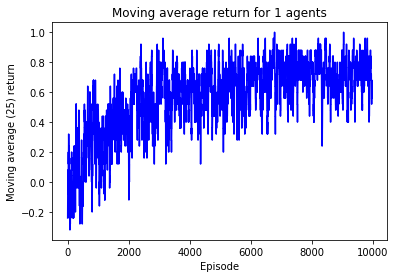

In [142]:
### Use this cell to produce the learning curve for Exercise 2b
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

class RandomAgent():
    
    def __init__(self):
        pass
    
    def choose_action(self, available_actions):
        return random.choice(available_actions)


class QLearningAgent():
    def __init__(self, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}
        self.prev_state = None
        self.prev_q = 0.0
        self.prev_state_action = None
        
    def reset(self):
        self.prev_state = None
        self.prev_q = 0.0
        self.prev_state_action = None
    
    def choose_action(self, available_actions, state):
        self.prev_state = state
        
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(available_actions)
            self.prev_q = self.getQ(self.prev_state, action)
            self.prev_state_action = (self.prev_state, action)
            return action
        else:
            qs = [self.getQ(state, action) for action in available_actions]
            #if not qs:
            #print("qs:", qs)
            maxQ = max(qs)
            if qs.count(maxQ) > 1:
                best = [i for i in range(len(available_actions)) if qs[i] == maxQ]
                i = random.choice(best)
            else:
                i = qs.index(maxQ)
        
        action = available_actions[i]
        self.prev_q = self.getQ(self.prev_state, action)
        self.prev_state_action = (self.prev_state, action)
        
        return action
    
    def getQ(self, state, action):
        if(self.Q.get((state, action))) is None:
            self.Q[(state, action)] = 0.0
        return self.Q.get((state,action))
    
    def updateQ(self, state, new_state, reward, action, available_actions):
        qs = []
        for a in available_actions:
            qs.append(self.getQ(new_state, a))
        if qs:
            max_next_Q = max(qs)
        else:
            max_next_Q = 0.0
        print("qs:", qs, "\tMax q:", max_next_Q)
        print("Current Q:", self.Q.get((state, action), 0))
        self.Q[(state, action)] = ((1 - self.alpha) * self.Q.get((state, action), 0)) + (self.alpha * (reward + self.gamma * max_next_Q))
        print("Updated Q:", self.Q.get((state, action), 0))


def play(q_agent, random_agent, n_episodes):
    for episode in range(n_episodes):

        reward = 0
        env = Tictactoe_Q()
        players = ["Q", "R"]
        random.shuffle(players)
        
        # If first player is the random agent, make a move
        if players[0] == "R":
            available_actions = env.get_available_actions()
            action = random_agent.choose_action(available_actions)
            env.make_move("R", action)
            
        while not env.is_done():

            state = np.copy(env.board)

            # Q-learning agent makes a move
            available_actions = env.get_available_actions()
            action = q_agent.choose_action(available_actions, tuple(state))
            env.make_move("Q", action)
            
            winner = env.check_win() # returns None, 0 = draw, 1 = player O won, 2 = player X won
            # If game is finished, random agent cannot make a move
            if winner != None:
                new_state = np.copy(env.board)
                reward = env.get_reward(winner)
                reward_array[episode] += reward

            else:
                # Random agent makes a move
                available_actions = env.get_available_actions()
                chosen_action = random_agent.choose_action(available_actions)
                env.make_move("R", chosen_action)
                new_state = np.copy(env.board)
            
                winner = env.check_win()
                if winner != None:
                    reward = env.get_reward(winner)
                    reward_array[episode] += reward

            
            #print("Action:", action)
            #print("Reward:", reward)
            available_actions = env.get_available_actions()
            #print(state, new_state, reward, action, available_actions)
            q_agent.updateQ(tuple(state), tuple(new_state), reward, action, available_actions)
            #print("Q value:", q_agent.Q[(tuple(state), action)])
    
    Q_array.append(q_agent.Q)

    
alpha = 0.1
gamma = 1
epsilon = 0.1
#initial_Q = 0

n_episodes = 10000
n_agents = 1

reward_array = np.zeros(n_episodes)
Q_array = []

for i in range(n_agents):

    random_agent = RandomAgent()
    q_agent = QLearningAgent(alpha, gamma, epsilon)
    
    play(q_agent, random_agent, n_episodes)
    
    
#print(reward_array)            

#cum_reward_array = np.cumsum(reward_array)

#print(q_agent.Q)

average_returns = np.zeros(n_episodes)
for i in range(0, n_episodes):
    #print(reward_array[i], cum_reward_array[i])
    #average_returns[i] = (cum_reward_array[i] / n_agents) / (i + 1)
    average_returns[i] = (reward_array[i] / n_agents) #/ (i + 1)

# Moving average function is not mine and was taken from the following link:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n=25) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_array = moving_average(reward_array) / n_agents

plt.plot(moving_average_array, color="blue", label="Average for 10 agents")
plt.title("Moving average return for "+ str(n_agents) + " agents")
plt.xlabel("Episode")
plt.ylabel("Moving average (25) return")
#plt.legend()
plt.show()

In 3 sentences or less, (1) explain the state representation you used, (2) discuss the learning curve you produced. 


### Exercise 2c: Optimal policy (20 marks)
What is the optimal play for the agent in the following state? You must answer by writing a function that takes a state as input and _prints_ the "after-state" that would result from playing an optimal action. The printed output can be primitive but the board has to be somewhat recognizable.   <img src="images/tic_tac_toe.png" style="width: 80px;"/> 

In [146]:
def convert(board):
    return board[0] * (3**8) + board[1] * (3**7) + board[2] * (3**6) + board[3] * (3**5) + board[4] * (3**4) \
        + board[5] * (3**3) + board[6] * (3**2) + board[7] * (3**1) + board[8] * (3**0)

for a in [0,1,2]:
    for b in [0,1,2]:
        for c in [0,1,2]:
            for d in [0,1,2]:
                for e in [0,1,2]:
                    for f in [0,1,2]:
                        for g in [0,1,2]:
                            for h in [0,1,2]:
                                for i in [0,1,2]:
                                    board = np.array([a,b,c,d,e,f,g,h,i])
                                    #print(convert(board))

ternary_state = np.array([1, 2, 0, 0, 2, 0, 0, 1, 0])
conversion_vector = 3 ** np.arange(9)
print(conversion_vector)
print(int(ternary_state.dot(conversion_vector)))

q = np.zeros((19683, 9))
for i in range(19683):
    print(q[i])
                                    

[   1    3    9   27   81  243  729 2187 6561]
2356
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.

In [138]:
### You may use this code cell to answer Exercise 2c.

def optimal_policy(state):
    #count1 = 0
    #count2 = 0
    best_action = 9
    best_value = 0
    for Q_table in Q_array:
        print("test")
        for key, value in Q_table.items():
            #count1 += 1
            #print(key)
            if key[0] == tuple(state):
                if value > best_value:
                    best_action = key[1]
                #print("Found")
                print("Action:", key[1], "Value", value)
            #if value > 0:
            #    count2 += 1
    
    state[best_action] = 1
    print(np.reshape(state, (3,3)))
    
    #print(count1)
    #print(count2)

state = np.array([1, 2, 0, 0, 2, 0, 0, 1, 0])
#b = np.reshape(state, (3,3))
#print(b)

optimal_policy(state)

test


IndexError: index 9 is out of bounds for axis 0 with size 9

Please ignore this cell. We will use this cell to mark your answer. 


### Exercise 2d: Sarsa (40 marks)
Implement Sarsa to learn how to play Tic-tac-toe against a random player. Produce a learning curve. Also include the learning curve of your previously trained Q-learning agent in the same plot. Discuss the learning curves. For your reference, the pseudo-code for SARSA is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.4).
<img src="images/SARSA.png" style="width: 600px;"/>



In [ ]:
### Use this cell to produce the plot for Exercise 2d

import itertools
import matplotlib.pyplot as plt
%matplotlib inline

class RandomAgent():
    
    def __init__(self):
        pass
    
    def choose_action(self, available_actions):
        return random.choice(available_actions)


class SarsaAgent():
    def __init__(self, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}
        self.prev_state = None
        self.prev_q = 0.0
        self.prev_state_action = None
        
    def reset(self):
        self.prev_state = None
        self.prev_q = 0.0
        self.prev_state_action = None
    
    def choose_action(self, available_actions, state):
        self.prev_state = state
        
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(available_actions)
            self.prev_q = self.getQ(self.prev_state, action)
            self.prev_state_action = (self.prev_state, action)
            return action
        else:
            qs = [self.getQ(state, action) for action in available_actions]
            #print("qs:", qs)
            maxQ = max(qs)
            if qs.count(maxQ) > 1:
                best = [i for i in range(len(available_actions)) if qs[i] == maxQ]
                i = random.choice(best)
            else:
                i = qs.index(maxQ)
        
        action = available_actions[i]
        self.prev_q = self.getQ(self.prev_state, action)
        self.prev_state_action = (self.prev_state, action)
        
        return action
    
    def getQ(self, state, action):
        if(self.Q.get((state, action))) is None:
            self.Q[(state, action)] = 0.0
        return self.Q.get((state,action))
    
    def updateQ(self, state, reward, available_actions):
        qs = []
        for action in available_actions:
            qs.append(self.getQ(tuple(state), action))
        if qs:
            max_next_Q = max(qs)
        else:
            max_next_Q = 0.0
        self.Q[self.prev_state_action] = ((1 - self.alpha) * self.prev_q) + (self.alpha * (reward + self.gamma * max_next_Q))

alpha = 0.1
gamma = 1
epsilon = 0.05
initial_Q = 0

n_episodes = 5000

reward_array = np.zeros(n_episodes)
Q_array = []

for i in range(10):

    random_agent = RandomAgent()
    sarsa_agent = SarsaAgent(alpha, gamma, epsilon)

    for episode in range(n_episodes):
        #print("\nEpisode\n")
        reward = 0
        env = Tictactoe_Q()
        players = ["Q", "R"]
        random.shuffle(players)
        i = 0
        while not env.is_done():
            player = players[i % 2]
            #print(player, "'s turn")
            state = env.board
            #env.print_board()
            available_actions = env.get_available_actions()

            if player == "Q":
                chosen_action = q_agent.choose_action(available_actions, tuple(state))
            else:
                chosen_action = random_agent.choose_action(available_actions)

            env.make_move(player, chosen_action)
            winner = env.check_win()
            if winner != None:
                #print("Winner:", winner)
                if winner == 0:
                    reward = 0
                    reward_array[episode] += 0
                elif winner == 1:
                    reward = 1
                    reward_array[episode] += 1
                elif winner == 2:
                    reward = -1
                    reward_array[episode] += -1
        
                q_agent.updateQ(tuple(state), reward, available_actions)
                
            i += 1
    
    Q_array.append(q_agent.Q)

#print(reward_array)            

cum_reward_array = np.cumsum(reward_array)

#print(q_agent.Q)

average_returns = np.zeros(n_episodes)
for i in range(0, n_episodes):
    average_returns[i] = (cum_reward_array[i] / 10) / (i + 1)

plt.plot(average_returns, color="blue", label="Average")
plt.xlabel("Episode")
plt.ylabel("Average return")
plt.legend()
plt.show()

Discuss the learning curves here in 10 sentences or less.
